In [1]:
import numpy as np
import pandas as pd
import fipy as fp
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import re
import pdb
import h5py
import lncrna_analysis_helper as lh
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

In [18]:
class LncrnaDataAnalysis:
    
    dynamical_variables = ['steps', 't', 
                               'average_protein_in_enhancer_well', 'average_lncrna_in_enhancer_well', 
                               'average_mrna_in_enhancer_well',
                               'rate_average_protein_in_enhancer_well', 'rate_average_lncrna_in_enhancer_well', 
                               'rate_average_mrna_in_enhancer_well',
                               'flux_of_protein_into_enhancer_well', 'flux_of_lncrna_into_enhancer_well', 
                               'flux_of_mrna_into_enhancer_well',
                               'flux_of_protein_into_enhancer_well_absum',
                               'flux_of_protein_into_enhancer_well_DW', 'flux_of_protein_into_enhancer_well_well_att', 
                               'flux_of_protein_into_enhancer_well_elec_att', 'flux_of_protein_into_enhancer_well_reent_rep',
                               'flux_of_lncrna_into_enhancer_well_absum',
                               'flux_of_lncrna_into_enhancer_well_elec_att', 'flux_of_lncrna_into_enhancer_well_well_att', 
                               'flux_of_lncrna_into_enhancer_well_reent_rep', 'flux_of_lncrna_into_enhancer_well_rna_rep',
                               'flux_of_protein_into_enhancer_well_DW_frac', 'flux_of_protein_into_enhancer_well_well_att_frac', 
                               'flux_of_protein_into_enhancer_well_elec_att_frac', 'flux_of_protein_into_enhancer_well_reent_rep_frac',
                               'flux_of_lncrna_into_enhancer_well_elec_att_frac', 'flux_of_lncrna_into_enhancer_well_well_att_frac', 
                               'flux_of_lncrna_into_enhancer_well_reent_rep_frac', 'flux_of_lncrna_into_enhancer_well_rna_rep_frac',
                               'average_protein_in_lncrna_well', 'average_lncrna_in_lncrna_well', 
                               'average_mrna_in_lncrna_well',
                               'rate_average_protein_in_lncrna_well', 'rate_average_lncrna_in_lncrna_well', 
                               'rate_average_mrna_in_lncrna_well',
                               'flux_of_protein_into_lncrna_well', 'flux_of_lncrna_into_lncrna_well', 
                               'flux_of_mrna_into_lncrna_well',
                               'flux_of_protein_into_lncrna_well_absum',
                               'flux_of_protein_into_lncrna_well_DW', 'flux_of_protein_into_lncrna_well_well_att', 
                               'flux_of_protein_into_lncrna_well_elec_att', 'flux_of_protein_into_lncrna_well_reent_rep',
                               'flux_of_lncrna_into_lncrna_well_absum',
                               'flux_of_lncrna_into_lncrna_well_elec_att', 'flux_of_lncrna_into_lncrna_well_well_att', 
                               'flux_of_lncrna_into_lncrna_well_reent_rep', 'flux_of_lncrna_into_lncrna_well_rna_rep',
                               'flux_of_protein_into_lncrna_well_DW_frac', 'flux_of_protein_into_lncrna_well_well_att_frac',
                               'flux_of_protein_into_lncrna_well_elec_att_frac', 'flux_of_protein_into_lncrna_well_reent_rep_frac',
                               'flux_of_lncrna_into_lncrna_well_elec_att_frac', 'flux_of_lncrna_into_lncrna_well_well_att_frac', 
                               'flux_of_lncrna_into_lncrna_well_reent_rep_frac', 'flux_of_lncrna_into_lncrna_well_rna_rep_frac',
                               'total_amount_of_mrna', 'molar_rate_of_mrna_production', 'net_rate_of_mrna_increase',
                               'molar_rate_of_mrna_production_in_enhancer_well', 
                               'condensate_area', 'rate_condensate_area']
        
    steady_state_variables = ['average_protein_in_condensate', 'average_lncrna_in_condensate', 
                                  'average_mrna_in_condensate',
                                  'average_protein_in_lncrna_well', 'average_lncrna_in_lncrna_well', 
                                  'average_mrna_in_lncrna_well',
                                  'total_amount_of_mrna', 'molar_rate_of_mrna_production', 
                                  'molar_rate_of_mrna_production_in_condensate',
                                  'condensate_area']
    
    dynamical_trajectory_file_name = 'dynamical_trajectories.hdf5'
    
    def __init__(self):
        
        return
    
    def calculate_dynamical_trajectories(self, target_directory, directory_name_pattern, condensate_concentration_cutoff=0.25,
                                         stats_file='stats.txt', param_file='input_params.txt', 
                                         spatial_variables_file='spatial_variables.hdf5', overwrite=False):
        
        nx = 100
        dx = 0.1
        
        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(directory_name_pattern)
            match = re.search(regex, root)

            if match != None:
                
                if self.dynamical_trajectory_file_name not in files or overwrite:
                
                    # Read steps and corresponding simulation times from stats file
                    stats_file_name = root + '/' + stats_file
                    df_stats = pd.read_csv(stats_file_name, '\t')
                    times = df_stats['t']
                    steps = df_stats['step']

                    # Read values of input parameters from param_file
                    input_param_file = root + '/' + param_file
                    input_parameters = lh.input_parse(input_param_file)
                    
                    if input_parameters['nx'] != nx or input_parameters['dx'] != dx:
                        nx = input_parameters['nx']
                        dx = input_parameters['dx']
                        mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)

                    # Create hdf5 file to store dynamical trajectories
                    with h5py.File(os.path.join(root + '/' + self.dynamical_trajectory_file_name), 'w') as dt_f:
                        for dv in self.dynamical_variables:
                            dt_f.create_dataset(dv, shape=(len(steps),1))

                    # Compute values of dynamical variables by looping through the spatial variables file
                    spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file

                    with h5py.File(spatial_variable_hdf5_file_name) as sp_f:      
                        with h5py.File(os.path.join(root + '/' + self.dynamical_trajectory_file_name), 'a') as dt_f:

                            print('Generating ' + root + '/' + self.dynamical_trajectory_file_name + ' ...')
                            
                            dt_f['steps'][:,0] = steps
                            dt_f['t'][:,0] = times

                            indices_enhancer_well = (mesh.x+0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + mesh.y**2 - 1.0*input_parameters['sigma']**2 < 0
                            indices_lncrna_well = (mesh.x-0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + mesh.y**2 - 1.0*input_parameters['L_R']**2 < 0

                            for s in range(len(steps)):

                                phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][s])
                                if 'phi_m' in sp_f.keys():
                                    phi_m = fp.CellVariable(mesh=mesh, value = sp_f['phi_m'][s])
                                else:
                                    phi_m = fp.CellVariable(mesh=mesh, value = 0.0)  
                                    
                                phi_r = fp.CellVariable(mesh=mesh, value = sp_f['phi_r'][s])
                                
                                mu_p = fp.CellVariable(mesh=mesh, value = sp_f['mu_p'][s])
                                # mu_m = fp.CellVariable(mesh=mesh, value = sp_f['mu_m'][s])
                                mu_r = fp.CellVariable(mesh=mesh, value = sp_f['mu_r'][s])

                                dt_f['average_protein_in_lncrna_well'][s] = np.sum(phi_p.value[indices_lncrna_well]*mesh.cellVolumes[indices_lncrna_well])/np.sum(mesh.cellVolumes[indices_lncrna_well])
                                dt_f['average_mrna_in_lncrna_well'][s] = np.sum(phi_m.value[indices_lncrna_well]*mesh.cellVolumes[indices_lncrna_well])/np.sum(mesh.cellVolumes[indices_lncrna_well])
                                dt_f['average_lncrna_in_lncrna_well'][s] = np.sum(phi_r.value[indices_lncrna_well]*mesh.cellVolumes[indices_lncrna_well])/np.sum(mesh.cellVolumes[indices_lncrna_well])
                                                                
                                dt_f['average_protein_in_enhancer_well'][s] = np.sum(phi_p.value[indices_enhancer_well]*mesh.cellVolumes[indices_enhancer_well])/np.sum(mesh.cellVolumes[indices_enhancer_well])
                                dt_f['average_mrna_in_enhancer_well'][s] = np.sum(phi_m.value[indices_enhancer_well]*mesh.cellVolumes[indices_enhancer_well])/np.sum(mesh.cellVolumes[indices_enhancer_well])
                                dt_f['average_lncrna_in_enhancer_well'][s] = np.sum(phi_r.value[indices_enhancer_well]*mesh.cellVolumes[indices_enhancer_well])/np.sum(mesh.cellVolumes[indices_enhancer_well])
                                
                                dt_f['total_amount_of_mrna'][s] = np.sum(phi_m.value*mesh.cellVolumes)
                                
                                # pdb.set_trace()
                                
                                mu_p_T1 = 4*input_parameters['rho_s']*(phi_p-input_parameters['c_alpha'])*(phi_p-input_parameters['c_beta'])*(phi_p-0.5*(input_parameters['c_alpha']+input_parameters['c_beta']))
                                dt_f['flux_of_protein_into_enhancer_well_DW'][s] = np.sum(input_parameters['M_protein']*mu_p_T1.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                mu_p_T2 = phi_p - phi_p - 1.0*input_parameters['c_max']*np.exp(-((mesh.x+0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + mesh.y**2)/input_parameters['sigma']**2)
                                dt_f['flux_of_protein_into_enhancer_well_well_att'][s] = np.sum(input_parameters['M_protein']*mu_p_T2.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                mu_p_T3 = -1.0*input_parameters['chi']*phi_r -1.0*input_parameters['chi']*phi_m
                                dt_f['flux_of_protein_into_enhancer_well_elec_att'][s] = np.sum(input_parameters['M_protein']*mu_p_T3.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                mu_p_T4 = 2.0*input_parameters['c']*phi_p*(phi_r+phi_m)**2
                                dt_f['flux_of_protein_into_enhancer_well_reent_rep'][s] = np.sum(input_parameters['M_protein']*mu_p_T4.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                
                                mu_r_T1 = -1.0*input_parameters['chi']*phi_p
                                dt_f['flux_of_lncrna_into_enhancer_well_elec_att'][s] = np.sum(input_parameters['M_rna']*mu_r_T1.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                mu_r_T2 = 2.0*input_parameters['c']*(phi_r+phi_m)*(phi_p)**2
                                dt_f['flux_of_lncrna_into_enhancer_well_reent_rep'][s] = np.sum(input_parameters['M_rna']*mu_r_T2.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                mu_r_T3 = 2.0*(input_parameters['rho_r']*phi_r+input_parameters['rho_r']*phi_m)
                                dt_f['flux_of_lncrna_into_enhancer_well_rna_rep'][s] = np.sum(input_parameters['M_rna']*mu_r_T3.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                mu_r_T4 = phi_p - phi_p - 1.0*input_parameters['K']*np.exp(-((mesh.x-0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + mesh.y**2)/input_parameters['L_R']**2)
                                dt_f['flux_of_lncrna_into_enhancer_well_well_att'][s] = np.sum(input_parameters['M_rna']*mu_r_T4.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                
                                dt_f['flux_of_protein_into_enhancer_well'][s] = np.sum(input_parameters['M_protein']*mu_p.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                dt_f['flux_of_lncrna_into_enhancer_well'][s] = dt_f['flux_of_lncrna_into_enhancer_well_elec_att'][s] + dt_f['flux_of_lncrna_into_enhancer_well_reent_rep'][s] + dt_f['flux_of_lncrna_into_enhancer_well_rna_rep'][s] + dt_f['flux_of_lncrna_into_enhancer_well_well_att'][s]
                                dt_f['flux_of_mrna_into_enhancer_well'][s] = np.sum(input_parameters['M_mrna']*phi_m.faceGrad.divergence[indices_enhancer_well].value*mesh.cellVolumes[indices_enhancer_well])
                                
                                dt_f['flux_of_protein_into_enhancer_well_absum'][s] = np.abs(dt_f['flux_of_protein_into_enhancer_well_DW'][s]) + np.abs(dt_f['flux_of_protein_into_enhancer_well_well_att'][s]) + np.abs(dt_f['flux_of_protein_into_enhancer_well_elec_att'][s]) + np.abs(dt_f['flux_of_protein_into_enhancer_well_reent_rep'][s])
                                dt_f['flux_of_protein_into_enhancer_well_DW_frac'][s] = dt_f['flux_of_protein_into_enhancer_well_DW'][s]/dt_f['flux_of_protein_into_enhancer_well_absum'][s]
                                dt_f['flux_of_protein_into_enhancer_well_well_att_frac'][s] = dt_f['flux_of_protein_into_enhancer_well_well_att'][s]/dt_f['flux_of_protein_into_enhancer_well_absum'][s]
                                dt_f['flux_of_protein_into_enhancer_well_elec_att_frac'][s] = dt_f['flux_of_protein_into_enhancer_well_elec_att'][s]/dt_f['flux_of_protein_into_enhancer_well_absum'][s]
                                dt_f['flux_of_protein_into_enhancer_well_reent_rep_frac'][s] = dt_f['flux_of_protein_into_enhancer_well_reent_rep'][s]/dt_f['flux_of_protein_into_enhancer_well_absum'][s]
                                
                                dt_f['flux_of_lncrna_into_enhancer_well_absum'][s] = np.abs(dt_f['flux_of_lncrna_into_enhancer_well_elec_att'][s]) + np.abs(dt_f['flux_of_lncrna_into_enhancer_well_reent_rep'][s]) + np.abs(dt_f['flux_of_lncrna_into_enhancer_well_rna_rep'][s]) + np.abs(dt_f['flux_of_lncrna_into_enhancer_well_well_att'][s])
                                dt_f['flux_of_lncrna_into_enhancer_well_elec_att_frac'][s] = dt_f['flux_of_lncrna_into_enhancer_well_elec_att'][s]/dt_f['flux_of_lncrna_into_enhancer_well_absum'][s]
                                dt_f['flux_of_lncrna_into_enhancer_well_reent_rep_frac'][s] = dt_f['flux_of_lncrna_into_enhancer_well_reent_rep'][s]/dt_f['flux_of_lncrna_into_enhancer_well_absum'][s]
                                dt_f['flux_of_lncrna_into_enhancer_well_rna_rep_frac'][s] = dt_f['flux_of_lncrna_into_enhancer_well_rna_rep'][s]/dt_f['flux_of_lncrna_into_enhancer_well_absum'][s]
                                dt_f['flux_of_lncrna_into_enhancer_well_well_att_frac'][s] = dt_f['flux_of_lncrna_into_enhancer_well_well_att'][s]/dt_f['flux_of_lncrna_into_enhancer_well_absum'][s]
                                

                                dt_f['flux_of_protein_into_lncrna_well_DW'][s] = np.sum(input_parameters['M_protein']*mu_p_T1.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                dt_f['flux_of_protein_into_lncrna_well_well_att'][s] = np.sum(input_parameters['M_protein']*mu_p_T2.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                dt_f['flux_of_protein_into_lncrna_well_elec_att'][s] = np.sum(input_parameters['M_protein']*mu_p_T3.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                dt_f['flux_of_protein_into_lncrna_well_reent_rep'][s] = np.sum(input_parameters['M_protein']*mu_p_T4.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                
                                dt_f['flux_of_lncrna_into_lncrna_well_elec_att'][s] = np.sum(input_parameters['M_rna']*mu_r_T1.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                dt_f['flux_of_lncrna_into_lncrna_well_reent_rep'][s] = np.sum(input_parameters['M_rna']*mu_r_T2.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                dt_f['flux_of_lncrna_into_lncrna_well_rna_rep'][s] = np.sum(input_parameters['M_rna']*mu_r_T3.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                dt_f['flux_of_lncrna_into_lncrna_well_well_att'][s] = np.sum(input_parameters['M_rna']*mu_r_T4.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                
                                dt_f['flux_of_protein_into_lncrna_well'][s] = np.sum(input_parameters['M_protein']*mu_p.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                dt_f['flux_of_lncrna_into_lncrna_well'][s] = dt_f['flux_of_lncrna_into_lncrna_well_elec_att'][s] + dt_f['flux_of_lncrna_into_lncrna_well_reent_rep'][s] + dt_f['flux_of_lncrna_into_lncrna_well_rna_rep'][s] + dt_f['flux_of_lncrna_into_lncrna_well_well_att'][s]
                                dt_f['flux_of_mrna_into_lncrna_well'][s] = np.sum(input_parameters['M_mrna']*phi_m.faceGrad.divergence[indices_lncrna_well].value*mesh.cellVolumes[indices_lncrna_well])
                                
                                dt_f['flux_of_protein_into_lncrna_well_absum'][s] = np.abs(dt_f['flux_of_protein_into_lncrna_well_DW'][s]) + np.abs(dt_f['flux_of_protein_into_lncrna_well_well_att'][s]) + np.abs(dt_f['flux_of_protein_into_lncrna_well_elec_att'][s]) + np.abs(dt_f['flux_of_protein_into_lncrna_well_reent_rep'][s])
                                dt_f['flux_of_protein_into_lncrna_well_DW_frac'][s] = dt_f['flux_of_protein_into_lncrna_well_DW'][s]/dt_f['flux_of_protein_into_lncrna_well_absum'][s]
                                dt_f['flux_of_protein_into_lncrna_well_well_att_frac'][s] = dt_f['flux_of_protein_into_lncrna_well_well_att'][s]/dt_f['flux_of_protein_into_lncrna_well_absum'][s]
                                dt_f['flux_of_protein_into_lncrna_well_elec_att_frac'][s] = dt_f['flux_of_protein_into_lncrna_well_elec_att'][s]/dt_f['flux_of_protein_into_lncrna_well_absum'][s]
                                dt_f['flux_of_protein_into_lncrna_well_reent_rep_frac'][s] = dt_f['flux_of_protein_into_lncrna_well_reent_rep'][s]/dt_f['flux_of_protein_into_lncrna_well_absum'][s]
                                
                                dt_f['flux_of_lncrna_into_lncrna_well_absum'][s] = np.abs(dt_f['flux_of_lncrna_into_lncrna_well_elec_att'][s]) + np.abs(dt_f['flux_of_lncrna_into_lncrna_well_reent_rep'][s]) + np.abs(dt_f['flux_of_lncrna_into_lncrna_well_rna_rep'][s]) + np.abs(dt_f['flux_of_lncrna_into_lncrna_well_well_att'][s]) 
                                dt_f['flux_of_lncrna_into_lncrna_well_elec_att_frac'][s] = dt_f['flux_of_lncrna_into_lncrna_well_elec_att'][s]/dt_f['flux_of_lncrna_into_lncrna_well_absum'][s]
                                dt_f['flux_of_lncrna_into_lncrna_well_reent_rep_frac'][s] = dt_f['flux_of_lncrna_into_lncrna_well_reent_rep'][s]/dt_f['flux_of_lncrna_into_lncrna_well_absum'][s]
                                dt_f['flux_of_lncrna_into_lncrna_well_rna_rep_frac'][s] = dt_f['flux_of_lncrna_into_lncrna_well_rna_rep'][s]/dt_f['flux_of_lncrna_into_lncrna_well_absum'][s]
                                dt_f['flux_of_lncrna_into_lncrna_well_well_att_frac'][s] = dt_f['flux_of_lncrna_into_lncrna_well_well_att'][s]/dt_f['flux_of_lncrna_into_lncrna_well_absum'][s]
                                
                                
                                indices_protein_rich = phi_p.value > condensate_concentration_cutoff                    

                                if np.any(indices_protein_rich):                                    
                                    dt_f['condensate_area'][s] = np.sum(mesh.cellVolumes[indices_protein_rich])
                                else:
                                    dt_f['condensate_area'][s] = 0.0
                                    
                                dt_f['rate_condensate_area'][:,0] = np.gradient(dt_f['condensate_area'][:,0], dt_f['t'][:,0])
                                
                                dt_f['molar_rate_of_mrna_production'][s] = 0.0
                                dt_f['molar_rate_of_mrna_production_in_enhancer_well'][s] = 0.0
                                dt_f['net_rate_of_mrna_increase'][s] = 0.0                                
                            
                            # pdb.set_trace()
                            
                            dt_f['rate_average_protein_in_lncrna_well'][:,0] = np.gradient(dt_f['average_protein_in_lncrna_well'][:,0], dt_f['t'][:,0])
                            dt_f['rate_average_mrna_in_lncrna_well'][:,0] = 0.0
                            dt_f['rate_average_lncrna_in_lncrna_well'][:,0] = np.gradient(dt_f['average_lncrna_in_lncrna_well'][:,0], dt_f['t'][:,0])
                            
                            dt_f['rate_average_protein_in_enhancer_well'][:,0] = np.gradient(dt_f['average_protein_in_enhancer_well'][:,0], dt_f['t'][:,0])
                            dt_f['rate_average_mrna_in_enhancer_well'][:,0] = 0.0
                            dt_f['rate_average_lncrna_in_enhancer_well'][:,0] = np.gradient(dt_f['average_lncrna_in_enhancer_well'][:,0], dt_f['t'][:,0])
                            
    def plot_dynamical_variables_vary_LP(self, save_directory, save_filename, 
                                         activity_and_lncrna_directory,
                                         activity_and_lncrna_pattern,
                                         kp_list, L_P_list, phi_r_list):        

        colors = cm.get_cmap('copper', len(L_P_list))
        color_values = np.linspace(0.0,1.0,len(L_P_list))

        for i in range(len(phi_r_list)):
            for j in range(len(kp_list)):

                fig, axs = plt.subplots(4,6,figsize=(60,28))
                    
                for k in range(len(L_P_list)):
                    for root, dirs, files in os.walk(activity_and_lncrna_directory):
                        regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[i],L_P=L_P_list[k],kp=kp_list[j]))
                        match = re.search(regex, root)
                        if match != None:
                            with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 
                                
                                axs[0,0].plot(sp_f['t'],sp_f['average_protein_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[0,0].set_xlabel('Time', fontsize=20)
                                axs[0,0].set_ylabel(r'<$\phi_p$> in enhancer well', fontsize=20)

                                axs[0,1].plot(sp_f['t'],sp_f['average_lncrna_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[0,1].set_xlabel('Time', fontsize=20)
                                axs[0,1].set_ylabel(r'<$\phi_r$> in enhancer well', fontsize=20)

                                axs[0,2].plot(sp_f['t'],sp_f['average_mrna_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[0,2].set_xlabel('Time', fontsize=20)
                                axs[0,2].set_ylabel(r'<$\phi_m$> in enhancer well', fontsize=20)

                                axs[0,3].plot(sp_f['t'],sp_f['average_protein_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[0,3].set_xlabel('Time', fontsize=20)
                                axs[0,3].set_ylabel(r'<$\phi_p$> in lncrna well', fontsize=20)

                                axs[0,4].plot(sp_f['t'],sp_f['average_lncrna_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[0,4].set_xlabel('Time', fontsize=20)
                                axs[0,4].set_ylabel(r'<$\phi_r$> in lncrna well', fontsize=20)

                                axs[0,5].plot(sp_f['t'],sp_f['average_mrna_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[0,5].set_xlabel('Time', fontsize=20)
                                axs[0,5].set_ylabel(r'<$\phi_m$> in lncrna', fontsize=20)

                                axs[1,0].plot(sp_f['t'],sp_f['rate_average_protein_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[1,0].set_xlabel('Time', fontsize=20)
                                axs[1,0].set_ylabel(r'd<$\phi_p$>/dt in enhancer well', fontsize=20)

                                axs[1,1].plot(sp_f['t'],sp_f['rate_average_lncrna_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[1,1].set_xlabel('Time', fontsize=20)
                                axs[1,1].set_ylabel(r'd<$\phi_r$>/dt in enhancer well', fontsize=20)

                                axs[1,2].plot(sp_f['t'],sp_f['rate_average_mrna_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[1,2].set_xlabel('Time', fontsize=20)
                                axs[1,2].set_ylabel(r'd<$\phi_m$>/dt in enhancer well', fontsize=20)

                                axs[1,3].plot(sp_f['t'],sp_f['rate_average_protein_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[1,3].set_xlabel('Time', fontsize=20)
                                axs[1,3].set_ylabel(r'd<$\phi_p$>/dt in lncrna well', fontsize=20)

                                axs[1,4].plot(sp_f['t'],sp_f['rate_average_lncrna_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[1,4].set_xlabel('Time', fontsize=20)
                                axs[1,4].set_ylabel(r'd<$\phi_r$>/dt in lncrna well', fontsize=20)

                                axs[1,5].plot(sp_f['t'],sp_f['rate_average_mrna_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[1,5].set_xlabel('Time', fontsize=20)
                                axs[1,5].set_ylabel(r'd<$\phi_m$>/dt in lncrna', fontsize=20)

                                axs[2,0].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[2,0].set_xlabel('Time', fontsize=20)
                                axs[2,0].set_ylabel(r'$\int M_p  \nabla \mu_p \dot d S $ in enhancer well', fontsize=20)

                                axs[2,1].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[2,1].set_xlabel('Time', fontsize=20)
                                axs[2,1].set_ylabel(r'$\int M_r  \nabla \mu_r \dot d S $ in enhancer well', fontsize=20)

                                axs[2,2].plot(sp_f['t'],sp_f['flux_of_mrna_into_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[2,2].set_xlabel('Time', fontsize=20)
                                axs[2,2].set_ylabel(r'$\int D_m  \nabla \phi_r \dot d S $ in enhancer well', fontsize=20)

                                axs[2,3].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[2,3].set_xlabel('Time', fontsize=20)
                                axs[2,3].set_ylabel(r'$\int M_p  \nabla \mu_p \dot d S $ in lncrna well', fontsize=20)

                                axs[2,4].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[2,4].set_xlabel('Time', fontsize=20)
                                axs[2,4].set_ylabel(r'$\int M_r  \nabla \mu_r \dot d S $ in lncrna well', fontsize=20)

                                axs[2,5].plot(sp_f['t'],sp_f['flux_of_mrna_into_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[2,5].set_xlabel('Time', fontsize=20)
                                axs[2,5].set_ylabel(r'$\int D_m  \nabla \phi_r \dot d S $ in lncrna', fontsize=20)

                                axs[3,0].plot(sp_f['t'],sp_f['total_amount_of_mrna'], '-o', c=colors(color_values[k]))
                                axs[3,0].set_xlabel('Time', fontsize=20)
                                axs[3,0].set_ylabel(r'$\int \phi_m dV$ in the system', fontsize=20)

                                axs[3,1].plot(sp_f['t'],sp_f['molar_rate_of_mrna_production'], '-o', c=colors(color_values[k]))
                                axs[3,1].set_xlabel('Time', fontsize=20)
                                axs[3,1].set_ylabel(r'$\int k_p( r )\phi_m dV$ in the system', fontsize=20)

                                axs[3,2].plot(sp_f['t'],sp_f['net_rate_of_mrna_increase'], '-o', c=colors(color_values[k]))
                                axs[3,2].set_xlabel('Time', fontsize=20)
                                axs[3,2].set_ylabel(r'd$\int \phi_m dV$/dt in the system', fontsize=20)

                                axs[3,3].plot(sp_f['t'],sp_f['molar_rate_of_mrna_production_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[3,3].set_xlabel('Time', fontsize=20)
                                axs[3,3].set_ylabel(r'$\int k_p( r )\phi_m dV$ in enhancer well', fontsize=20)

                                axs[3,4].plot(sp_f['t'],sp_f['condensate_area'], '-o', c=colors(color_values[k]), label="$L_P$="+str(L_P_list[k]))
                                axs[3,4].set_xlabel('Time', fontsize=20)
                                axs[3,4].set_ylabel(r'Condensate area (A)', fontsize=20)
                                axs[3,4].legend(fontsize=20) 

                                axs[3,5].plot(sp_f['t'],sp_f['rate_condensate_area'], '-o', c=colors(color_values[k]))
                                axs[3,5].set_xlabel('Time', fontsize=20)
                                axs[3,5].set_ylabel(r'$dA/dt$ of condensate', fontsize=20)
                                
                # plt.savefig('20210604-CORRECT_FE/Only_activity_linear_0.4_dynamical_trajectories.png', format='png', dpi=1200)
                plt.savefig(save_directory + save_filename.format(kp=kp_list[j],phi_r=phi_r_list[i]), format='svg', dpi=1200)
                plt.show()
                plt.close()
                
    def plot_flux_contributions_vary_LP(self, save_directory, save_filename, 
                                         activity_and_lncrna_directory, 
                                         activity_and_lncrna_pattern,
                                         kp_list, L_P_list, phi_r_list):        

        colors = cm.get_cmap('copper', len(L_P_list))
        color_values = np.linspace(0.0,1.0,len(L_P_list))

        for i in range(len(phi_r_list)):
            for j in range(len(kp_list)):

                fig, axs = plt.subplots(4,4,figsize=(40,28))
                    
                for k in range(len(L_P_list)):
                    for root, dirs, files in os.walk(activity_and_lncrna_directory):
                        regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[i],L_P=L_P_list[k],kp=kp_list[j]))
                        match = re.search(regex, root)
                        if match != None:
                            with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 

                                axs[0,0].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_DW'], '-o', c=colors(color_values[k]), label='$L_P$='+str(L_P_list[k]))
                                axs[0,0].set_xlabel('Time', fontsize=20)
                                axs[0,0].set_ylabel('DW, Protein, enhancer well', fontsize=20)
                                axs[0,0].legend(fontsize=20)

                                axs[0,1].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_well_att'], '-o', c=colors(color_values[k]))
                                axs[0,1].set_xlabel('Time', fontsize=20)
                                axs[0,1].set_ylabel('Well att., Protein, enhancer well', fontsize=20)

                                axs[0,2].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_elec_att'], '-o', c=colors(color_values[k]))
                                axs[0,2].set_xlabel('Time', fontsize=20)
                                axs[0,2].set_ylabel('Elec att., Protein,  enhancer well', fontsize=20)

                                axs[0,3].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_reent_rep'], '-o', c=colors(color_values[k]))
                                axs[0,3].set_xlabel('Time', fontsize=20)
                                axs[0,3].set_ylabel('Reent rep., Protein,  enhancer well', fontsize=20)

                                axs[1,0].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_elec_att'], '-o', c=colors(color_values[k]))
                                axs[1,0].set_xlabel('Time', fontsize=20)
                                axs[1,0].set_ylabel('Elec att., lncrna,  enhancer well', fontsize=20)

                                axs[1,1].plot(sp_f['t'], sp_f['flux_of_lncrna_into_enhancer_well_well_att'], '-o', c=colors(color_values[k]))
                                axs[1,1].set_xlabel('Time', fontsize=20)
                                axs[1,1].set_ylabel('Well att., lncrna,  enhancer well', fontsize=20)

                                axs[1,2].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_reent_rep'], '-o', c=colors(color_values[k]))
                                axs[1,2].set_xlabel('Time', fontsize=20)
                                axs[1,2].set_ylabel('Reent rep., lncrna,  enhancer well', fontsize=20)

                                axs[1,3].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_rna_rep'], '-o', c=colors(color_values[k]))
                                axs[1,3].set_xlabel('Time', fontsize=20)
                                axs[1,3].set_ylabel('RNA rep., lncrna,  enhancer well', fontsize=20)

                                axs[2,0].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_DW'], '-o', c=colors(color_values[k]))
                                axs[2,0].set_xlabel('Time', fontsize=20)
                                axs[2,0].set_ylabel('DW, Protein, lncrna well', fontsize=20)

                                axs[2,1].plot(sp_f['t'], sp_f['flux_of_protein_into_lncrna_well_well_att'], '-o', c=colors(color_values[k]))
                                axs[2,1].set_xlabel('Time', fontsize=20)
                                axs[2,1].set_ylabel('Well att., Protein, lncrna well', fontsize=20)

                                axs[2,2].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_elec_att'], '-o', c=colors(color_values[k]))
                                axs[2,2].set_xlabel('Time', fontsize=20)
                                axs[2,2].set_ylabel('Elec att., Protein, lncrna well', fontsize=20)

                                axs[2,3].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_reent_rep'], '-o', c=colors(color_values[k]))
                                axs[2,3].set_xlabel('Time', fontsize=20)
                                axs[2,3].set_ylabel('Reent rep., Protein, lncrna well', fontsize=20)

                                axs[3,0].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_elec_att'], '-o', c=colors(color_values[k]))
                                axs[3,0].set_xlabel('Time', fontsize=20)
                                axs[3,0].set_ylabel('Elec att., lncrna, lncrna well', fontsize=20)

                                axs[3,1].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_well_att'], '-o', c=colors(color_values[k]))
                                axs[3,1].set_xlabel('Time', fontsize=20)
                                axs[3,1].set_ylabel('Well att., lncrna, lncrna well', fontsize=20)

                                axs[3,2].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_reent_rep'], '-o', c=colors(color_values[k]))
                                axs[3,2].set_xlabel('Time', fontsize=20)
                                axs[3,2].set_ylabel('Reent rep., lncrna, lncrna well', fontsize=20)

                                axs[3,3].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_rna_rep'], '-o', c=colors(color_values[k]))
                                axs[3,3].set_xlabel('Time', fontsize=20)
                                axs[3,3].set_ylabel('RNA rep., lncrna, lncrna well', fontsize=20)

                # plt.savefig('20210604-CORRECT_FE/Only_activity_linear_0.4_dynamical_trajectories.png', format='png', dpi=1200)
                plt.savefig(save_directory + "raw_fluxes_" + save_filename.format(kp=kp_list[j],phi_r=phi_r_list[i]), format='svg', dpi=1200)
                plt.show()
                plt.close()
                
        for i in range(len(phi_r_list)):
            for j in range(len(kp_list)):

                fig, axs = plt.subplots(4,4,figsize=(40,28))
                    
                for k in range(len(L_P_list)):
                    for root, dirs, files in os.walk(activity_and_lncrna_directory):
                        regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[i],L_P=L_P_list[k],kp=kp_list[j]))
                        match = re.search(regex, root)
                        if match != None:
                            with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 

                                axs[0,0].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_DW_frac'], '-o', c=colors(color_values[k]), label='$L_P$='+str(L_P_list[k]))
                                axs[0,0].set_xlabel('Time', fontsize=20)
                                axs[0,0].set_ylabel('DW, Protein, enhancer well', fontsize=20)
                                axs[0,0].legend(fontsize=20)

                                axs[0,1].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_well_att_frac'], '-o', c=colors(color_values[k]))
                                axs[0,1].set_xlabel('Time', fontsize=20)
                                axs[0,1].set_ylabel('Well att., Protein, enhancer well', fontsize=20)

                                axs[0,2].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_elec_att_frac'], '-o', c=colors(color_values[k]))
                                axs[0,2].set_xlabel('Time', fontsize=20)
                                axs[0,2].set_ylabel('Elec att., Protein,  enhancer well', fontsize=20)

                                axs[0,3].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_reent_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[0,3].set_xlabel('Time', fontsize=20)
                                axs[0,3].set_ylabel('Reent rep., Protein,  enhancer well', fontsize=20)

                                axs[1,0].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_elec_att_frac'], '-o', c=colors(color_values[k]))
                                axs[1,0].set_xlabel('Time', fontsize=20)
                                axs[1,0].set_ylabel('Elec att., lncrna,  enhancer well', fontsize=20)

                                axs[1,1].plot(sp_f['t'], sp_f['flux_of_lncrna_into_enhancer_well_well_att_frac'], '-o', c=colors(color_values[k]))
                                axs[1,1].set_xlabel('Time', fontsize=20)
                                axs[1,1].set_ylabel('Well att., lncrna,  enhancer well', fontsize=20)

                                axs[1,2].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_reent_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[1,2].set_xlabel('Time', fontsize=20)
                                axs[1,2].set_ylabel('Reent rep., lncrna,  enhancer well', fontsize=20)

                                axs[1,3].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_rna_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[1,3].set_xlabel('Time', fontsize=20)
                                axs[1,3].set_ylabel('RNA rep., lncrna,  enhancer well', fontsize=20)

                                axs[2,0].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_DW_frac'], '-o', c=colors(color_values[k]))
                                axs[2,0].set_xlabel('Time', fontsize=20)
                                axs[2,0].set_ylabel('DW, Protein, lncrna well', fontsize=20)

                                axs[2,1].plot(sp_f['t'], sp_f['flux_of_protein_into_lncrna_well_well_att_frac'], '-o', c=colors(color_values[k]))
                                axs[2,1].set_xlabel('Time', fontsize=20)
                                axs[2,1].set_ylabel('Well att., Protein, lncrna well', fontsize=20)

                                axs[2,2].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_elec_att_frac'], '-o', c=colors(color_values[k]))
                                axs[2,2].set_xlabel('Time', fontsize=20)
                                axs[2,2].set_ylabel('Elec att., Protein, lncrna well', fontsize=20)

                                axs[2,3].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_reent_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[2,3].set_xlabel('Time', fontsize=20)
                                axs[2,3].set_ylabel('Reent rep., Protein, lncrna well', fontsize=20)

                                axs[3,0].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_elec_att_frac'], '-o', c=colors(color_values[k]))
                                axs[3,0].set_xlabel('Time', fontsize=20)
                                axs[3,0].set_ylabel('Elec att., lncrna, lncrna well', fontsize=20)

                                axs[3,1].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_well_att_frac'], '-o', c=colors(color_values[k]))
                                axs[3,1].set_xlabel('Time', fontsize=20)
                                axs[3,1].set_ylabel('Well att., lncrna, lncrna well', fontsize=20)

                                axs[3,2].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_reent_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[3,2].set_xlabel('Time', fontsize=20)
                                axs[3,2].set_ylabel('Reent rep., lncrna, lncrna well', fontsize=20)

                                axs[3,3].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_rna_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[3,3].set_xlabel('Time', fontsize=20)
                                axs[3,3].set_ylabel('RNA rep., lncrna, lncrna well', fontsize=20)

                # plt.savefig('20210604-CORRECT_FE/Only_activity_linear_0.4_dynamical_trajectories.png', format='png', dpi=1200)
                plt.savefig(save_directory + "frac_" + save_filename.format(kp=kp_list[j],phi_r=phi_r_list[i]), format='svg', dpi=1200)
                plt.show()
                plt.close()
    
    def plot_dynamical_variables_vary_phi_r(self, save_directory, save_filename, 
                                         activity_and_lncrna_directory, 
                                         activity_and_lncrna_pattern,
                                         kp_list, L_P_list, phi_r_list):        

        colors = cm.get_cmap('copper', len(phi_r_list))
        color_values = np.linspace(0.0,1.0,len(phi_r_list))

        for i in range(len(L_P_list)):
            for j in range(len(kp_list)):

                fig, axs = plt.subplots(4,6,figsize=(60,28))
                    
                for k in range(len(phi_r_list)):
                    for root, dirs, files in os.walk(activity_and_lncrna_directory):
                        regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[k],L_P=L_P_list[i],kp=kp_list[j]))
                        match = re.search(regex, root)
                        if match != None:
                            with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 

                                axs[0,0].plot(sp_f['t'],sp_f['average_protein_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[0,0].set_xlabel('Time', fontsize=20)
                                axs[0,0].set_ylabel(r'<$\phi_p$> in enhancer well', fontsize=20)

                                axs[0,1].plot(sp_f['t'],sp_f['average_lncrna_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[0,1].set_xlabel('Time', fontsize=20)
                                axs[0,1].set_ylabel(r'<$\phi_r$> in enhancer well', fontsize=20)

                                axs[0,2].plot(sp_f['t'],sp_f['average_mrna_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[0,2].set_xlabel('Time', fontsize=20)
                                axs[0,2].set_ylabel(r'<$\phi_m$> in enhancer well', fontsize=20)

                                axs[0,3].plot(sp_f['t'],sp_f['average_protein_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[0,3].set_xlabel('Time', fontsize=20)
                                axs[0,3].set_ylabel(r'<$\phi_p$> in lncrna well', fontsize=20)

                                axs[0,4].plot(sp_f['t'],sp_f['average_lncrna_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[0,4].set_xlabel('Time', fontsize=20)
                                axs[0,4].set_ylabel(r'<$\phi_r$> in lncrna well', fontsize=20)

                                axs[0,5].plot(sp_f['t'],sp_f['average_mrna_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[0,5].set_xlabel('Time', fontsize=20)
                                axs[0,5].set_ylabel(r'<$\phi_m$> in lncrna', fontsize=20)

                                axs[1,0].plot(sp_f['t'],sp_f['rate_average_protein_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[1,0].set_xlabel('Time', fontsize=20)
                                axs[1,0].set_ylabel(r'd<$\phi_p$>/dt in enhancer well', fontsize=20)

                                axs[1,1].plot(sp_f['t'],sp_f['rate_average_lncrna_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[1,1].set_xlabel('Time', fontsize=20)
                                axs[1,1].set_ylabel(r'd<$\phi_r$>/dt in enhancer well', fontsize=20)

                                axs[1,2].plot(sp_f['t'],sp_f['rate_average_mrna_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[1,2].set_xlabel('Time', fontsize=20)
                                axs[1,2].set_ylabel(r'd<$\phi_m$>/dt in enhancer well', fontsize=20)

                                axs[1,3].plot(sp_f['t'],sp_f['rate_average_protein_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[1,3].set_xlabel('Time', fontsize=20)
                                axs[1,3].set_ylabel(r'd<$\phi_p$>/dt in lncrna well', fontsize=20)

                                axs[1,4].plot(sp_f['t'],sp_f['rate_average_lncrna_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[1,4].set_xlabel('Time', fontsize=20)
                                axs[1,4].set_ylabel(r'd<$\phi_r$>/dt in lncrna well', fontsize=20)

                                axs[1,5].plot(sp_f['t'],sp_f['rate_average_mrna_in_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[1,5].set_xlabel('Time', fontsize=20)
                                axs[1,5].set_ylabel(r'd<$\phi_m$>/dt in lncrna', fontsize=20)

                                axs[2,0].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[2,0].set_xlabel('Time', fontsize=20)
                                axs[2,0].set_ylabel(r'$\int M_p  \nabla \mu_p \dot d S $ in enhancer well', fontsize=20)

                                axs[2,1].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[2,1].set_xlabel('Time', fontsize=20)
                                axs[2,1].set_ylabel(r'$\int M_r  \nabla \mu_r \dot d S $ in enhancer well', fontsize=20)

                                axs[2,2].plot(sp_f['t'],sp_f['flux_of_mrna_into_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[2,2].set_xlabel('Time', fontsize=20)
                                axs[2,2].set_ylabel(r'$\int D_m  \nabla \phi_r \dot d S $ in enhancer well', fontsize=20)

                                axs[2,3].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[2,3].set_xlabel('Time', fontsize=20)
                                axs[2,3].set_ylabel(r'$\int M_p  \nabla \mu_p \dot d S $ in lncrna well', fontsize=20)

                                axs[2,4].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[2,4].set_xlabel('Time', fontsize=20)
                                axs[2,4].set_ylabel(r'$\int M_r  \nabla \mu_r \dot d S $ in lncrna well', fontsize=20)

                                axs[2,5].plot(sp_f['t'],sp_f['flux_of_mrna_into_lncrna_well'], '-o', c=colors(color_values[k]))
                                axs[2,5].set_xlabel('Time', fontsize=20)
                                axs[2,5].set_ylabel(r'$\int D_m  \nabla \phi_r \dot d S $ in lncrna', fontsize=20)

                                axs[3,0].plot(sp_f['t'],sp_f['total_amount_of_mrna'], '-o', c=colors(color_values[k]))
                                axs[3,0].set_xlabel('Time', fontsize=20)
                                axs[3,0].set_ylabel(r'$\int \phi_m dV$ in the system', fontsize=20)

                                axs[3,1].plot(sp_f['t'],sp_f['molar_rate_of_mrna_production'], '-o', c=colors(color_values[k]))
                                axs[3,1].set_xlabel('Time', fontsize=20)
                                axs[3,1].set_ylabel(r'$\int k_p( r )\phi_m dV$ in the system', fontsize=20)

                                axs[3,2].plot(sp_f['t'],sp_f['net_rate_of_mrna_increase'], '-o', c=colors(color_values[k]))
                                axs[3,2].set_xlabel('Time', fontsize=20)
                                axs[3,2].set_ylabel(r'd$\int \phi_m dV$/dt in the system', fontsize=20)

                                axs[3,3].plot(sp_f['t'],sp_f['molar_rate_of_mrna_production_in_enhancer_well'], '-o', c=colors(color_values[k]))
                                axs[3,3].set_xlabel('Time', fontsize=20)
                                axs[3,3].set_ylabel(r'$\int k_p( r )\phi_m dV$ in enhancer well', fontsize=20)

                                axs[3,4].plot(sp_f['t'],sp_f['condensate_area'], '-o', c=colors(color_values[k]), label="$\int \phi_r dV$="+str(phi_r_list[k]))
                                axs[3,4].set_xlabel('Time', fontsize=20)
                                axs[3,4].set_ylabel(r'Condensate area (A)', fontsize=20)
                                axs[3,4].legend(fontsize=20) 

                                axs[3,5].plot(sp_f['t'],sp_f['rate_condensate_area'], '-o', c=colors(color_values[k]))
                                axs[3,5].set_xlabel('Time', fontsize=20)
                                axs[3,5].set_ylabel(r'$dA/dt$ of condensate', fontsize=20)
                                
                # plt.savefig('20210604-CORRECT_FE/Only_activity_linear_0.4_dynamical_trajectories.png', format='png', dpi=1200)
                plt.savefig(save_directory + save_filename.format(kp=kp_list[j],L_P=L_P_list[i]), format='svg', dpi=1200)
                plt.show()
                plt.close()
                
    def plot_flux_contributions_vary_phi_r(self, save_directory, save_filename, 
                                     activity_and_lncrna_directory, 
                                     activity_and_lncrna_pattern, 
                                     kp_list, L_P_list, phi_r_list):        

        colors = cm.get_cmap('copper', len(phi_r_list))
        color_values = np.linspace(0.0,1.0,len(phi_r_list))

        for i in range(len(L_P_list)):
            for j in range(len(kp_list)):

                fig, axs = plt.subplots(4,4,figsize=(40,28))                

                for k in range(len(phi_r_list)):
                    for root, dirs, files in os.walk(activity_and_lncrna_directory):
                        regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[k],L_P=L_P_list[i],kp=kp_list[j]))
                        match = re.search(regex, root)
                        if match != None:
                            with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 

                                axs[0,0].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_DW'], '-o', c=colors(color_values[k]), label='$\int \phi_r dV$='+str(phi_r_list[k]))
                                axs[0,0].set_xlabel('Time', fontsize=20)
                                axs[0,0].set_ylabel('DW, Protein, enhancer well', fontsize=20)
                                axs[0,0].legend(fontsize=20)

                                axs[0,1].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_well_att'], '-o', c=colors(color_values[k]))
                                axs[0,1].set_xlabel('Time', fontsize=20)
                                axs[0,1].set_ylabel('Well att., Protein, enhancer well', fontsize=20)

                                axs[0,2].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_elec_att'], '-o', c=colors(color_values[k]))
                                axs[0,2].set_xlabel('Time', fontsize=20)
                                axs[0,2].set_ylabel('Elec att., Protein,  enhancer well', fontsize=20)

                                axs[0,3].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_reent_rep'], '-o', c=colors(color_values[k]))
                                axs[0,3].set_xlabel('Time', fontsize=20)
                                axs[0,3].set_ylabel('Reent rep., Protein,  enhancer well', fontsize=20)

                                axs[1,0].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_elec_att'], '-o', c=colors(color_values[k]))
                                axs[1,0].set_xlabel('Time', fontsize=20)
                                axs[1,0].set_ylabel('Elec att., lncrna,  enhancer well', fontsize=20)

                                axs[1,1].plot(sp_f['t'], sp_f['flux_of_lncrna_into_enhancer_well_well_att'], '-o', c=colors(color_values[k]))
                                axs[1,1].set_xlabel('Time', fontsize=20)
                                axs[1,1].set_ylabel('Well att., lncrna,  enhancer well', fontsize=20)

                                axs[1,2].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_reent_rep'], '-o', c=colors(color_values[k]))
                                axs[1,2].set_xlabel('Time', fontsize=20)
                                axs[1,2].set_ylabel('Reent rep., lncrna,  enhancer well', fontsize=20)

                                axs[1,3].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_rna_rep'], '-o', c=colors(color_values[k]))
                                axs[1,3].set_xlabel('Time', fontsize=20)
                                axs[1,3].set_ylabel('RNA rep., lncrna,  enhancer well', fontsize=20)

                                axs[2,0].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_DW'], '-o', c=colors(color_values[k]))
                                axs[2,0].set_xlabel('Time', fontsize=20)
                                axs[2,0].set_ylabel('DW, Protein, lncrna well', fontsize=20)

                                axs[2,1].plot(sp_f['t'], sp_f['flux_of_protein_into_lncrna_well_well_att'], '-o', c=colors(color_values[k]))
                                axs[2,1].set_xlabel('Time', fontsize=20)
                                axs[2,1].set_ylabel('Well att., Protein, lncrna well', fontsize=20)

                                axs[2,2].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_elec_att'], '-o', c=colors(color_values[k]))
                                axs[2,2].set_xlabel('Time', fontsize=20)
                                axs[2,2].set_ylabel('Elec att., Protein, lncrna well', fontsize=20)

                                axs[2,3].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_reent_rep'], '-o', c=colors(color_values[k]))
                                axs[2,3].set_xlabel('Time', fontsize=20)
                                axs[2,3].set_ylabel('Reent rep., Protein, lncrna well', fontsize=20)

                                axs[3,0].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_elec_att'], '-o', c=colors(color_values[k]))
                                axs[3,0].set_xlabel('Time', fontsize=20)
                                axs[3,0].set_ylabel('Elec att., lncrna, lncrna well', fontsize=20)

                                axs[3,1].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_well_att'], '-o', c=colors(color_values[k]))
                                axs[3,1].set_xlabel('Time', fontsize=20)
                                axs[3,1].set_ylabel('Well att., lncrna, lncrna well', fontsize=20)

                                axs[3,2].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_reent_rep'], '-o', c=colors(color_values[k]))
                                axs[3,2].set_xlabel('Time', fontsize=20)
                                axs[3,2].set_ylabel('Reent rep., lncrna, lncrna well', fontsize=20)

                                axs[3,3].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_rna_rep'], '-o', c=colors(color_values[k]))
                                axs[3,3].set_xlabel('Time', fontsize=20)
                                axs[3,3].set_ylabel('RNA rep., lncrna, lncrna well', fontsize=20)

                # plt.savefig('20210604-CORRECT_FE/Only_activity_linear_0.4_dynamical_trajectories.png', format='png', dpi=1200)
                plt.savefig(save_directory + "raw_fluxes_" + save_filename.format(kp=kp_list[j],L_P=L_P_list[i]), format='svg', dpi=1200)
                plt.show()
                plt.close()
                
        for i in range(len(L_P_list)):
            for j in range(len(kp_list)):

                fig, axs = plt.subplots(4,4,figsize=(40,28))

                for k in range(len(phi_r_list)):
                    for root, dirs, files in os.walk(activity_and_lncrna_directory):
                        regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[k],L_P=L_P_list[i],kp=kp_list[j]))
                        match = re.search(regex, root)
                        if match != None:
                            with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f: 

                                axs[0,0].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_DW_frac'], '-o', c=colors(color_values[k]), label='$\int \phi_r dV$='+str(phi_r_list[k]))
                                axs[0,0].set_xlabel('Time', fontsize=20)
                                axs[0,0].set_ylabel('DW, Protein, enhancer well', fontsize=20)
                                axs[0,0].legend(fontsize=20)

                                axs[0,1].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_well_att_frac'], '-o', c=colors(color_values[k]))
                                axs[0,1].set_xlabel('Time', fontsize=20)
                                axs[0,1].set_ylabel('Well att., Protein, enhancer well', fontsize=20)

                                axs[0,2].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_elec_att_frac'], '-o', c=colors(color_values[k]))
                                axs[0,2].set_xlabel('Time', fontsize=20)
                                axs[0,2].set_ylabel('Elec att., Protein,  enhancer well', fontsize=20)

                                axs[0,3].plot(sp_f['t'],sp_f['flux_of_protein_into_enhancer_well_reent_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[0,3].set_xlabel('Time', fontsize=20)
                                axs[0,3].set_ylabel('Reent rep., Protein,  enhancer well', fontsize=20)

                                axs[1,0].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_elec_att_frac'], '-o', c=colors(color_values[k]))
                                axs[1,0].set_xlabel('Time', fontsize=20)
                                axs[1,0].set_ylabel('Elec att., lncrna,  enhancer well', fontsize=20)

                                axs[1,1].plot(sp_f['t'], sp_f['flux_of_lncrna_into_enhancer_well_well_att_frac'], '-o', c=colors(color_values[k]))
                                axs[1,1].set_xlabel('Time', fontsize=20)
                                axs[1,1].set_ylabel('Well att., lncrna,  enhancer well', fontsize=20)

                                axs[1,2].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_reent_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[1,2].set_xlabel('Time', fontsize=20)
                                axs[1,2].set_ylabel('Reent rep., lncrna,  enhancer well', fontsize=20)

                                axs[1,3].plot(sp_f['t'],sp_f['flux_of_lncrna_into_enhancer_well_rna_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[1,3].set_xlabel('Time', fontsize=20)
                                axs[1,3].set_ylabel('RNA rep., lncrna,  enhancer well', fontsize=20)

                                axs[2,0].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_DW_frac'], '-o', c=colors(color_values[k]))
                                axs[2,0].set_xlabel('Time', fontsize=20)
                                axs[2,0].set_ylabel('DW, Protein, lncrna well', fontsize=20)

                                axs[2,1].plot(sp_f['t'], sp_f['flux_of_protein_into_lncrna_well_well_att_frac'], '-o', c=colors(color_values[k]))
                                axs[2,1].set_xlabel('Time', fontsize=20)
                                axs[2,1].set_ylabel('Well att., Protein, lncrna well', fontsize=20)

                                axs[2,2].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_elec_att_frac'], '-o', c=colors(color_values[k]))
                                axs[2,2].set_xlabel('Time', fontsize=20)
                                axs[2,2].set_ylabel('Elec att., Protein, lncrna well', fontsize=20)

                                axs[2,3].plot(sp_f['t'],sp_f['flux_of_protein_into_lncrna_well_reent_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[2,3].set_xlabel('Time', fontsize=20)
                                axs[2,3].set_ylabel('Reent rep., Protein, lncrna well', fontsize=20)

                                axs[3,0].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_elec_att_frac'], '-o', c=colors(color_values[k]))
                                axs[3,0].set_xlabel('Time', fontsize=20)
                                axs[3,0].set_ylabel('Elec att., lncrna, lncrna well', fontsize=20)

                                axs[3,1].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_well_att_frac'], '-o', c=colors(color_values[k]))
                                axs[3,1].set_xlabel('Time', fontsize=20)
                                axs[3,1].set_ylabel('Well att., lncrna, lncrna well', fontsize=20)

                                axs[3,2].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_reent_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[3,2].set_xlabel('Time', fontsize=20)
                                axs[3,2].set_ylabel('Reent rep., lncrna, lncrna well', fontsize=20)

                                axs[3,3].plot(sp_f['t'],sp_f['flux_of_lncrna_into_lncrna_well_rna_rep_frac'], '-o', c=colors(color_values[k]))
                                axs[3,3].set_xlabel('Time', fontsize=20)
                                axs[3,3].set_ylabel('RNA rep., lncrna, lncrna well', fontsize=20)

                # plt.savefig('20210604-CORRECT_FE/Only_activity_linear_0.4_dynamical_trajectories.png', format='png', dpi=1200)
                plt.savefig(save_directory + "frac_" + save_filename.format(kp=kp_list[j],L_P=L_P_list[i]), format='svg', dpi=1200)
                plt.show()
                plt.close()        

In [ ]:
target_directory = "/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/"
directory_name_pattern = r'.*_K_1.0$'

analysis_obj = LncrnaDataAnalysis()

analysis_obj.calculate_dynamical_trajectories(target_directory, directory_name_pattern, condensate_concentration_cutoff=0.2, overwrite=True)

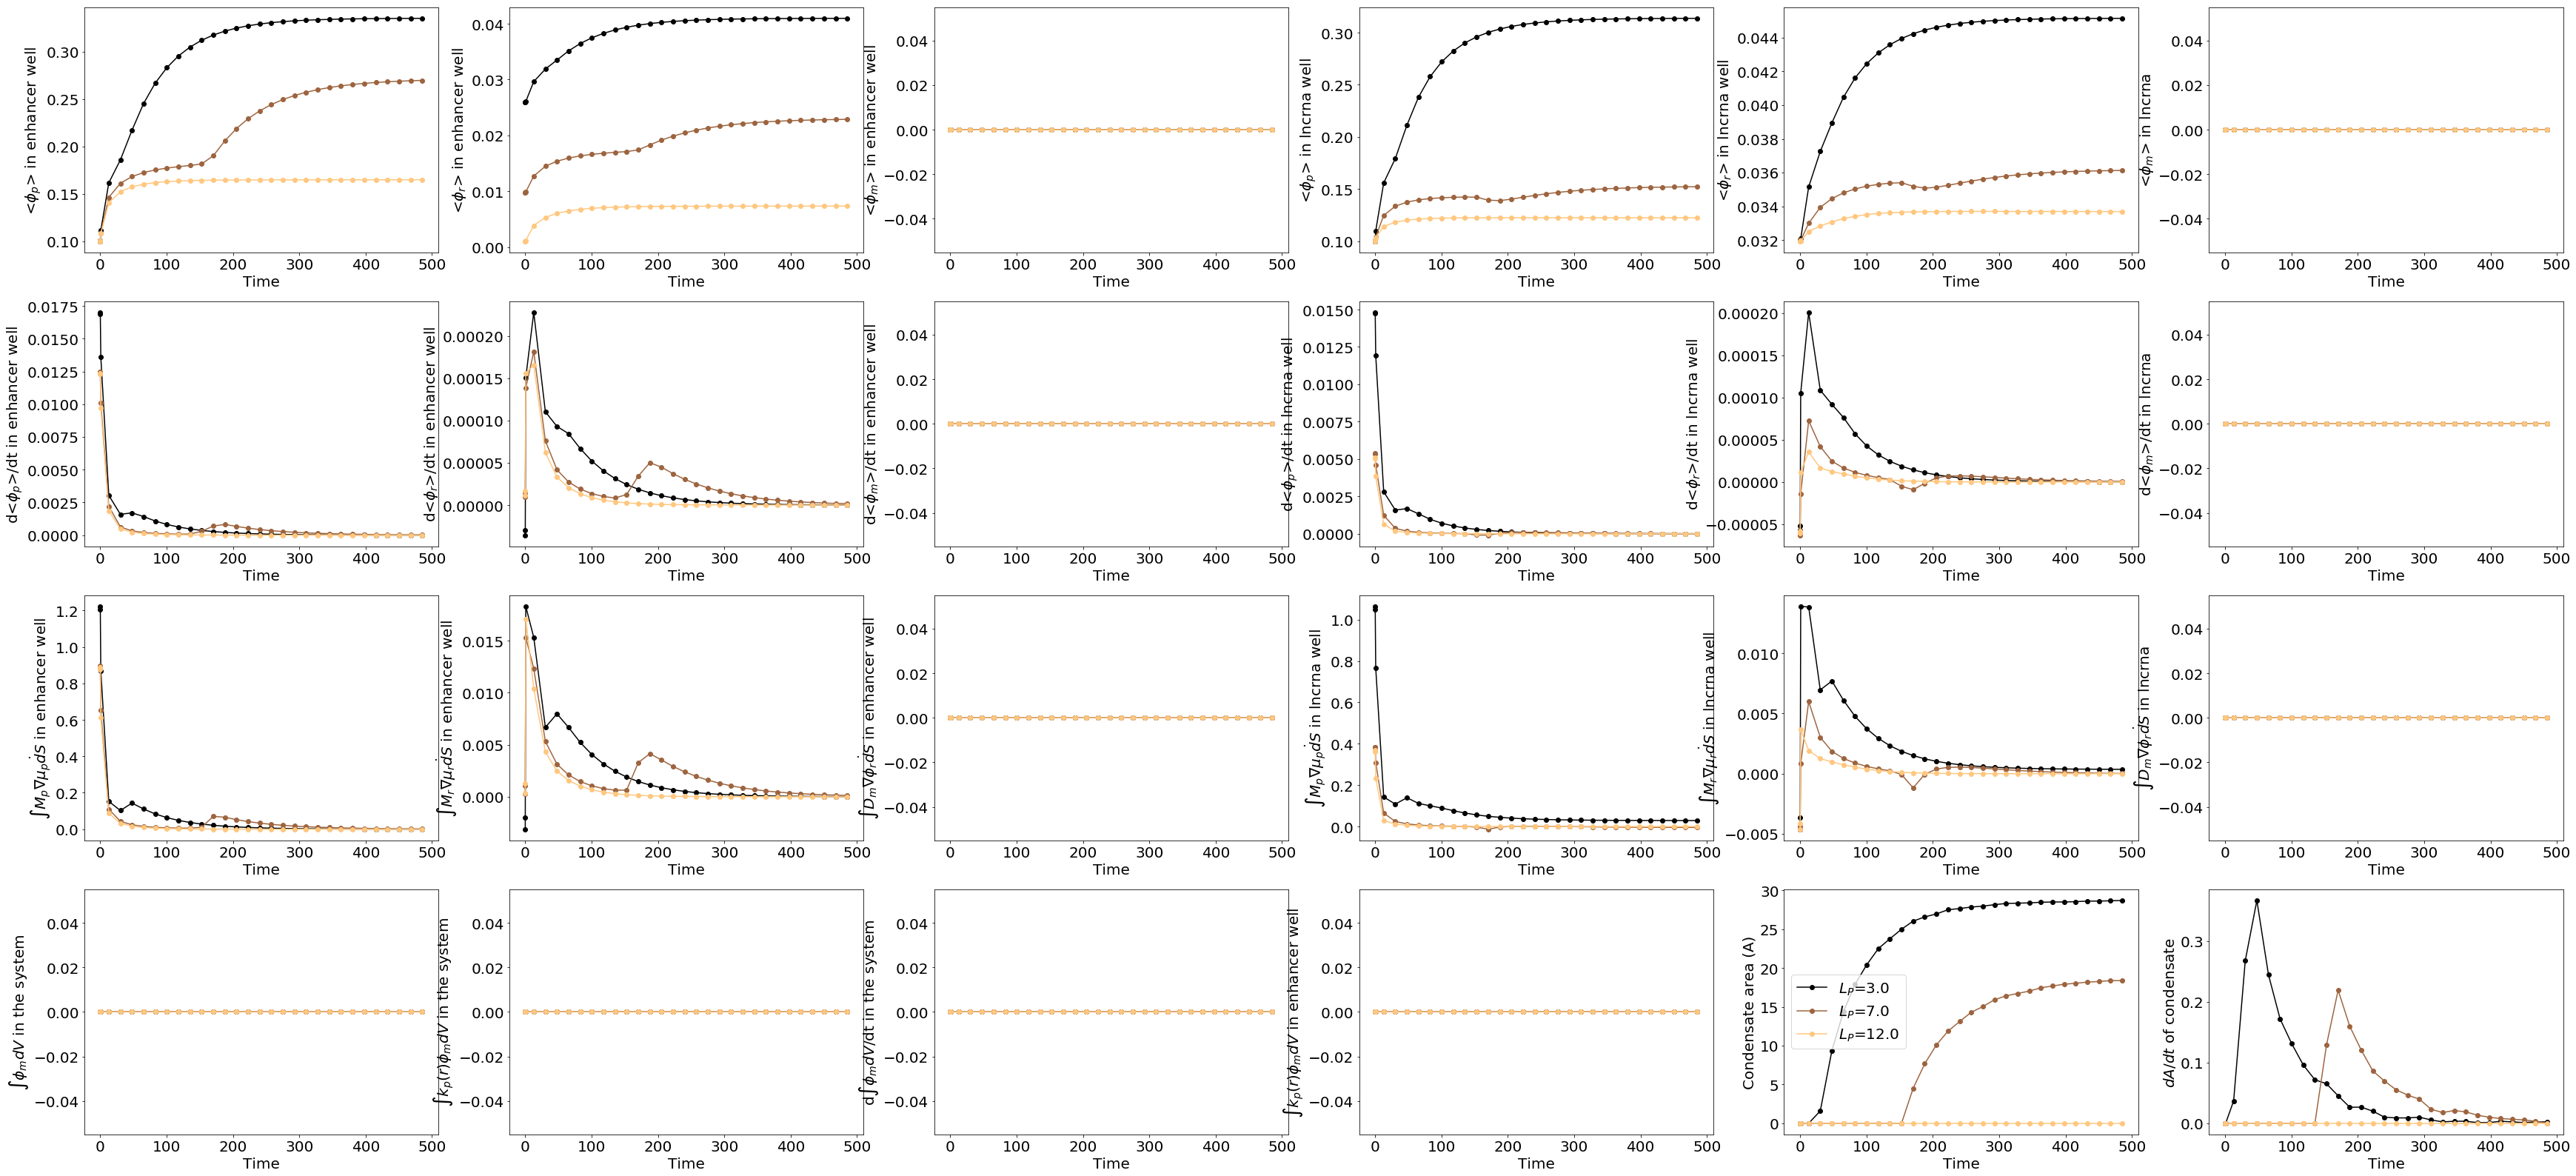

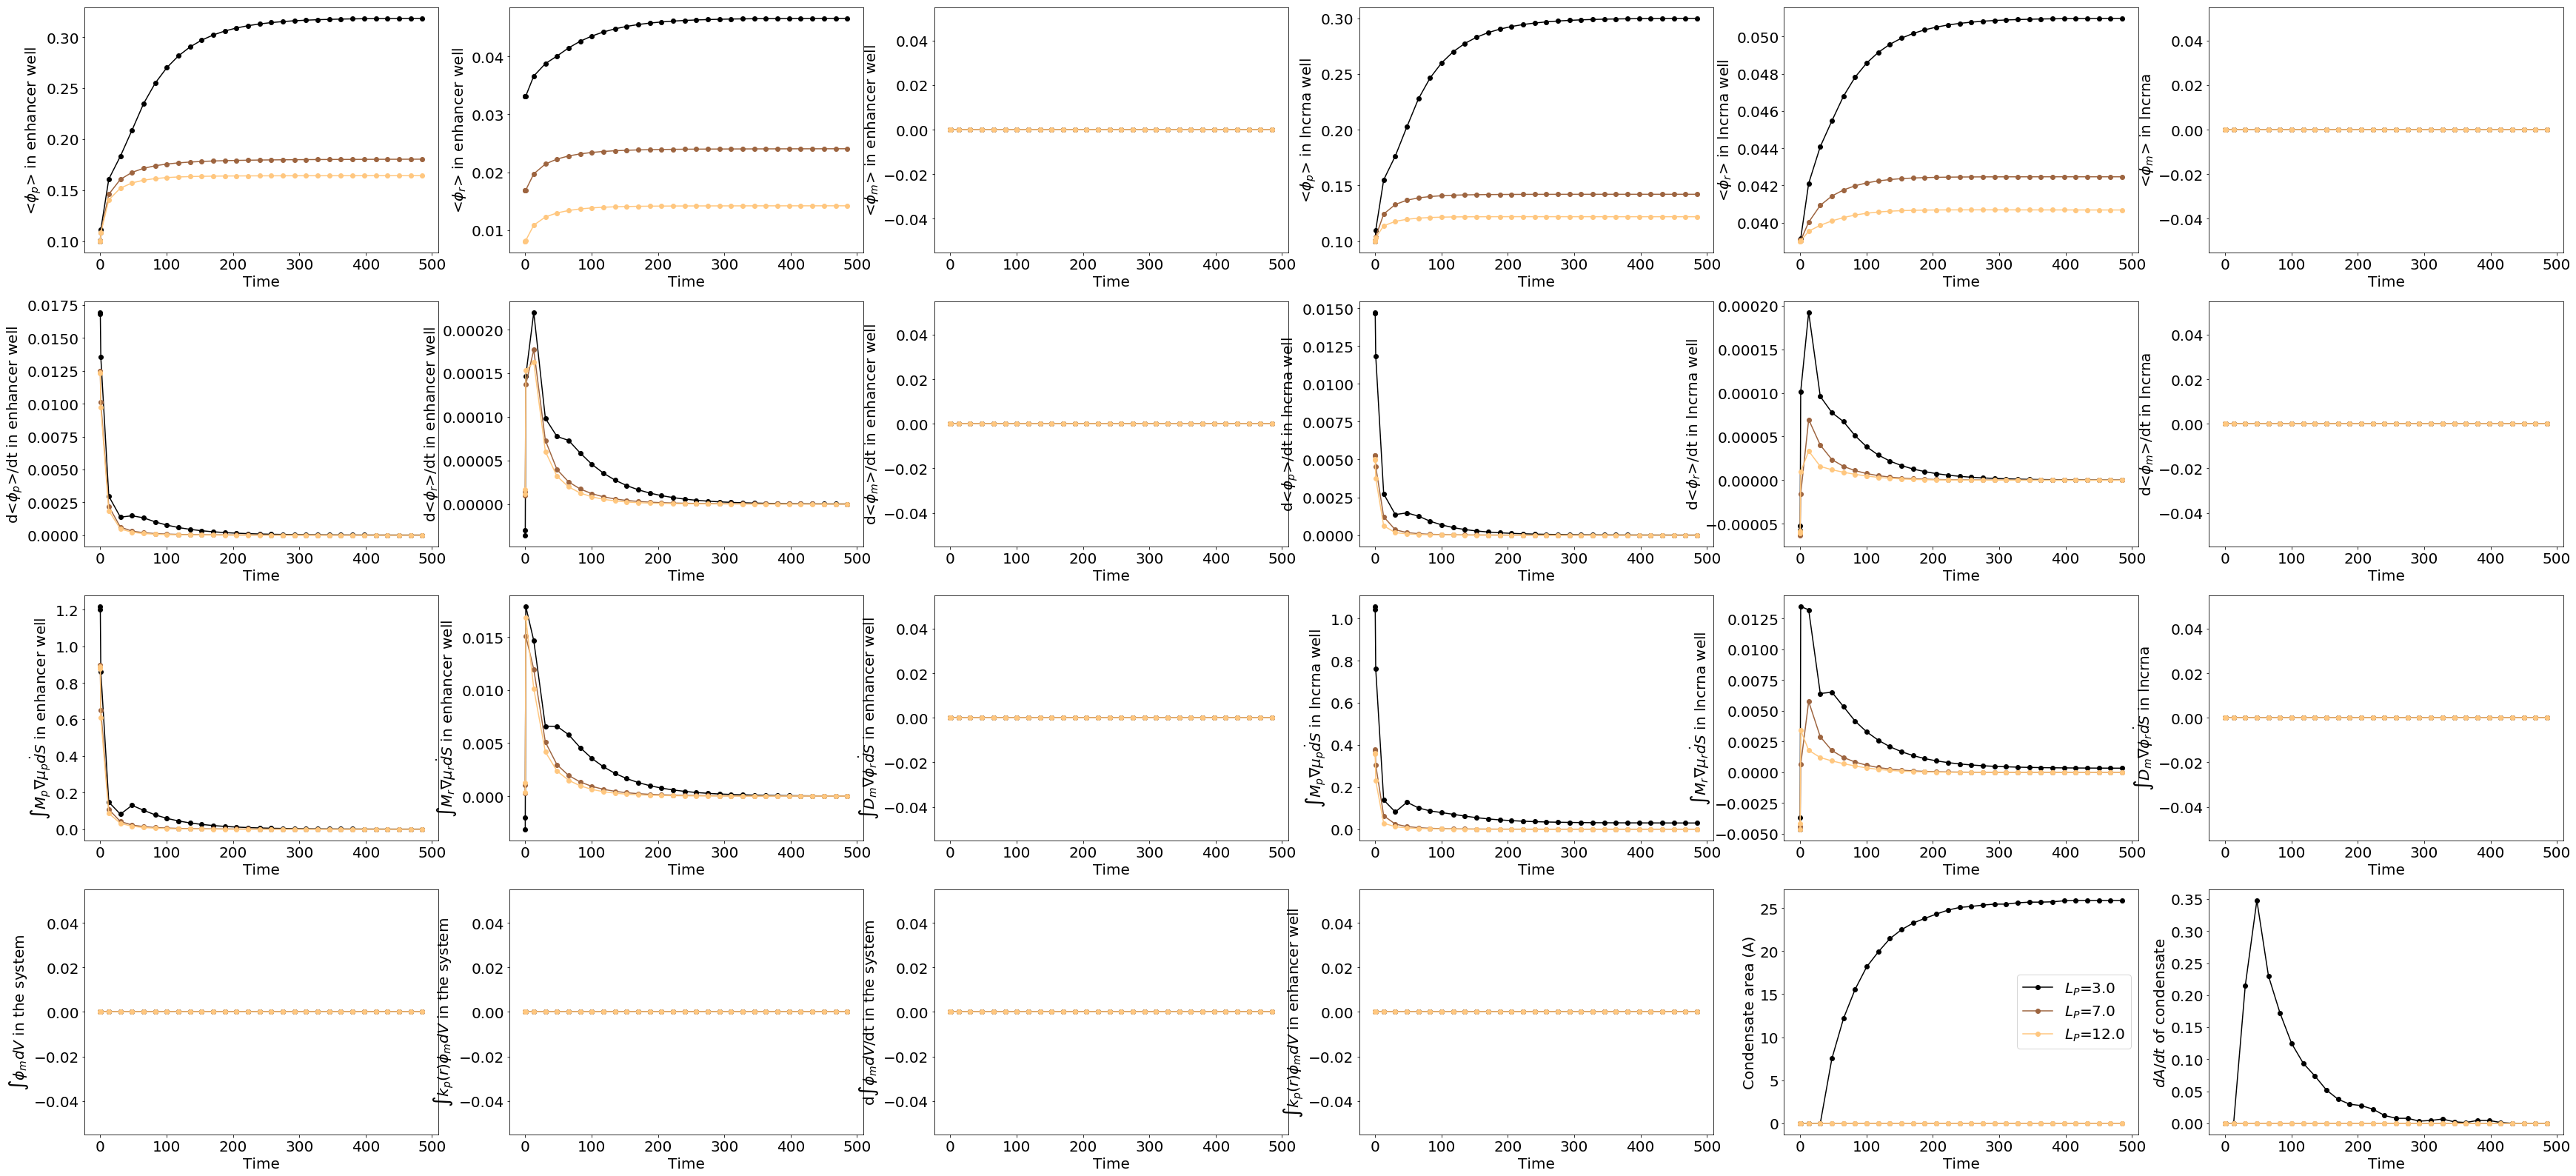

In [20]:
analysis_obj = LncrnaDataAnalysis()
analysis_obj.plot_dynamical_variables_vary_LP(save_directory='20210907-LOCALIZED_LNCRNA_NO_MRNA_PRODUCTION/', 
                                              save_filename='lncrna_no_activity_K_{kp}_phir_{phi_r}_dynamical_trajectories.svg', 
                                              activity_and_lncrna_directory='/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/',                                
                                              activity_and_lncrna_pattern='.*phi_r_{phi_r}.*L_P_{L_P}_K_{kp}$',
                                              kp_list=[1.0], L_P_list=[3.0,7.0,12.0], phi_r_list=[5.0,25.0])        


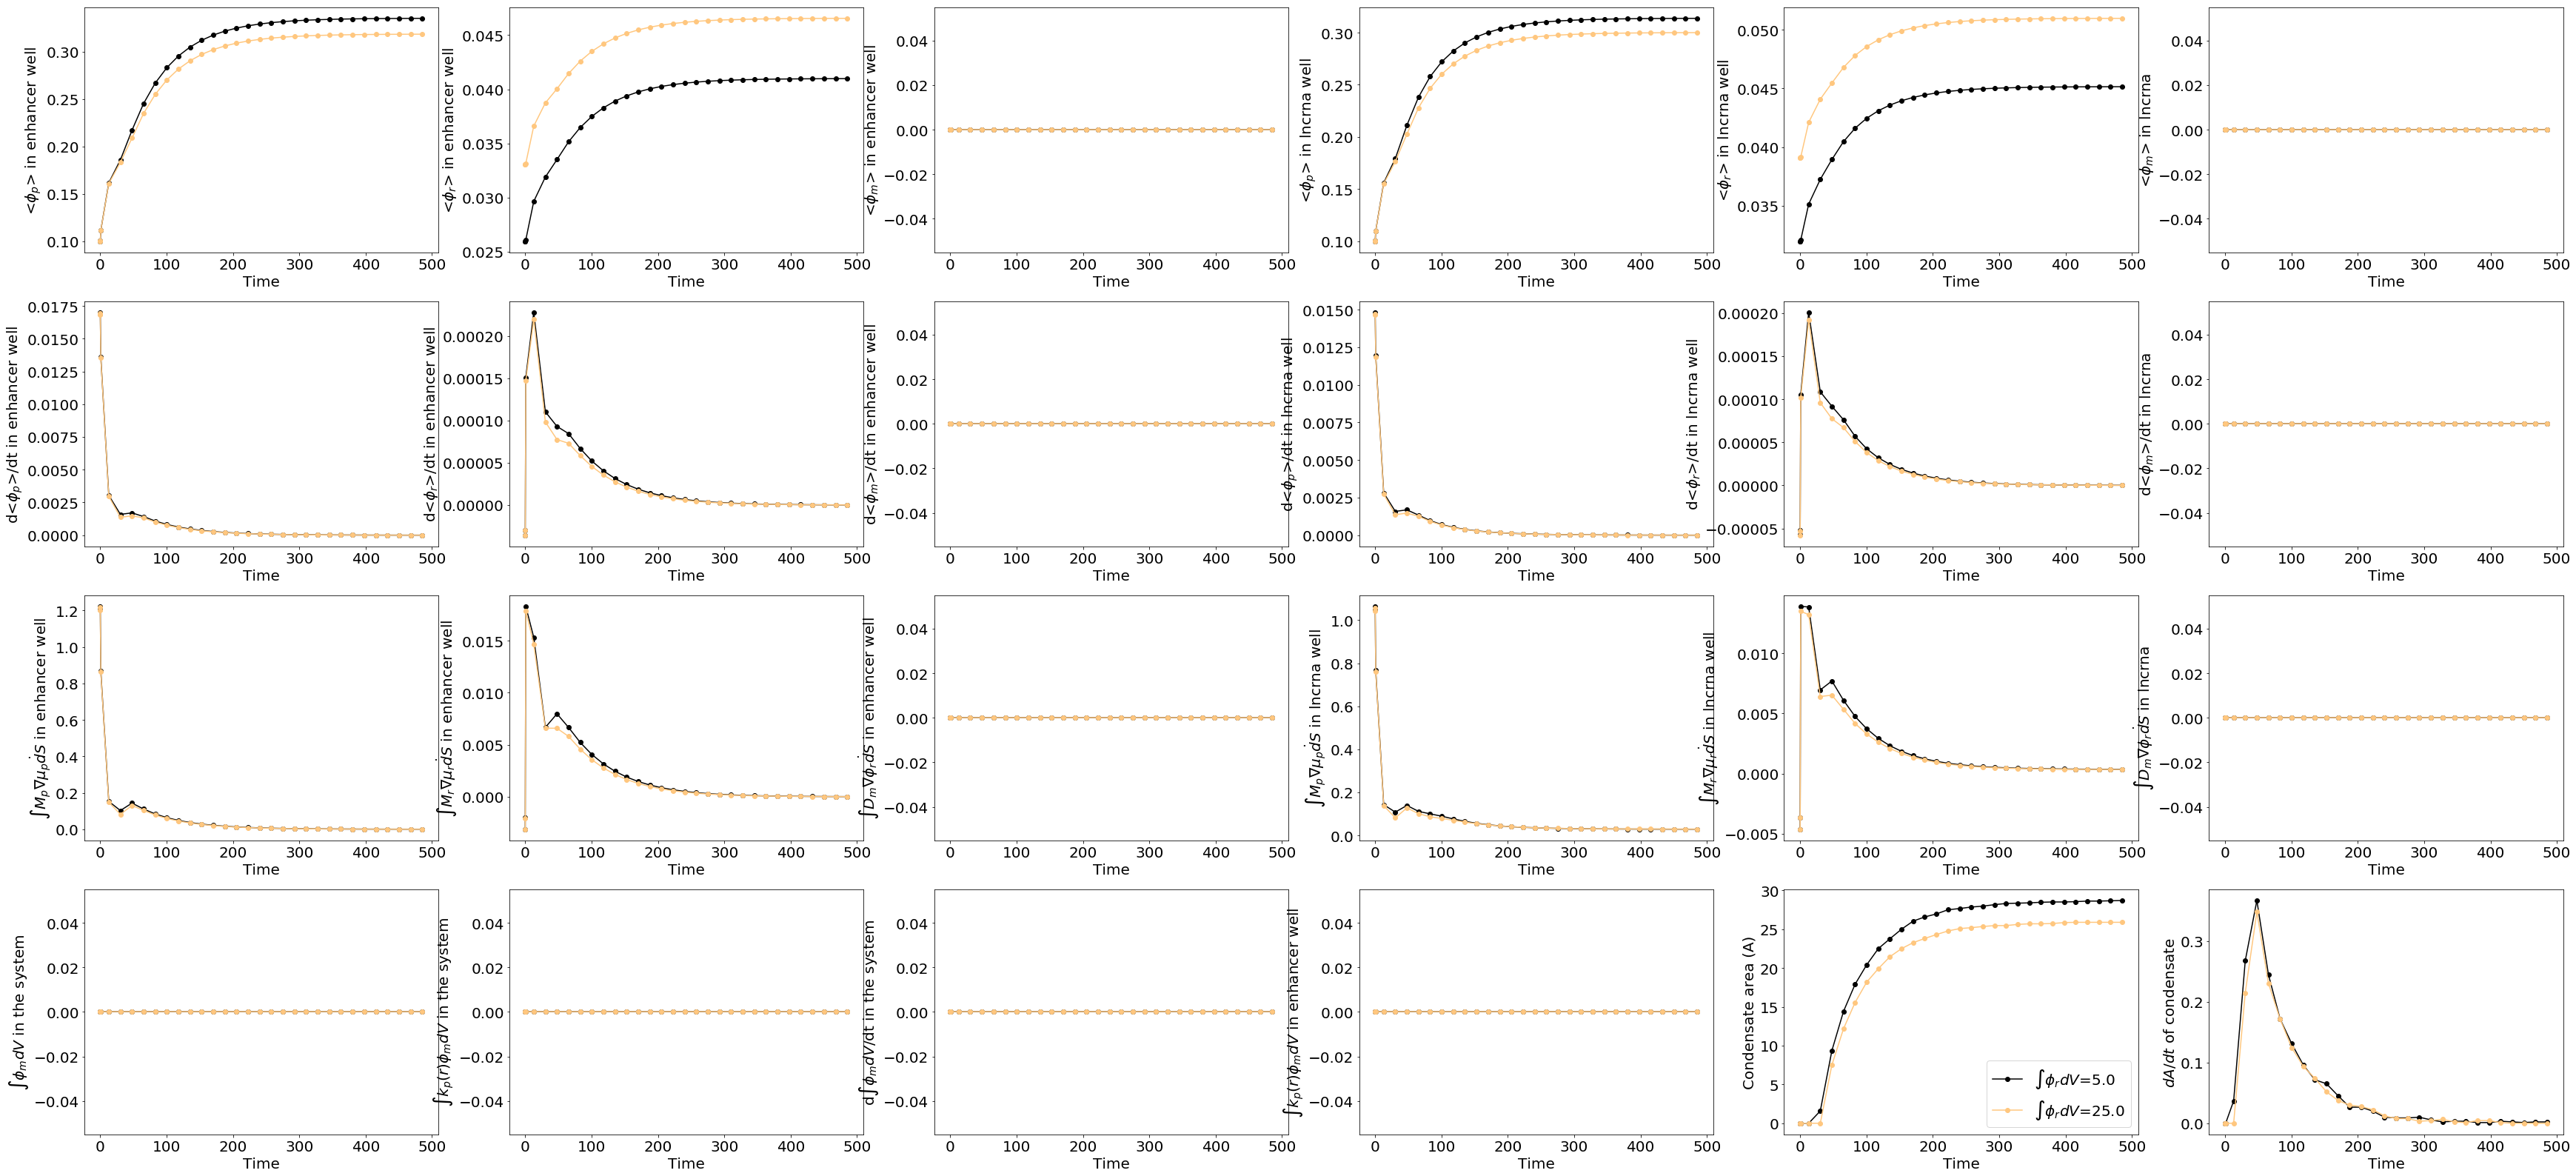

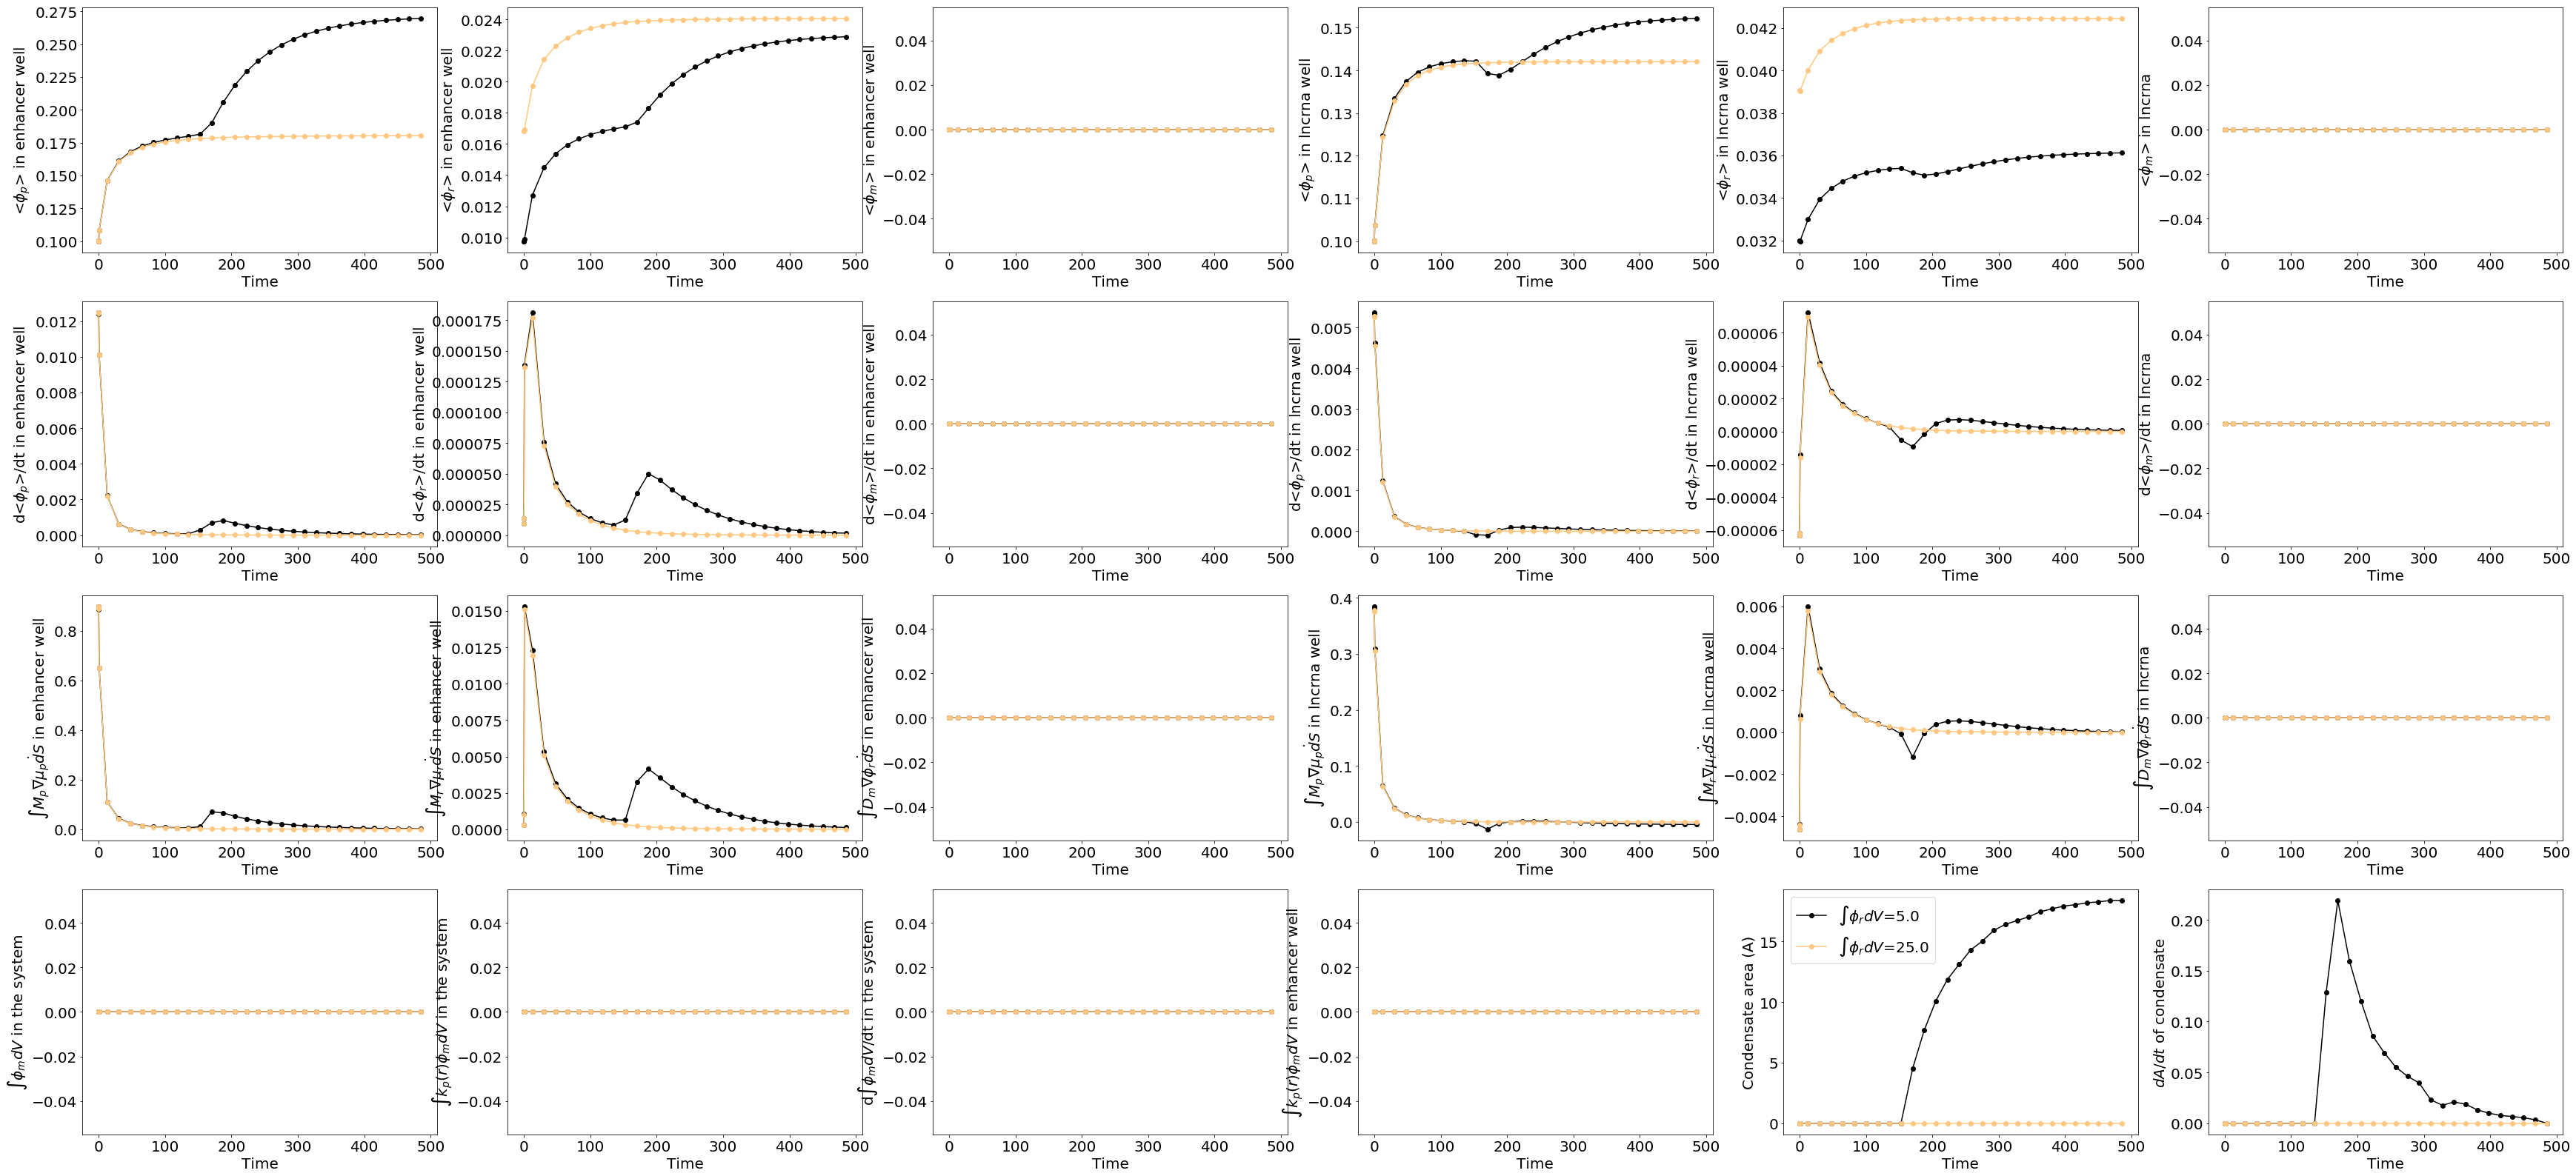

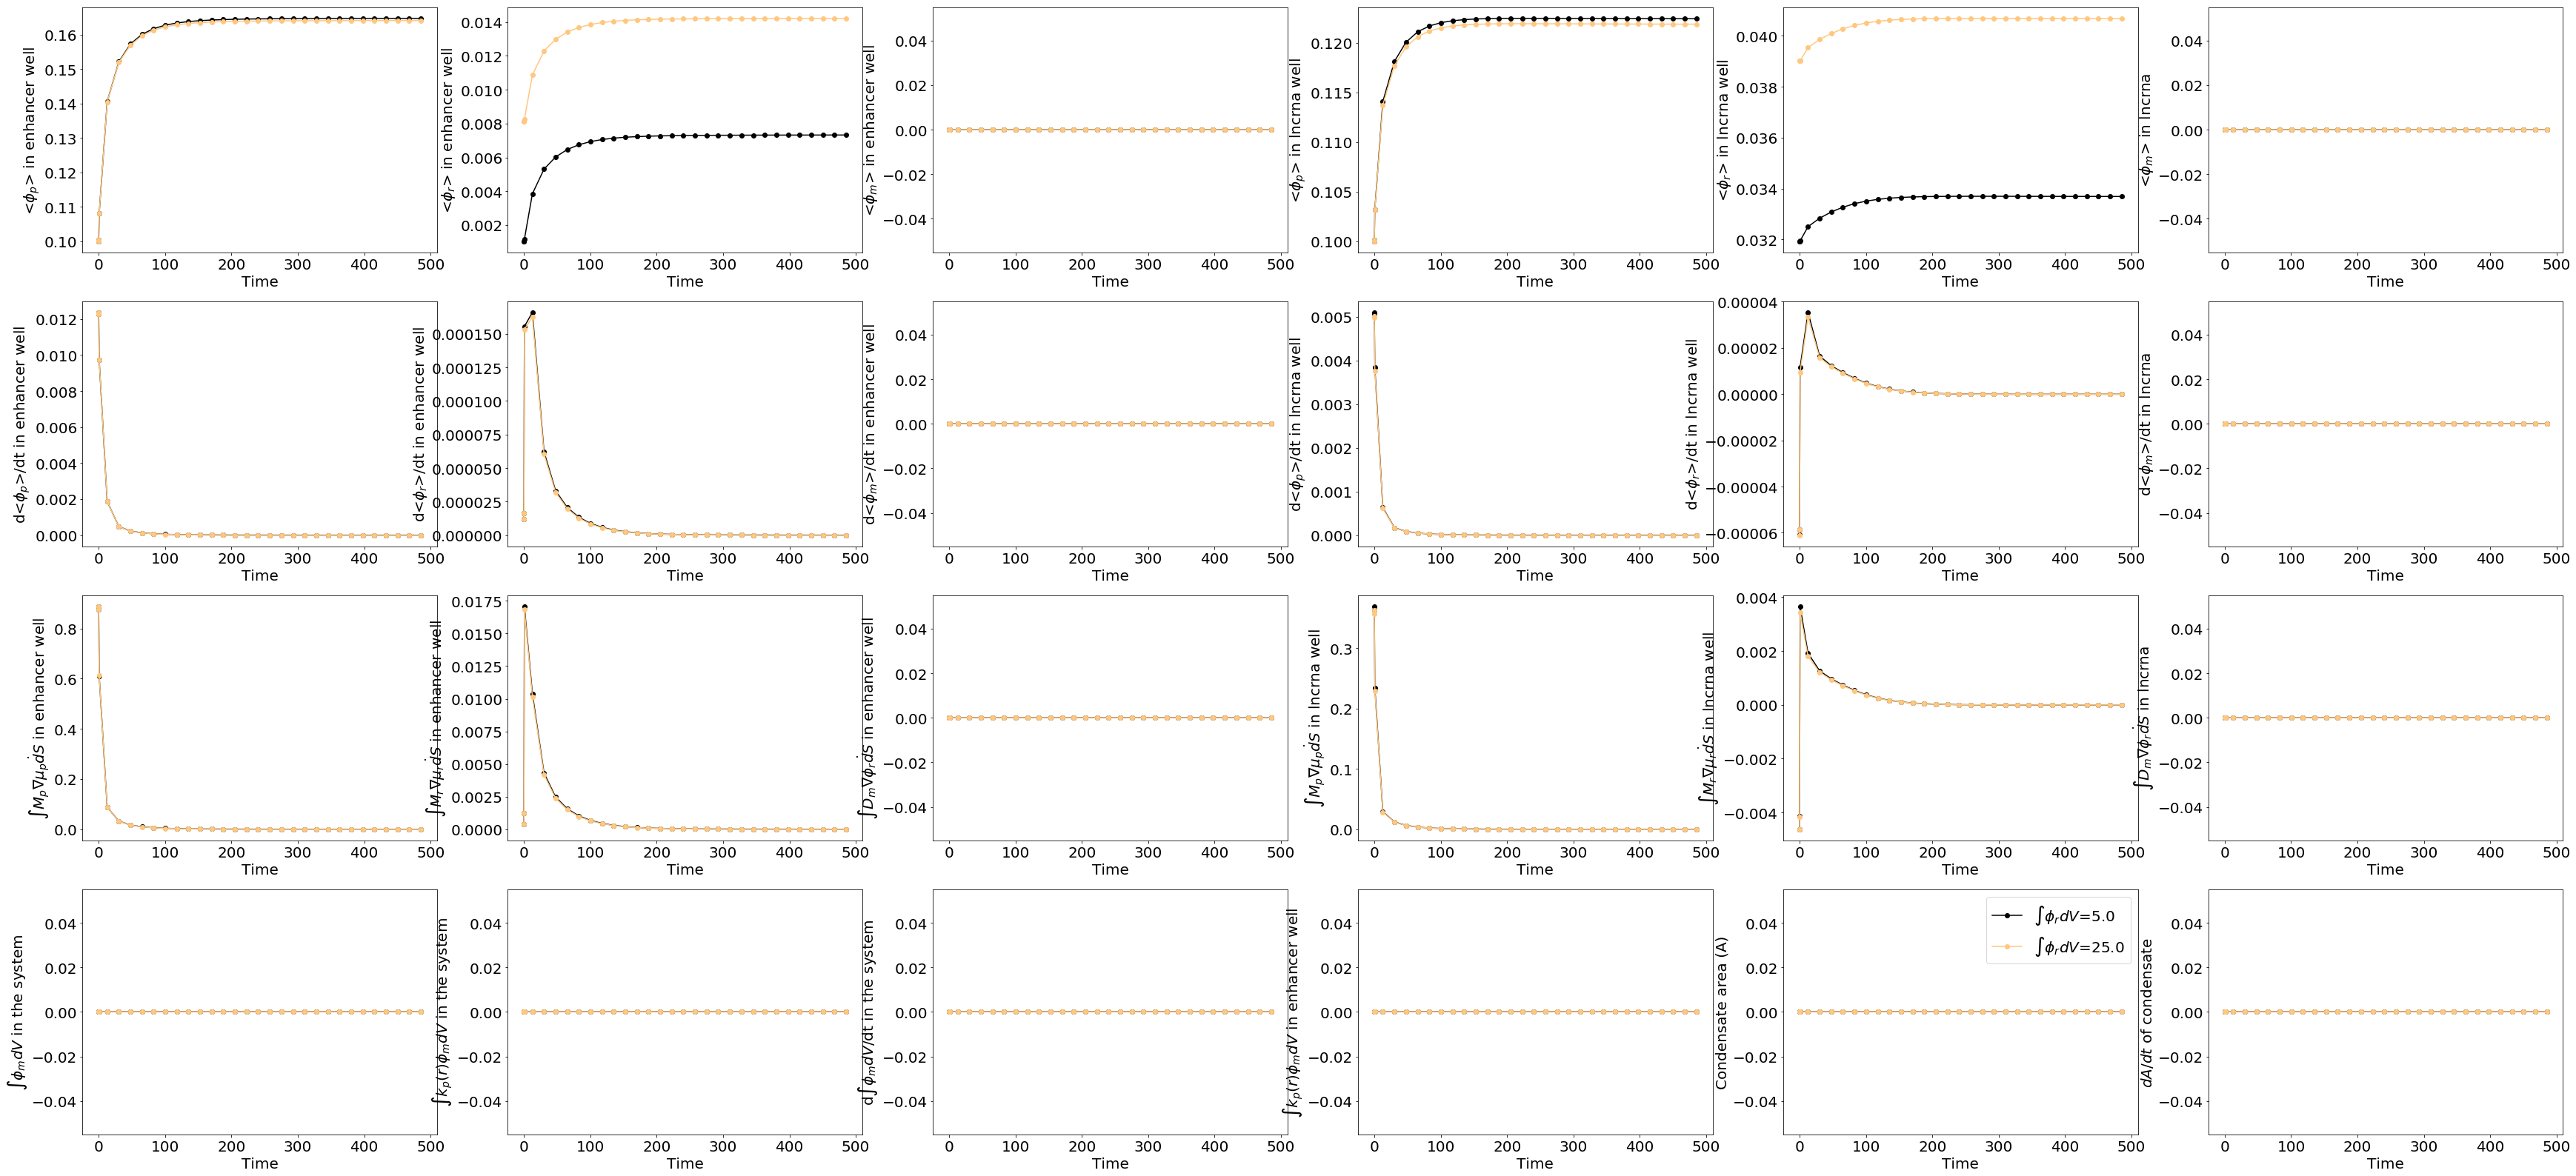

In [21]:
analysis_obj = LncrnaDataAnalysis()
analysis_obj.plot_dynamical_variables_vary_phi_r(save_directory='20210907-LOCALIZED_LNCRNA_NO_MRNA_PRODUCTION/', 
                                              save_filename='lncrna_no_activity_linear_K_{kp}_L_P_{L_P}_dynamical_trajectories.svg', 
                                              activity_and_lncrna_directory='/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/', 
                                              activity_and_lncrna_pattern='.*phi_r_{phi_r}.*L_P_{L_P}_K_{kp}$',
                                              kp_list=[1.0], L_P_list=[3.0,7.0,12.0], phi_r_list=[5.0,25.0])               


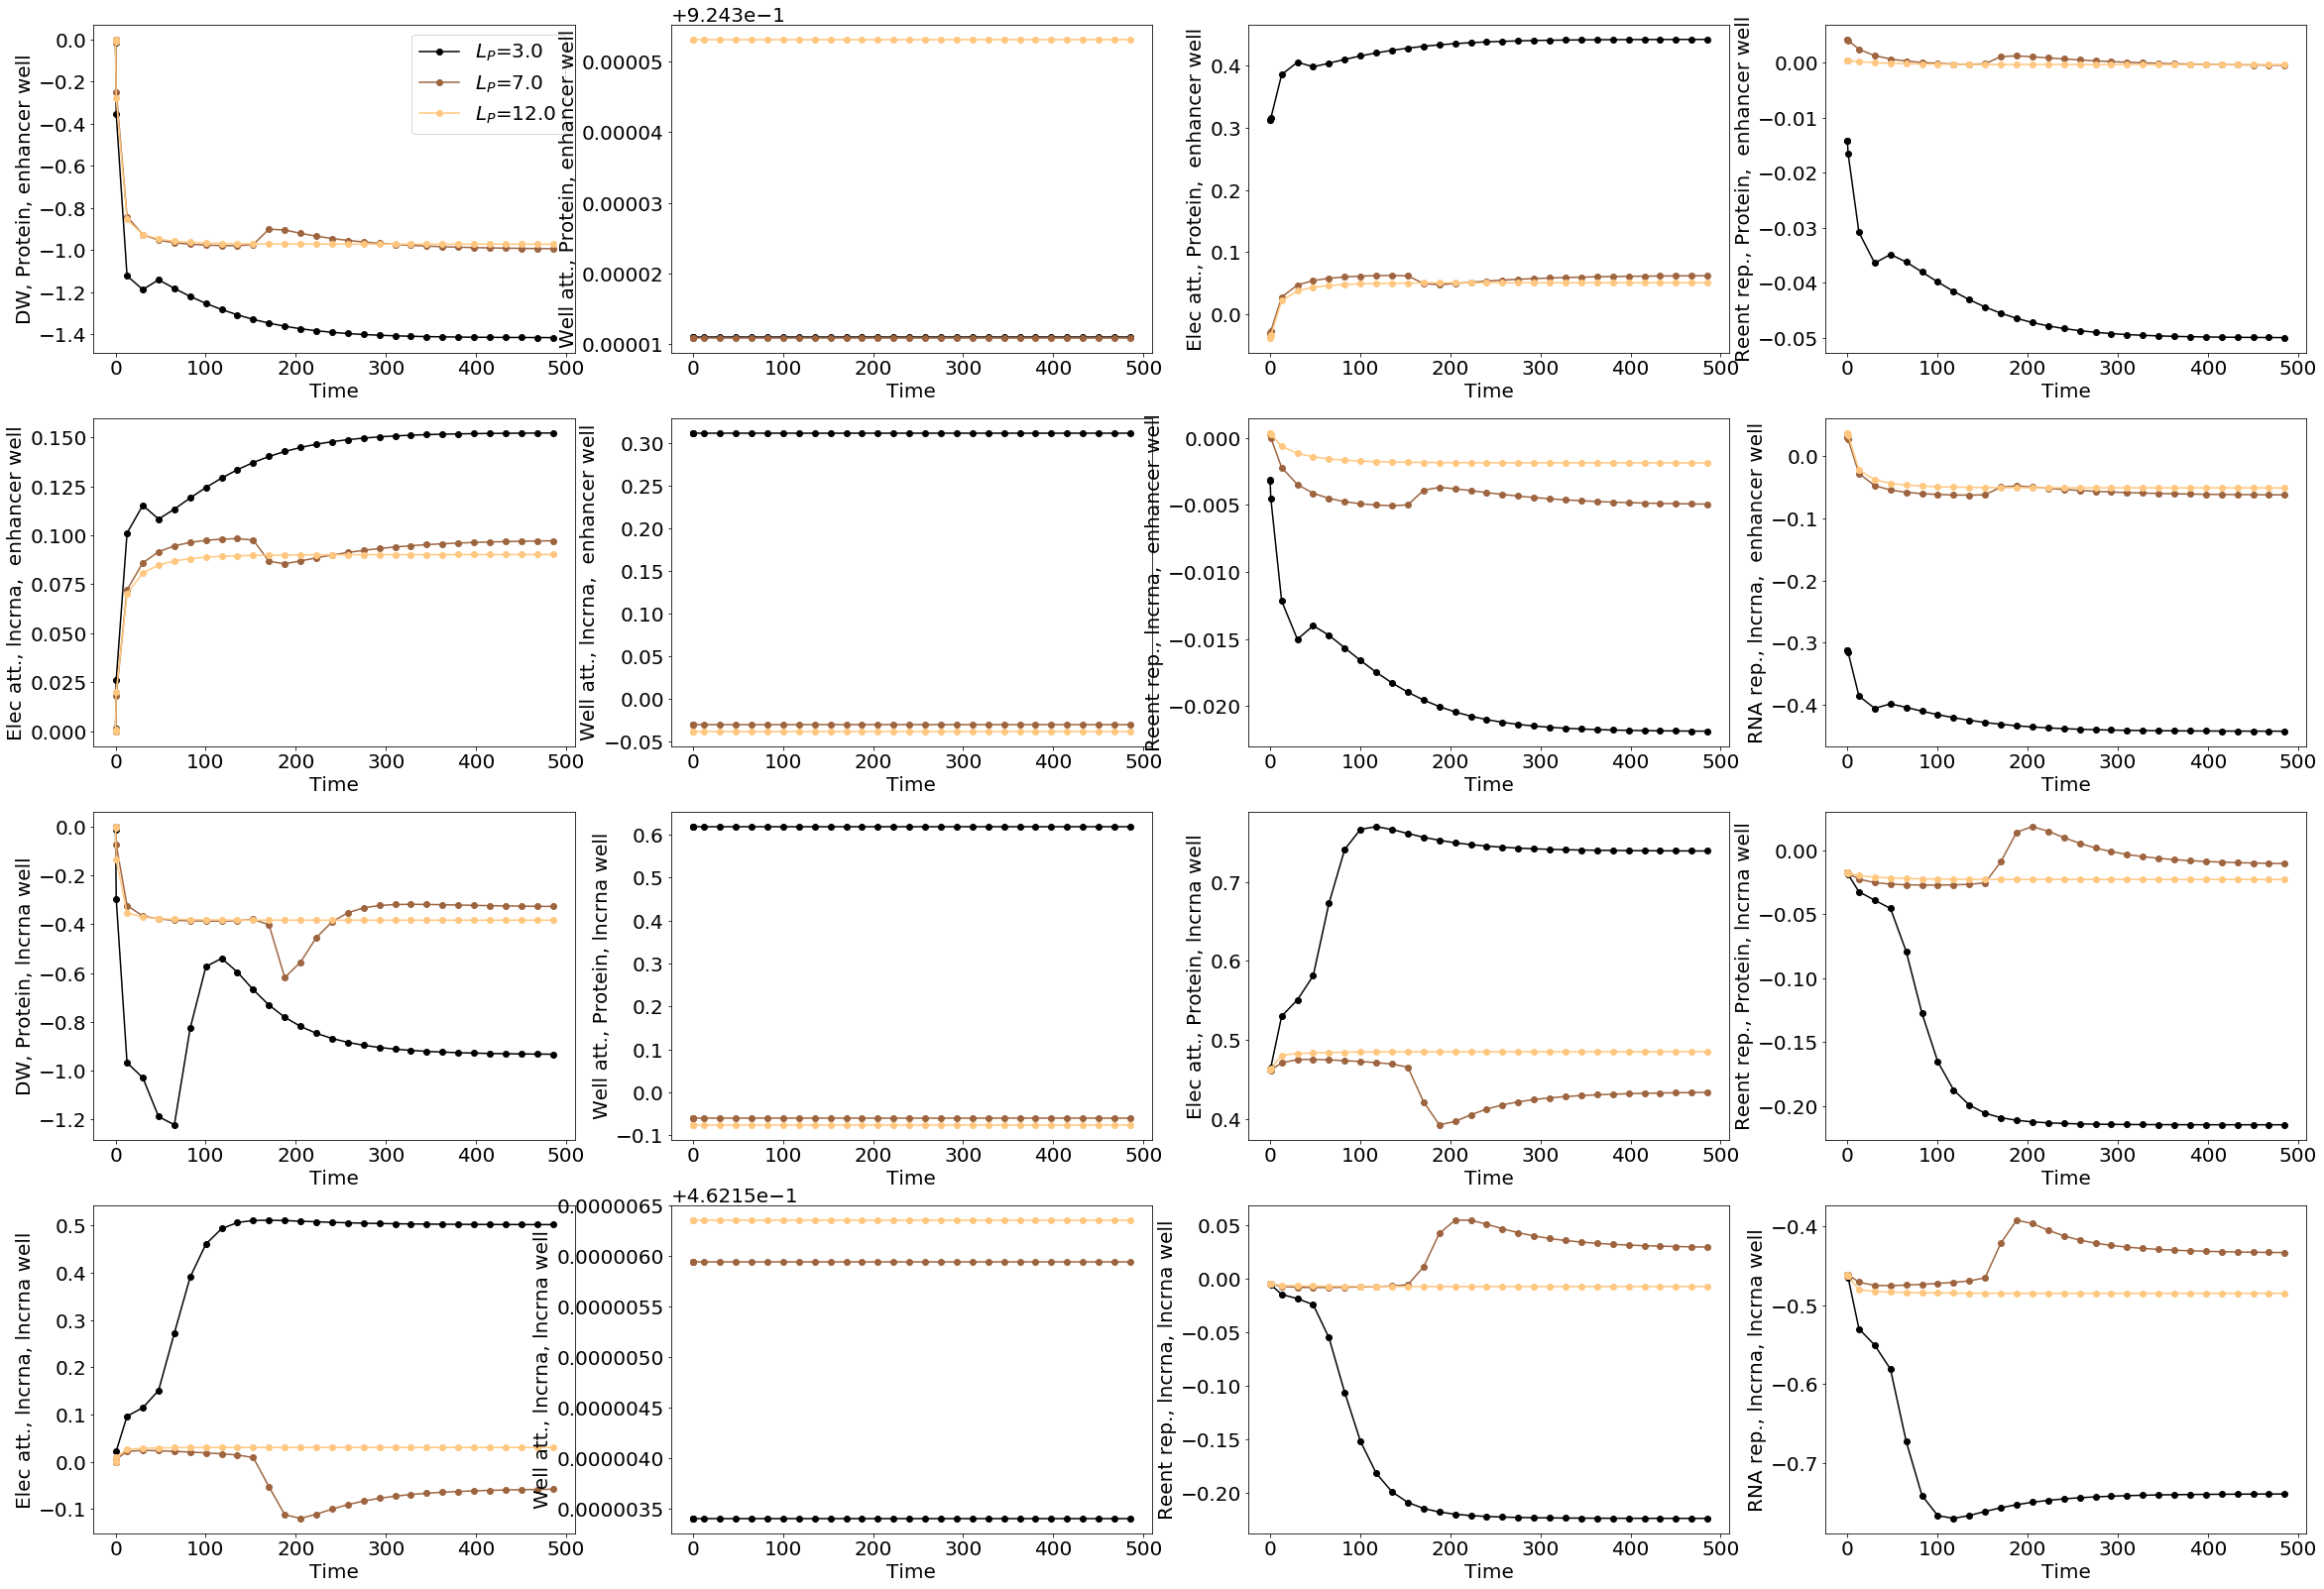

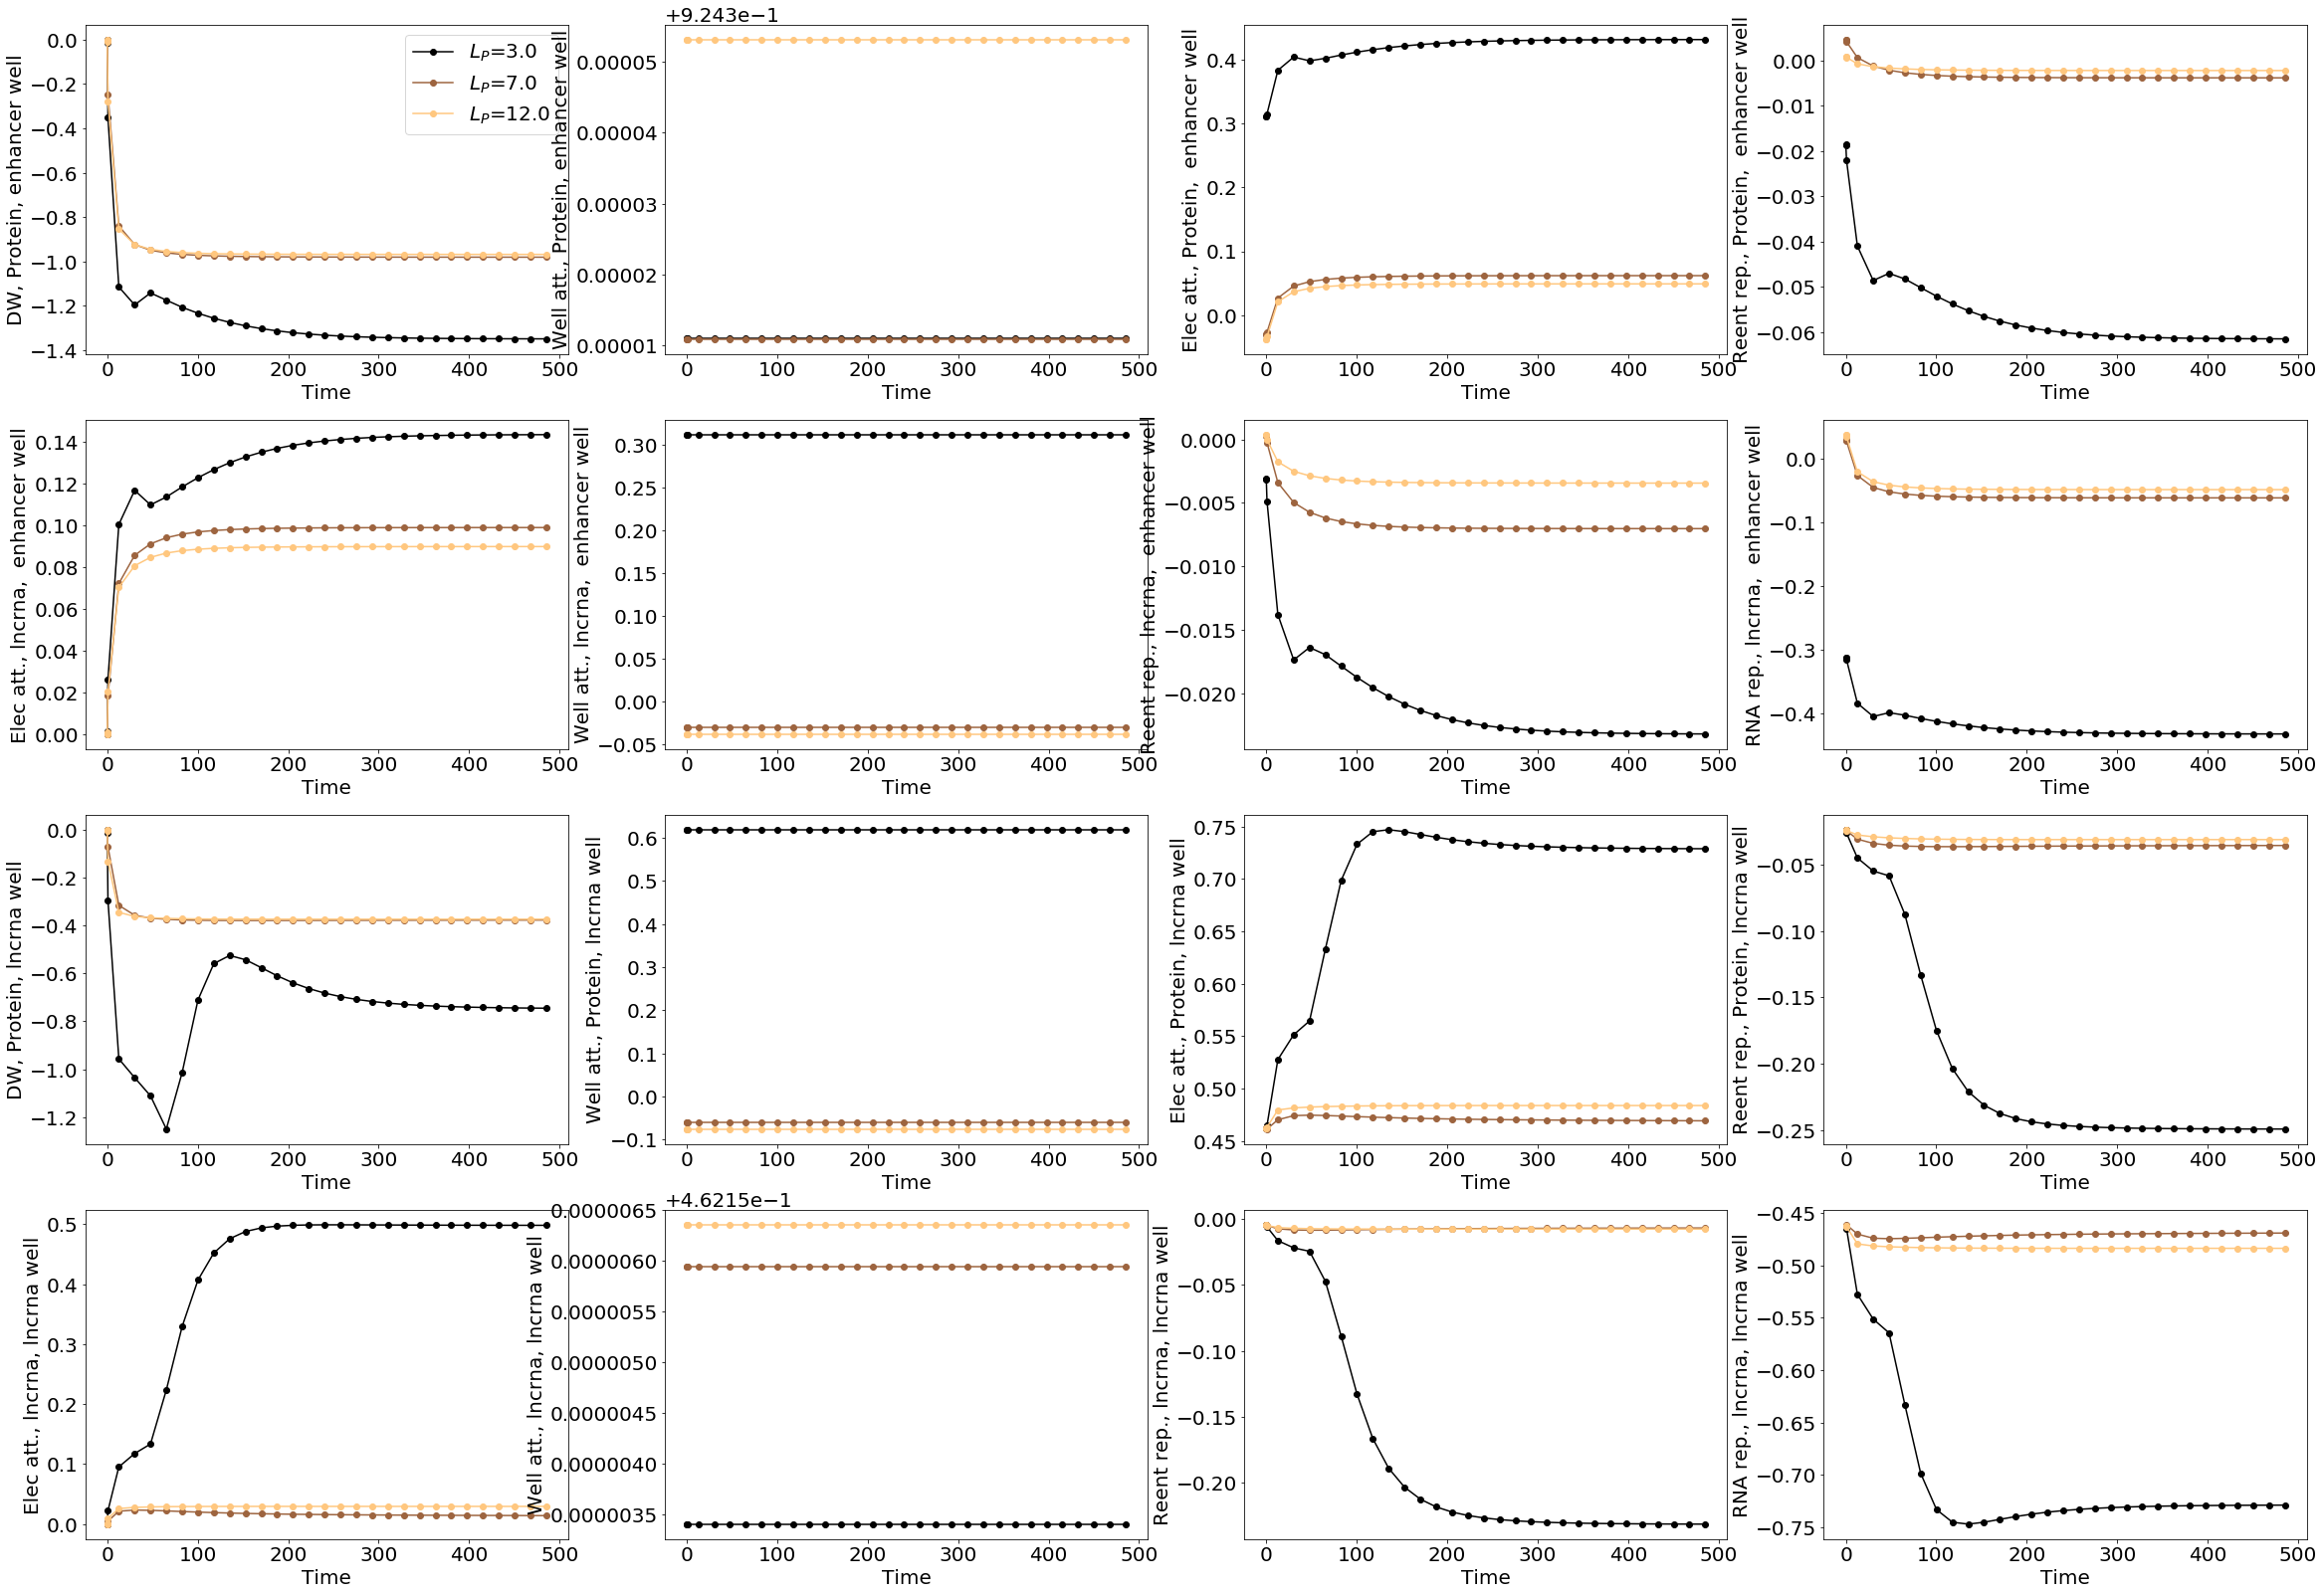

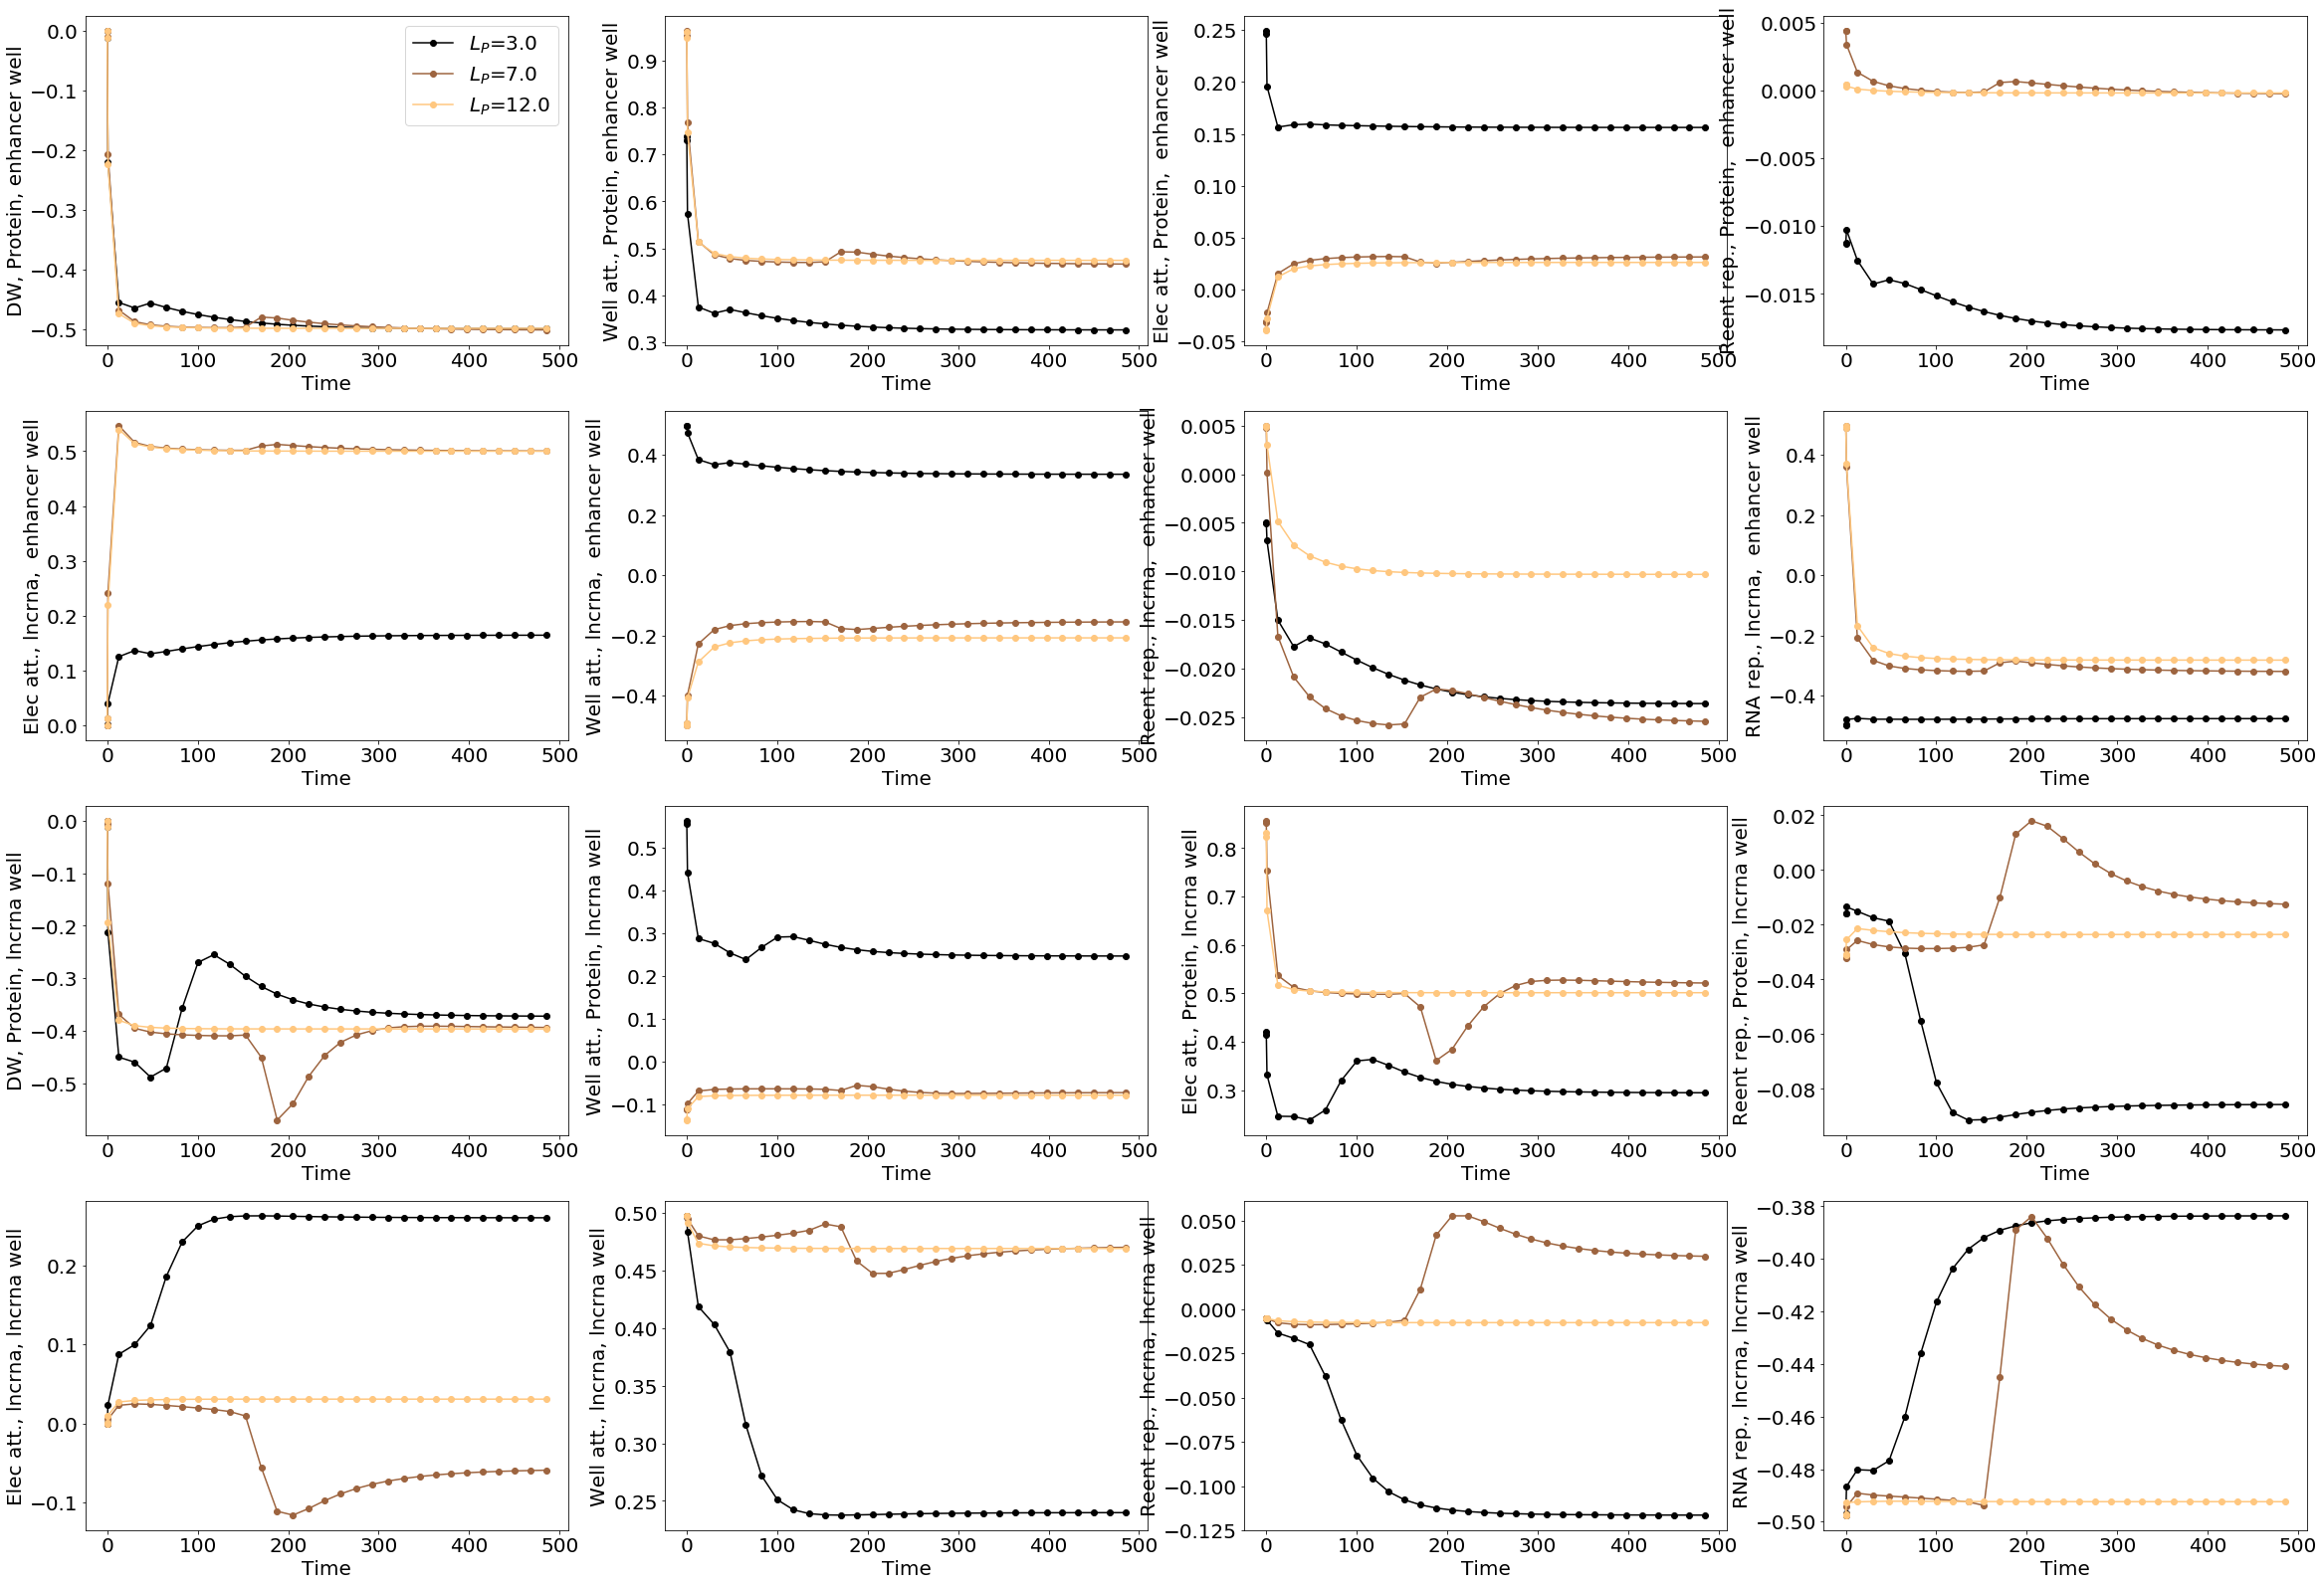

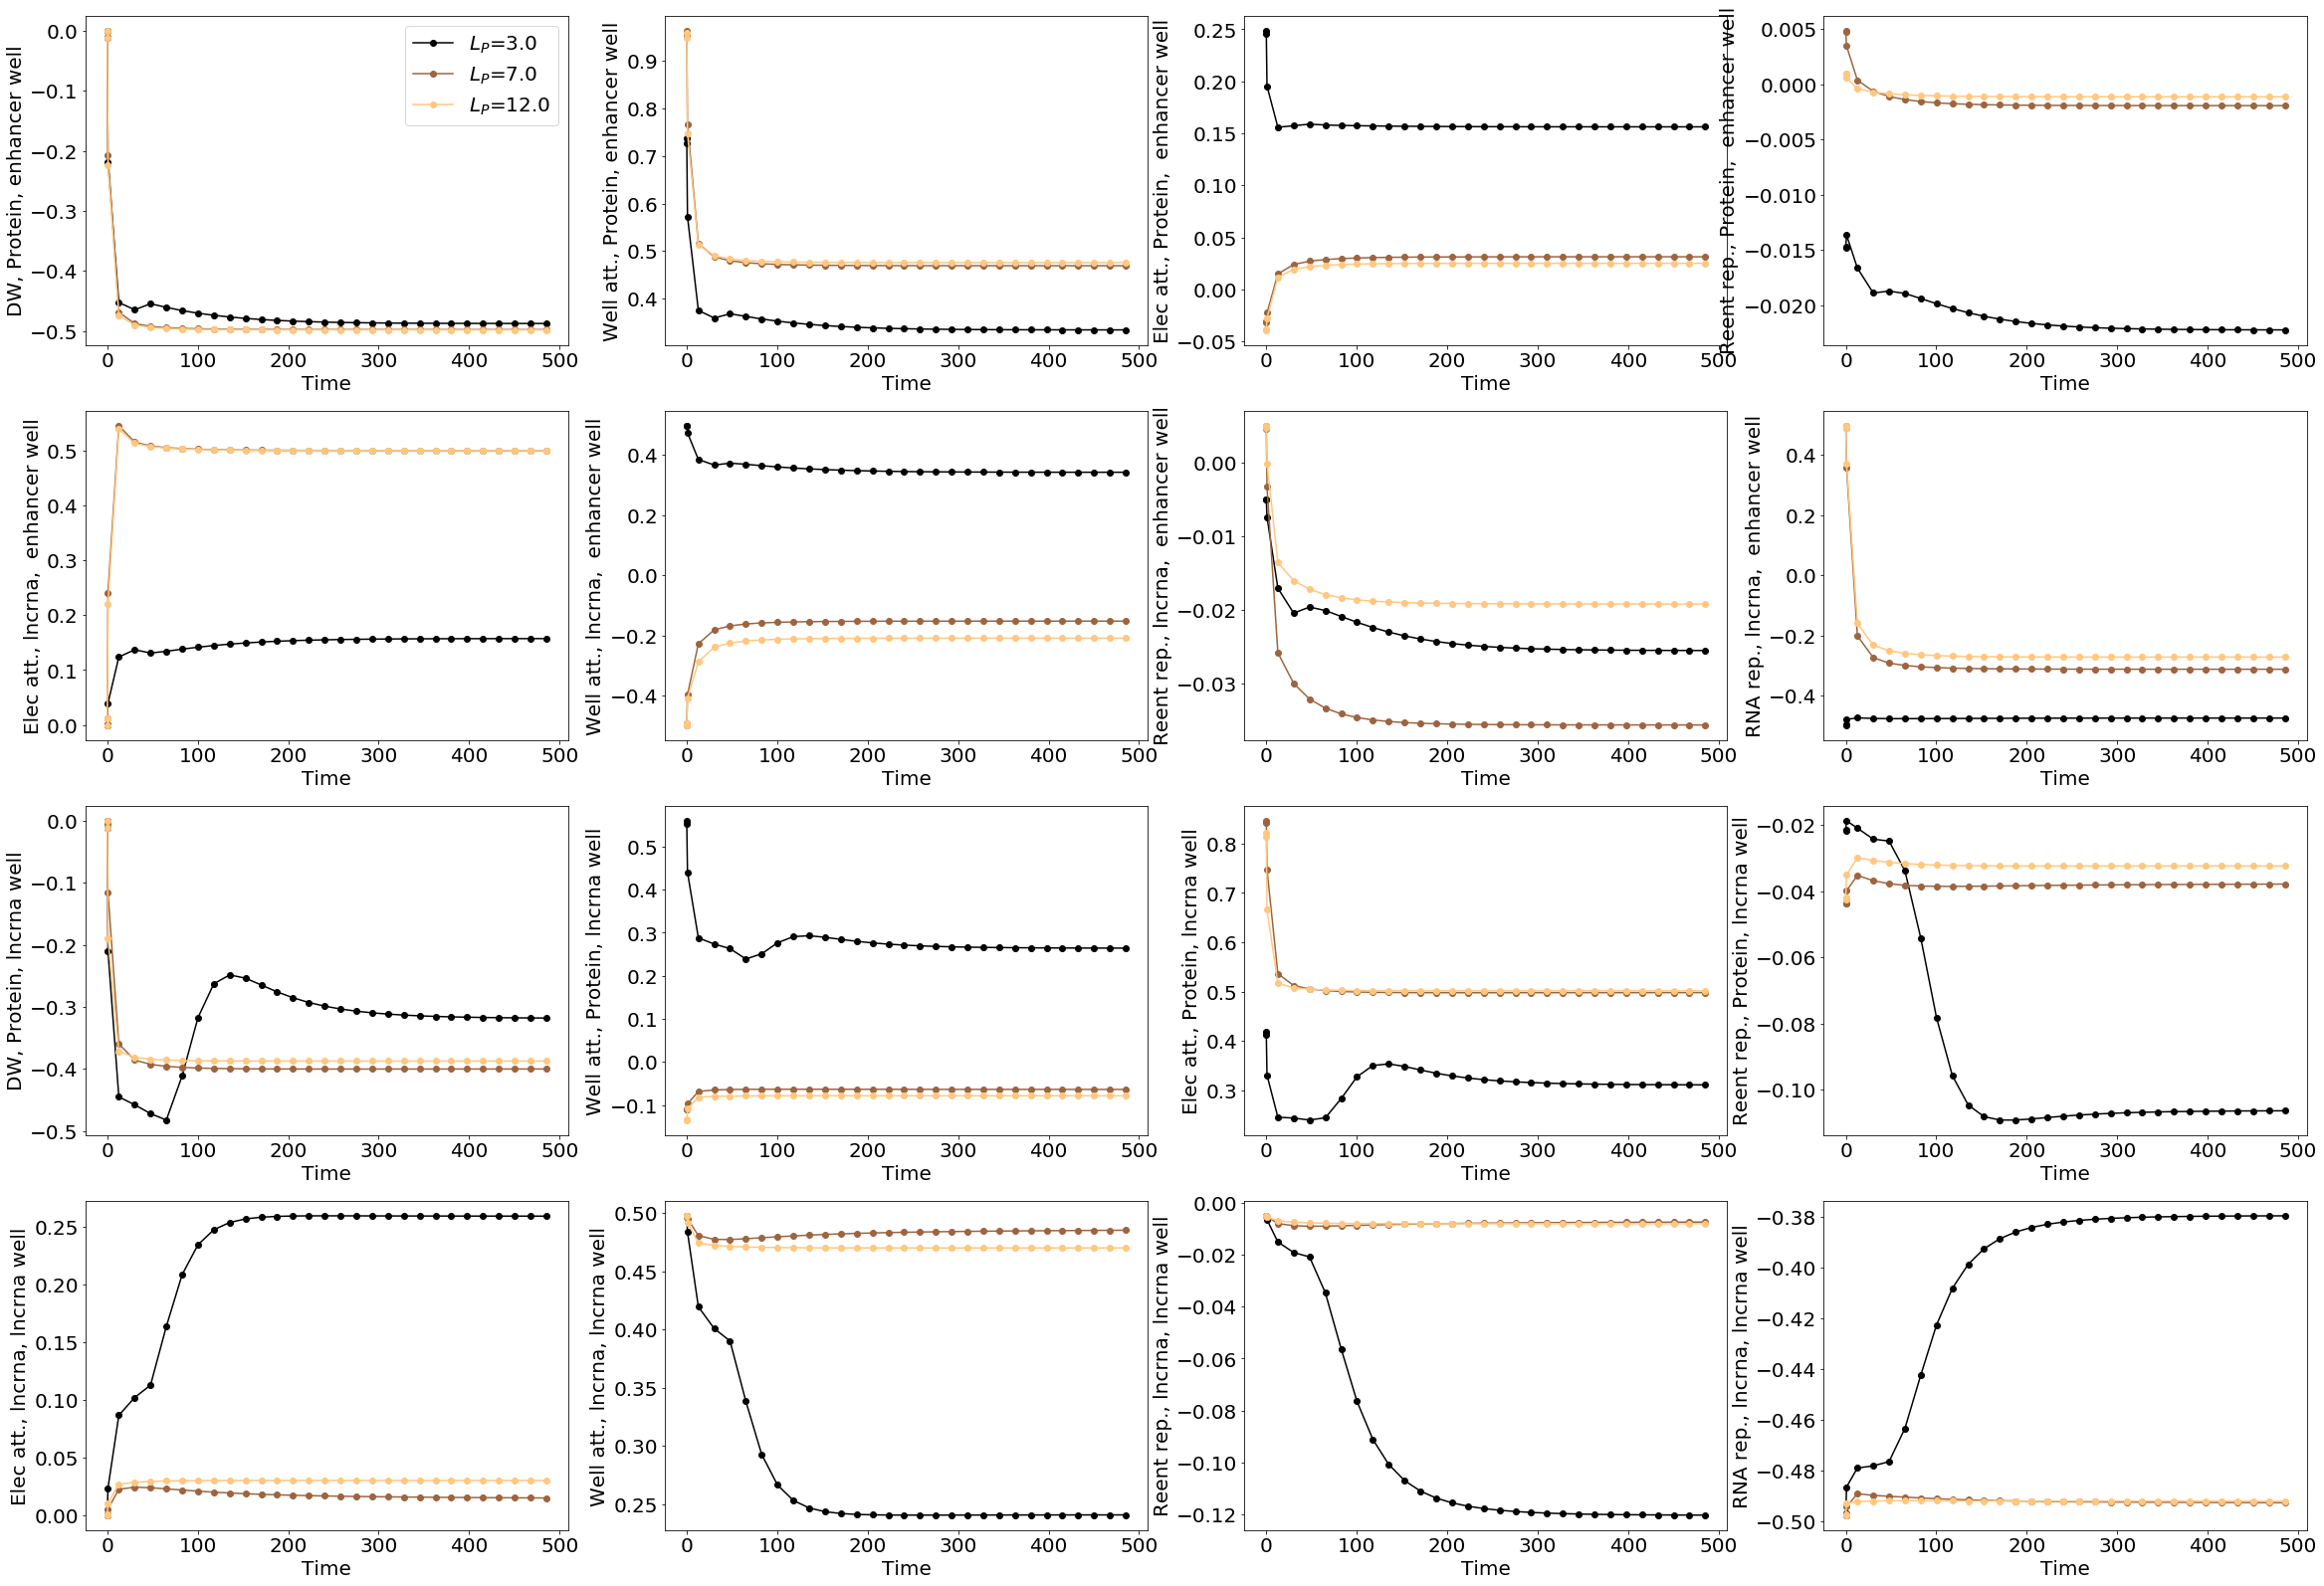

In [22]:
analysis_obj = LncrnaDataAnalysis()
analysis_obj.plot_flux_contributions_vary_LP(save_directory='20210907-LOCALIZED_LNCRNA_NO_MRNA_PRODUCTION/', 
                                              save_filename='lncrna_no_activity_K_{kp}_phir_{phi_r}_flux_contributions.svg', 
                                              activity_and_lncrna_directory='/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/',
                                              activity_and_lncrna_pattern='.*phi_r_{phi_r}.*L_P_{L_P}_K_{kp}$',
                                              kp_list=[1.0], L_P_list=[3.0,7.0,12.0], phi_r_list=[5.0,25.0])        


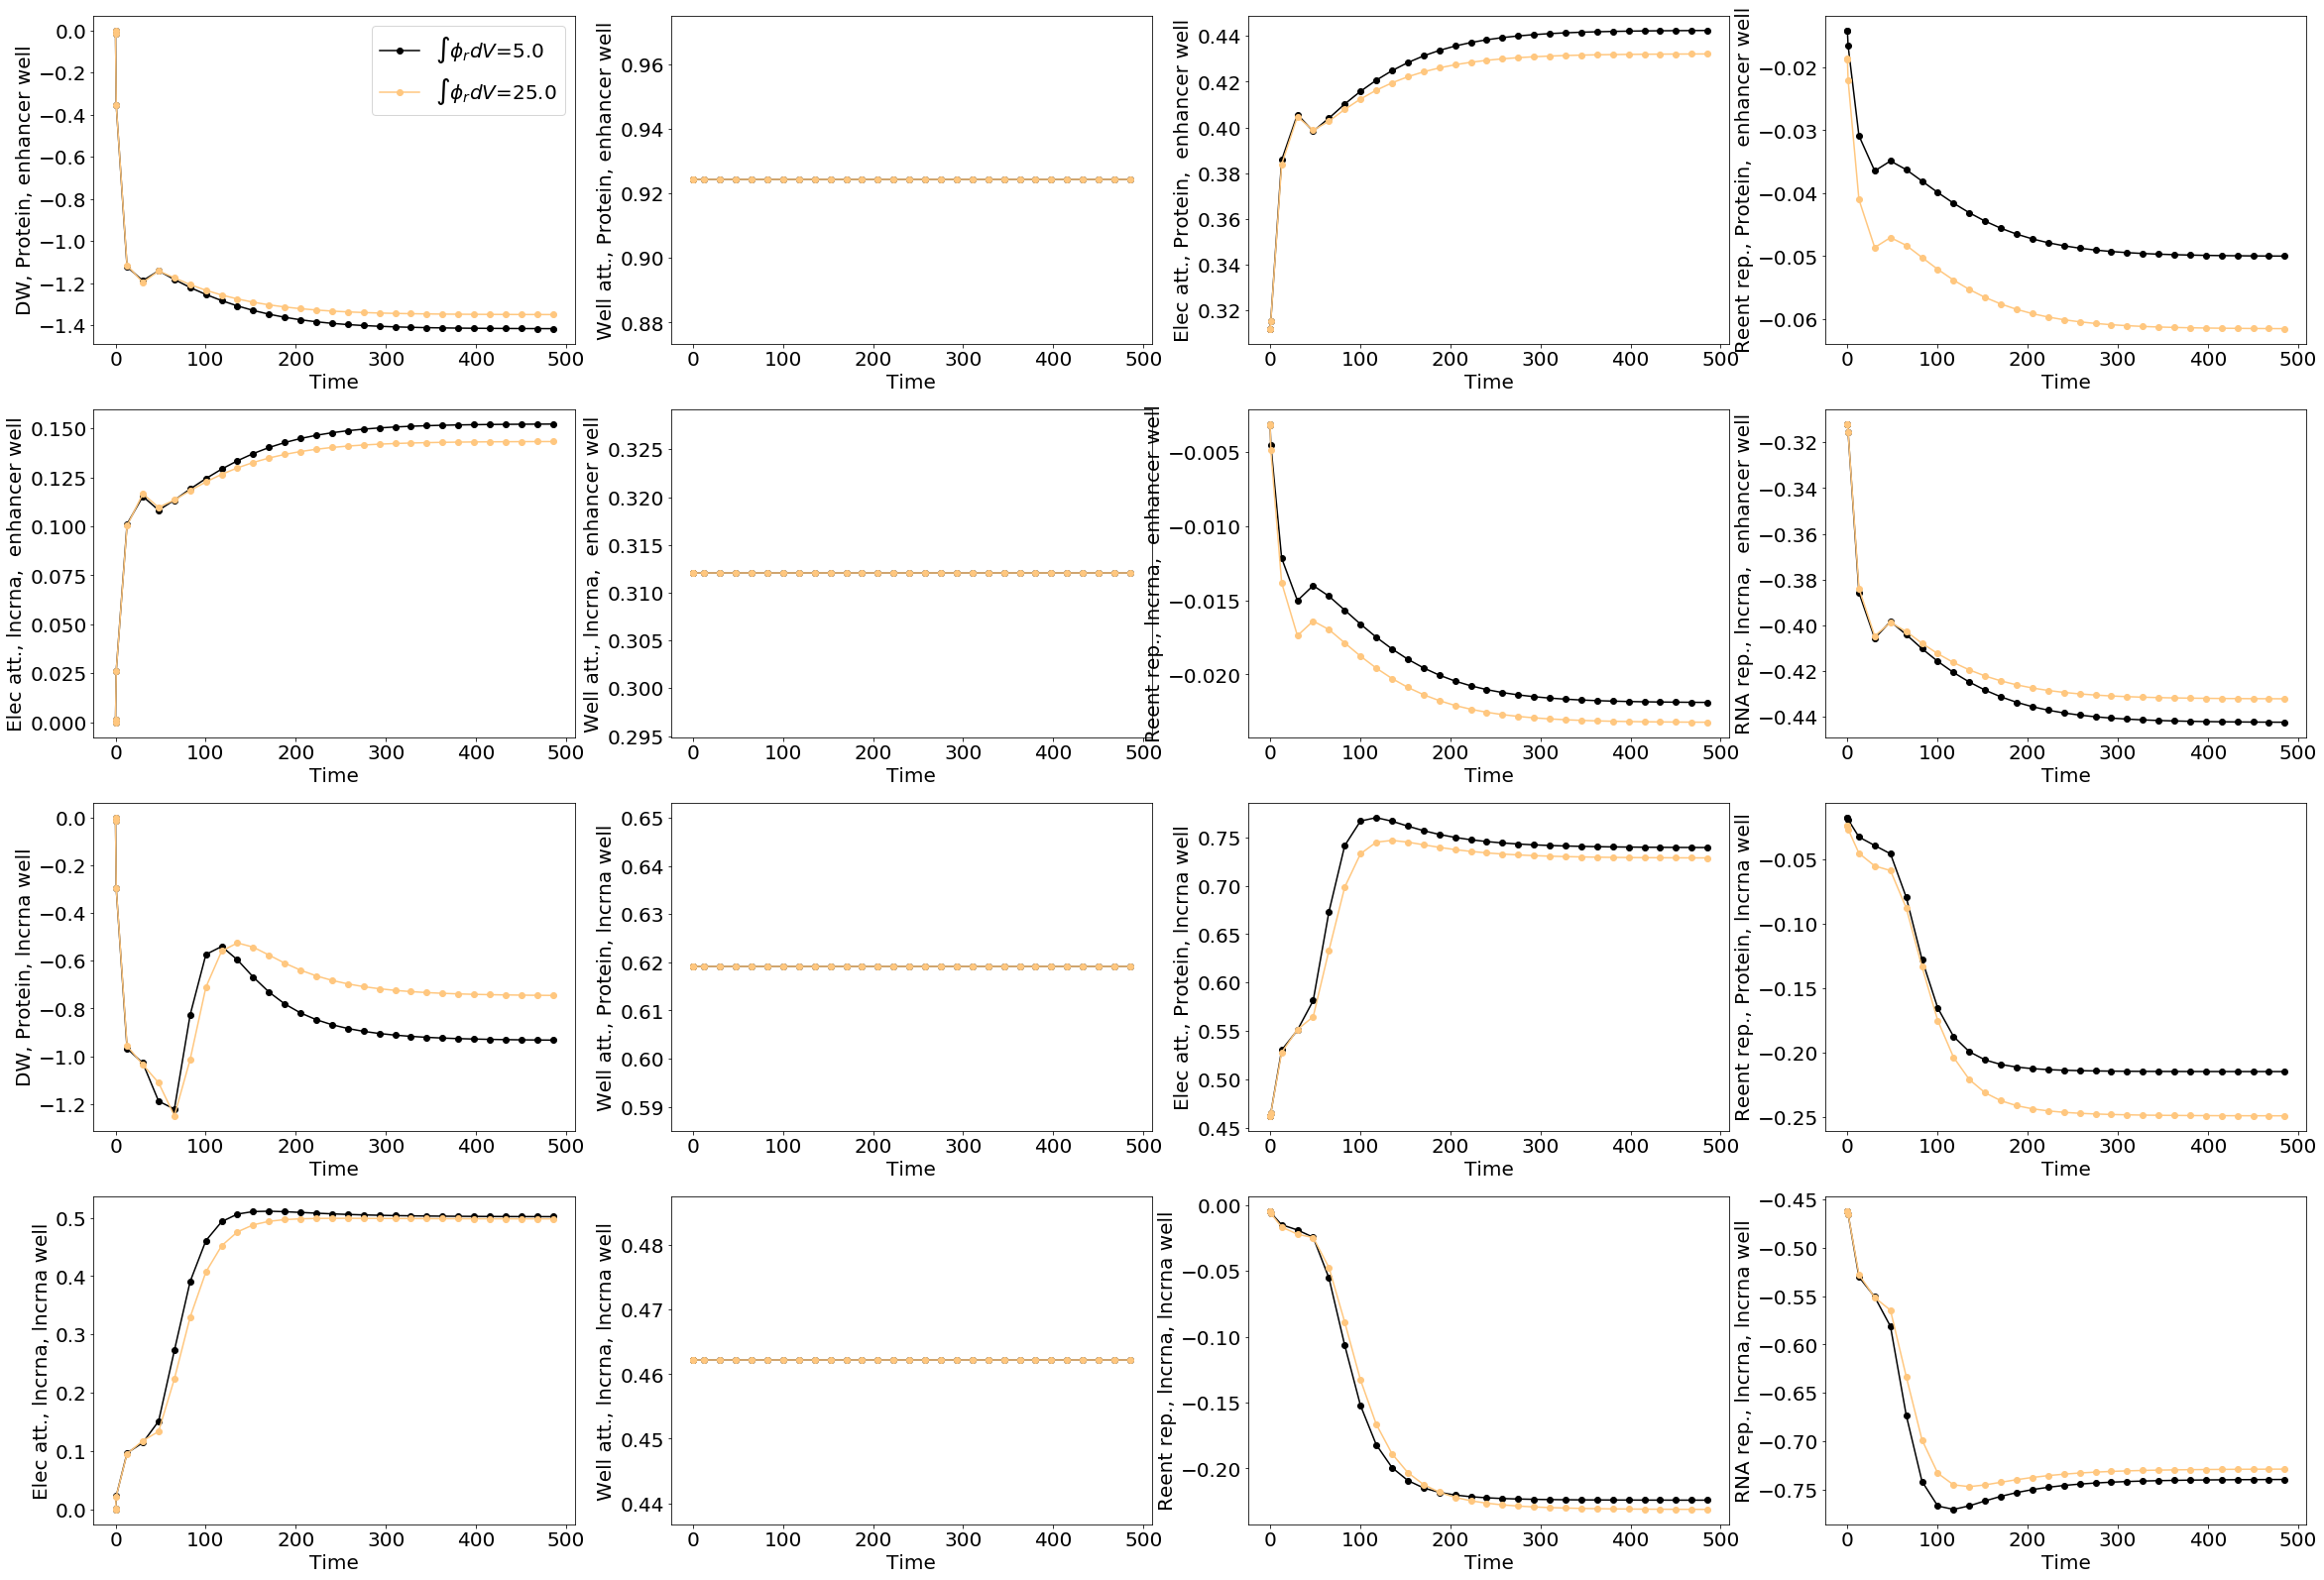

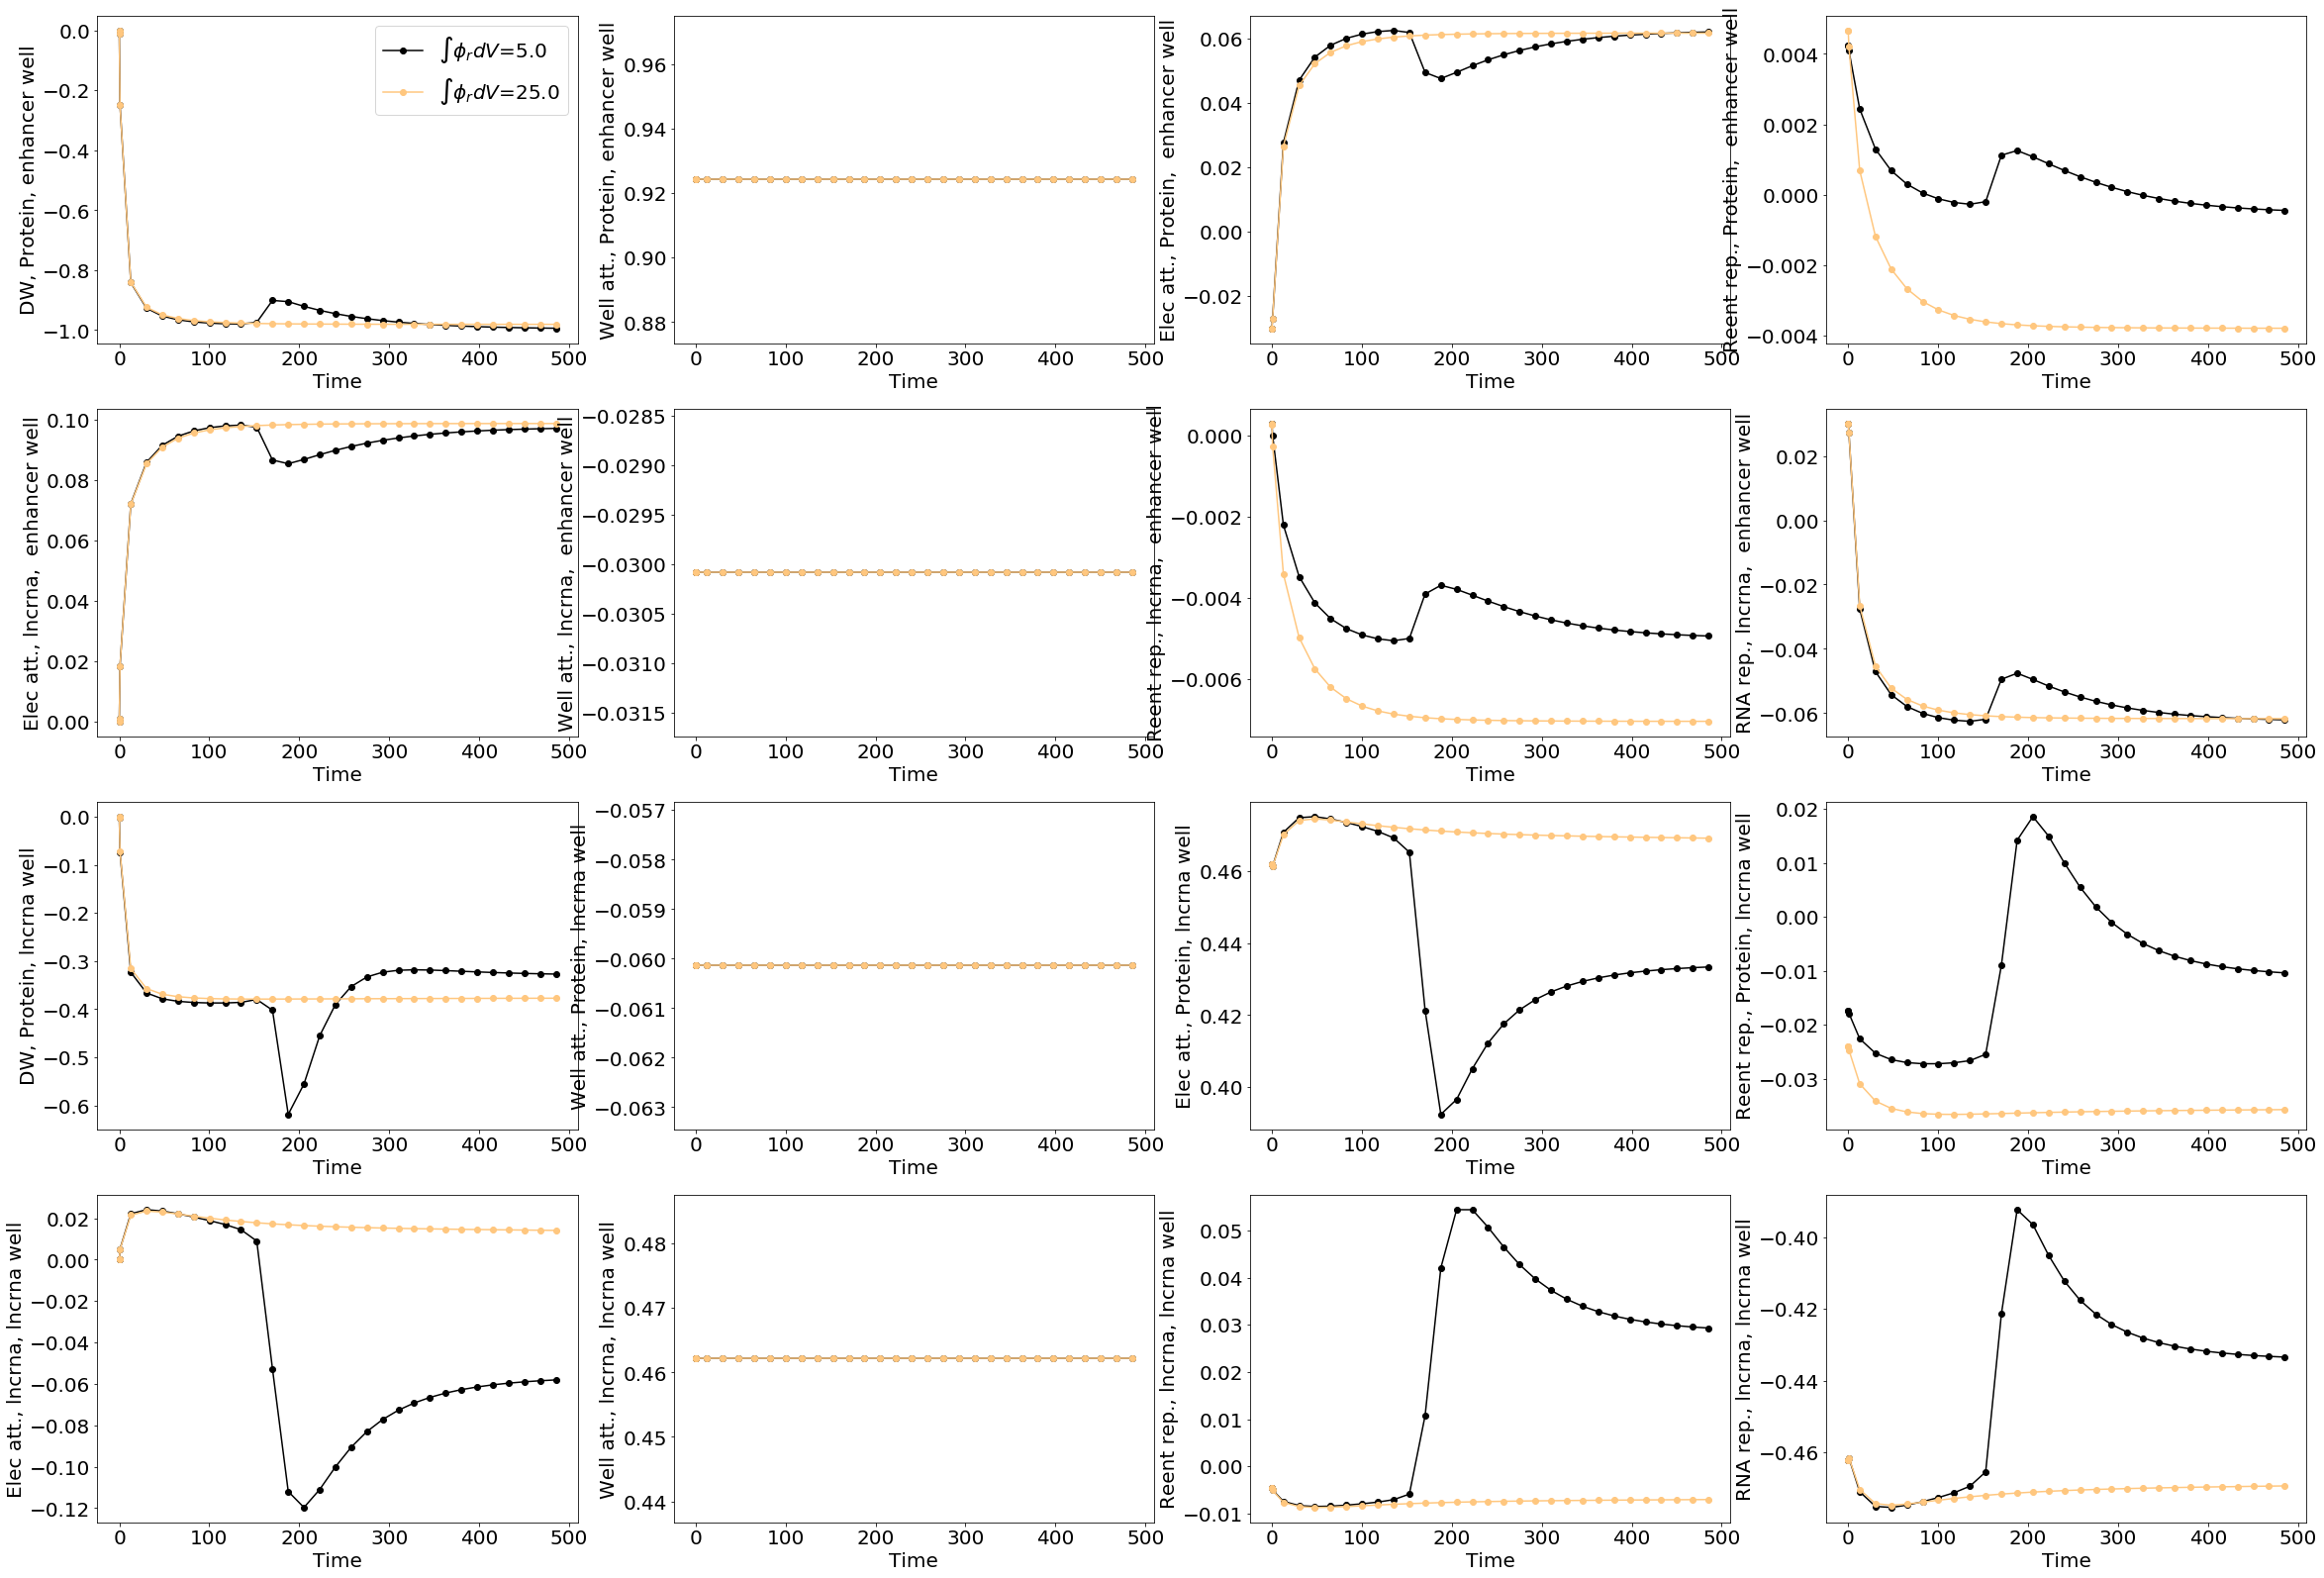

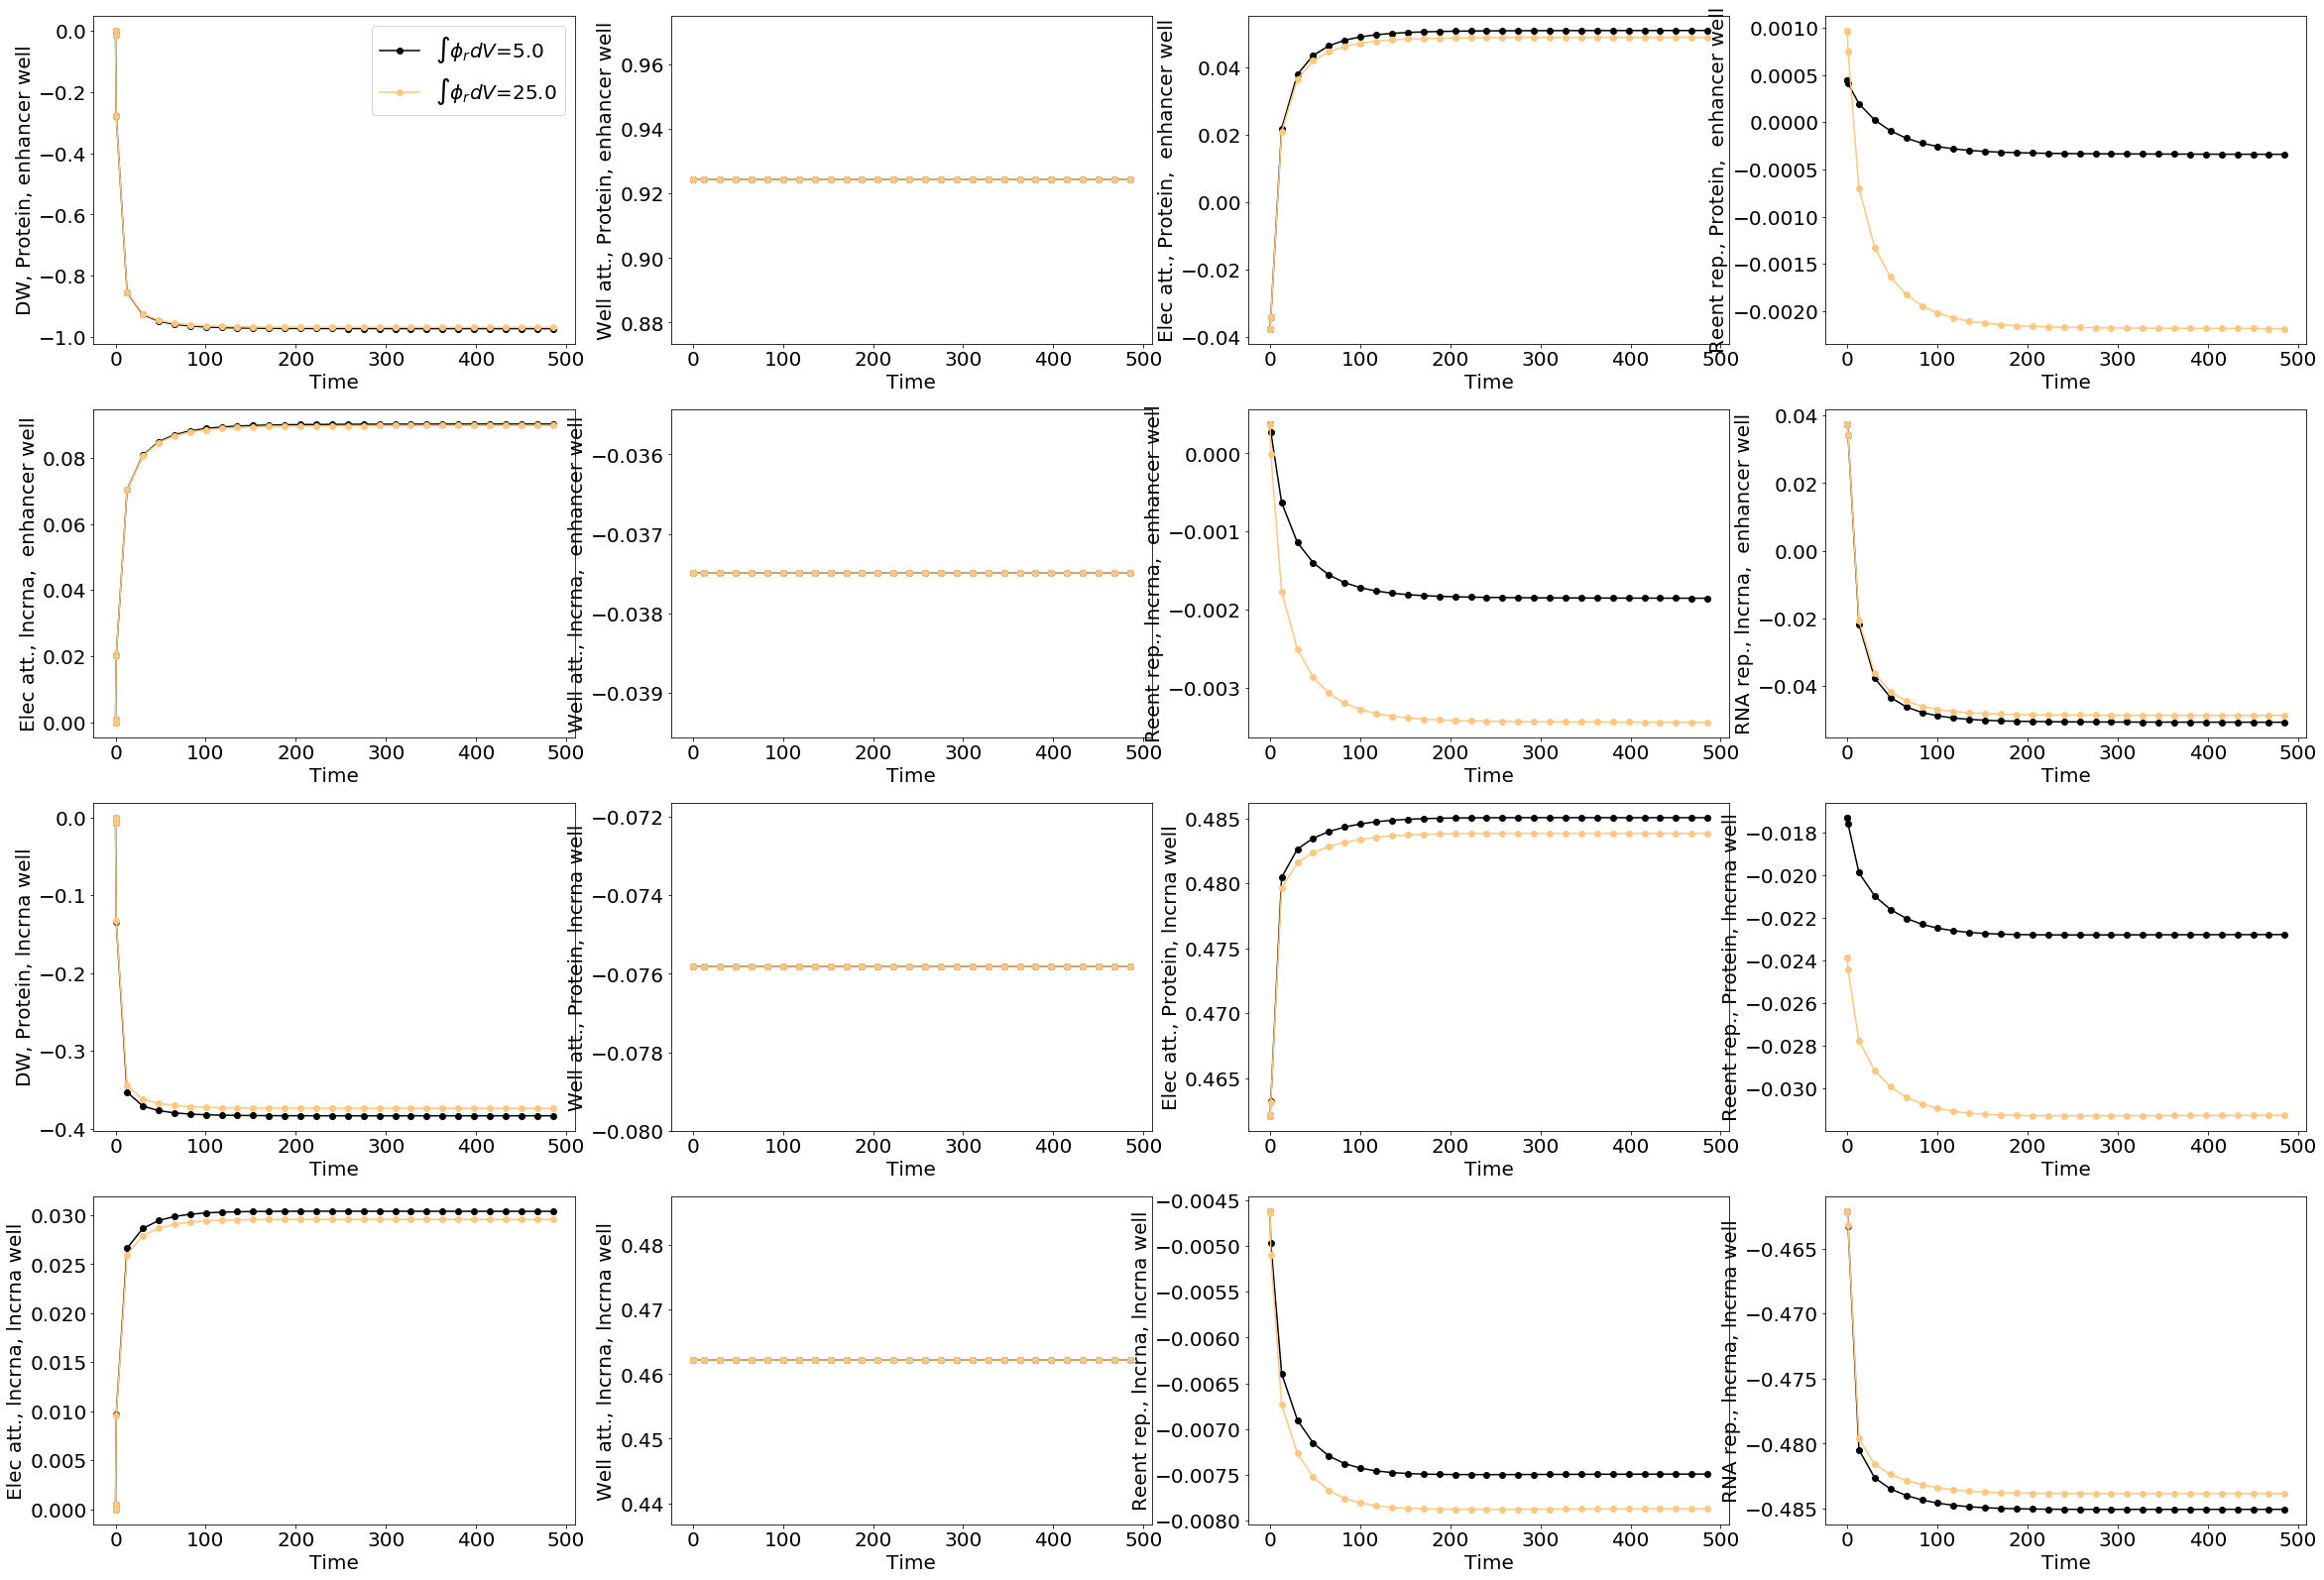

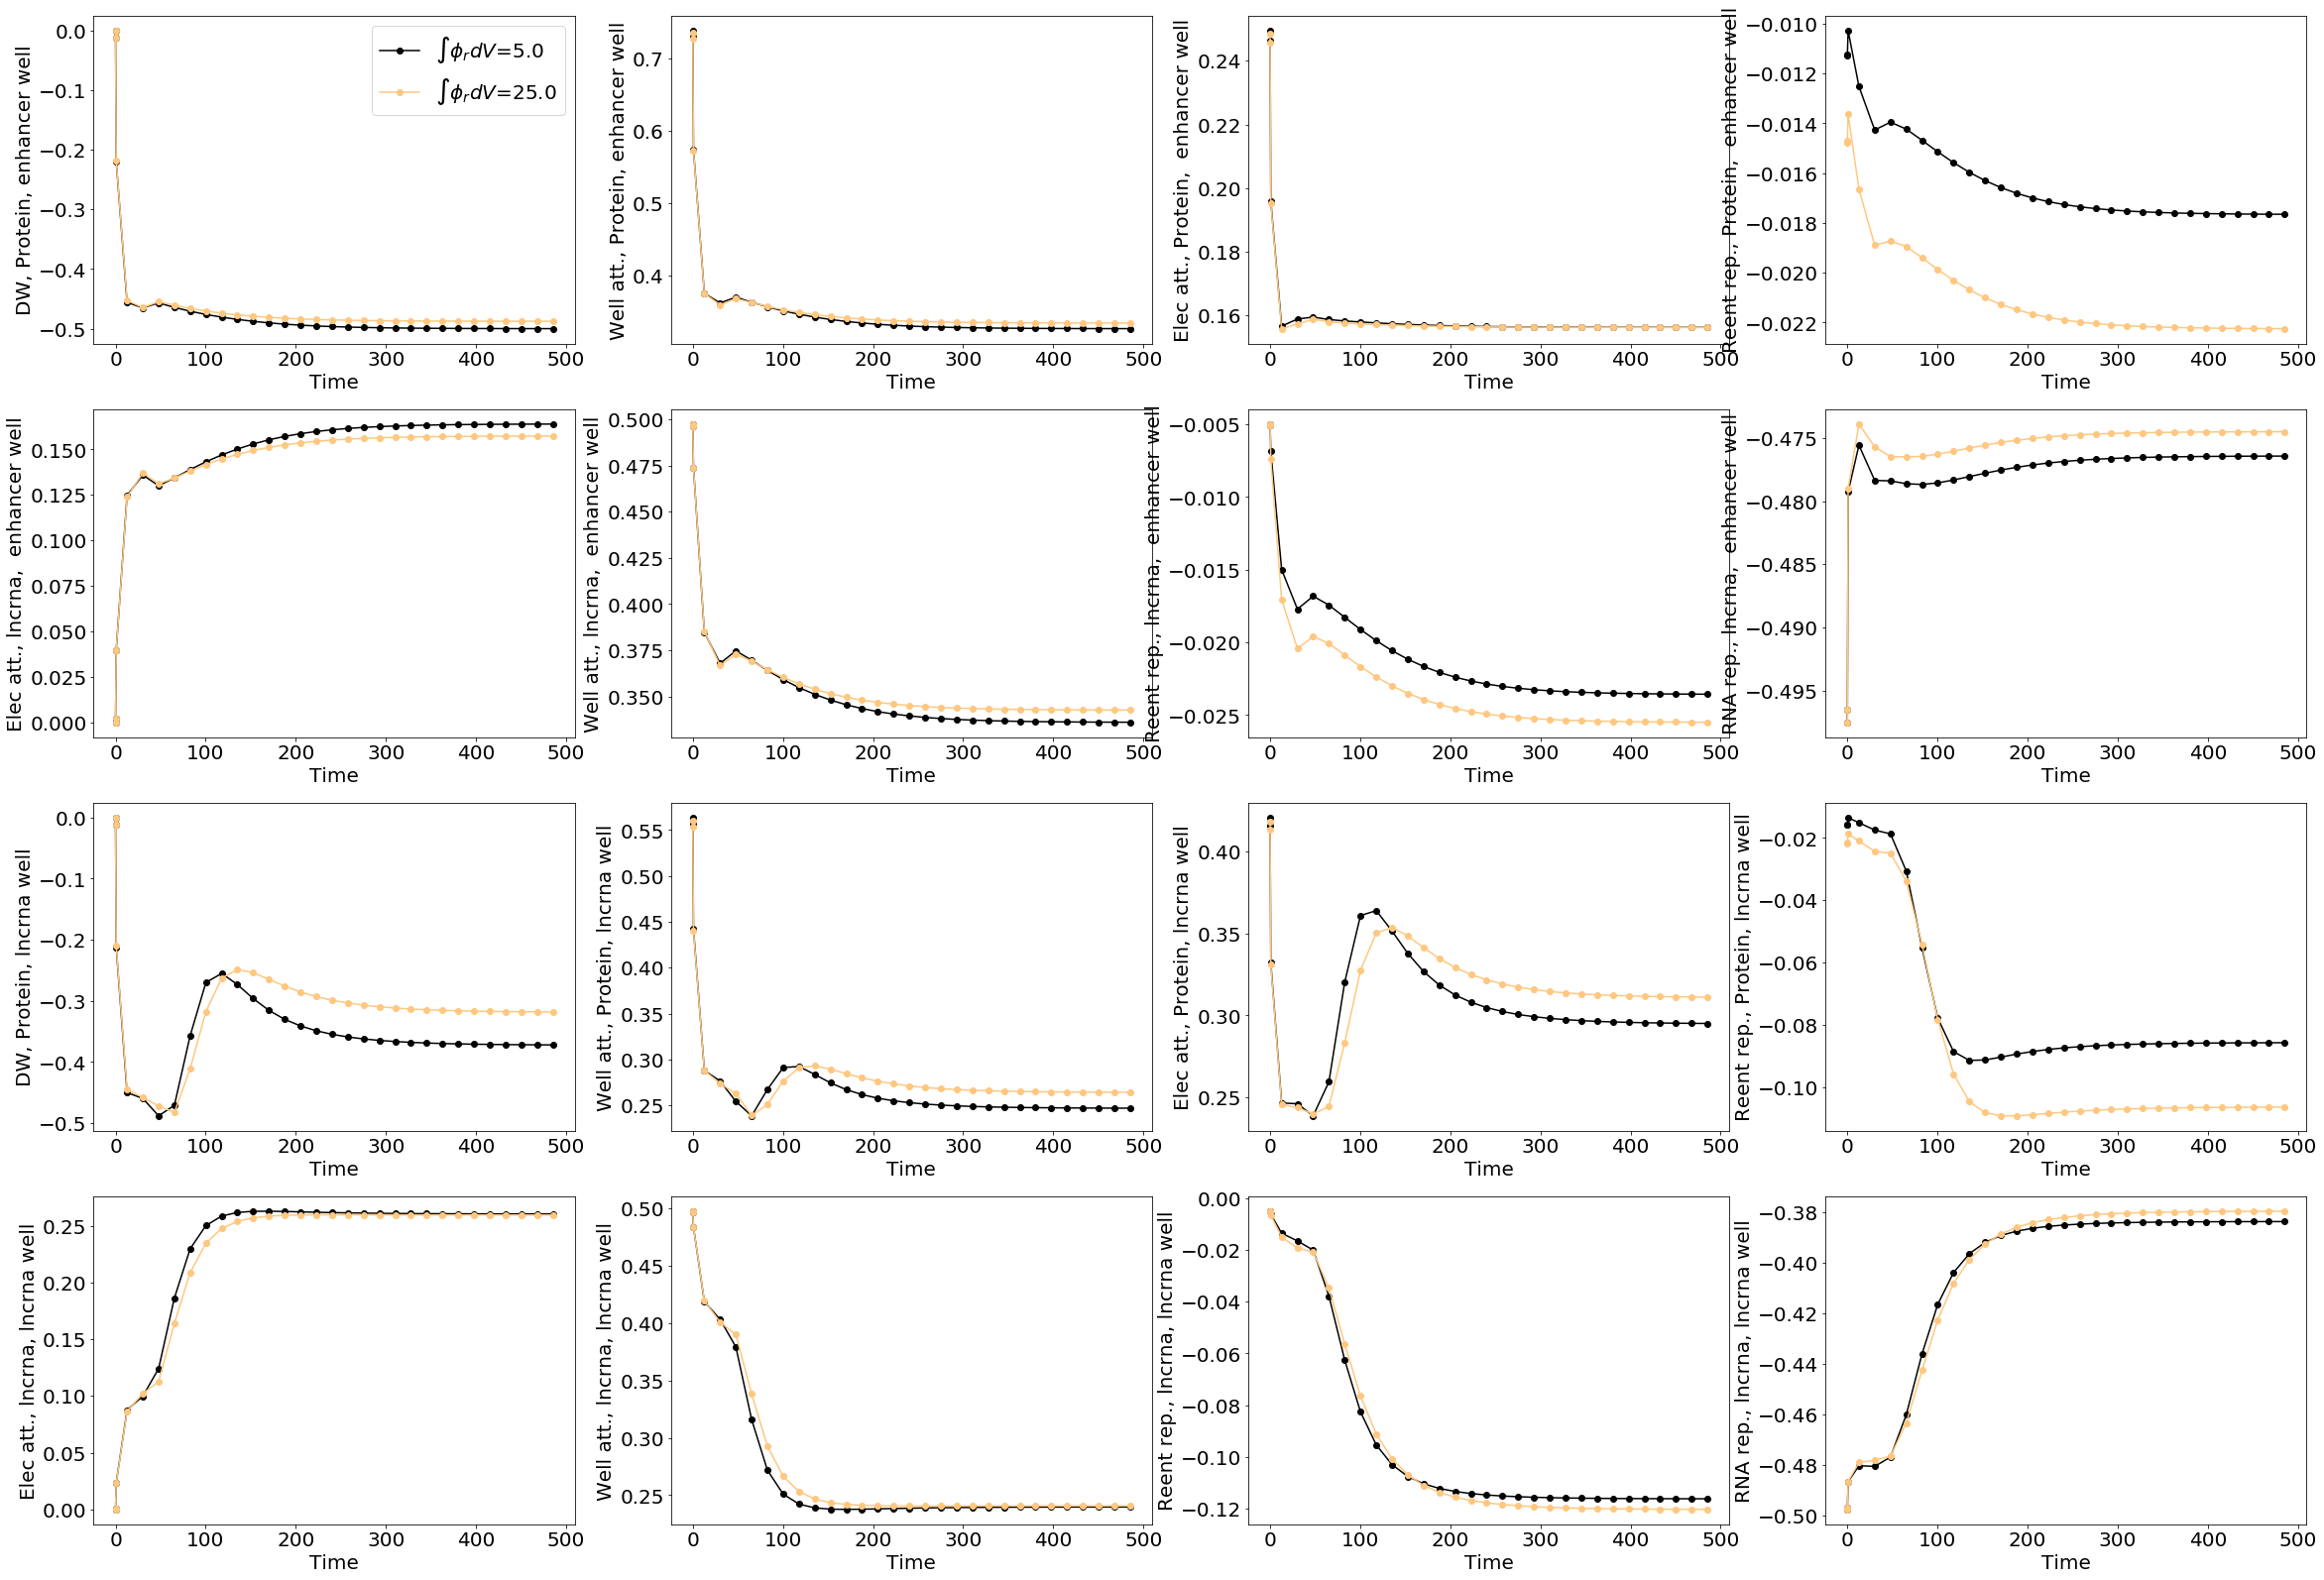

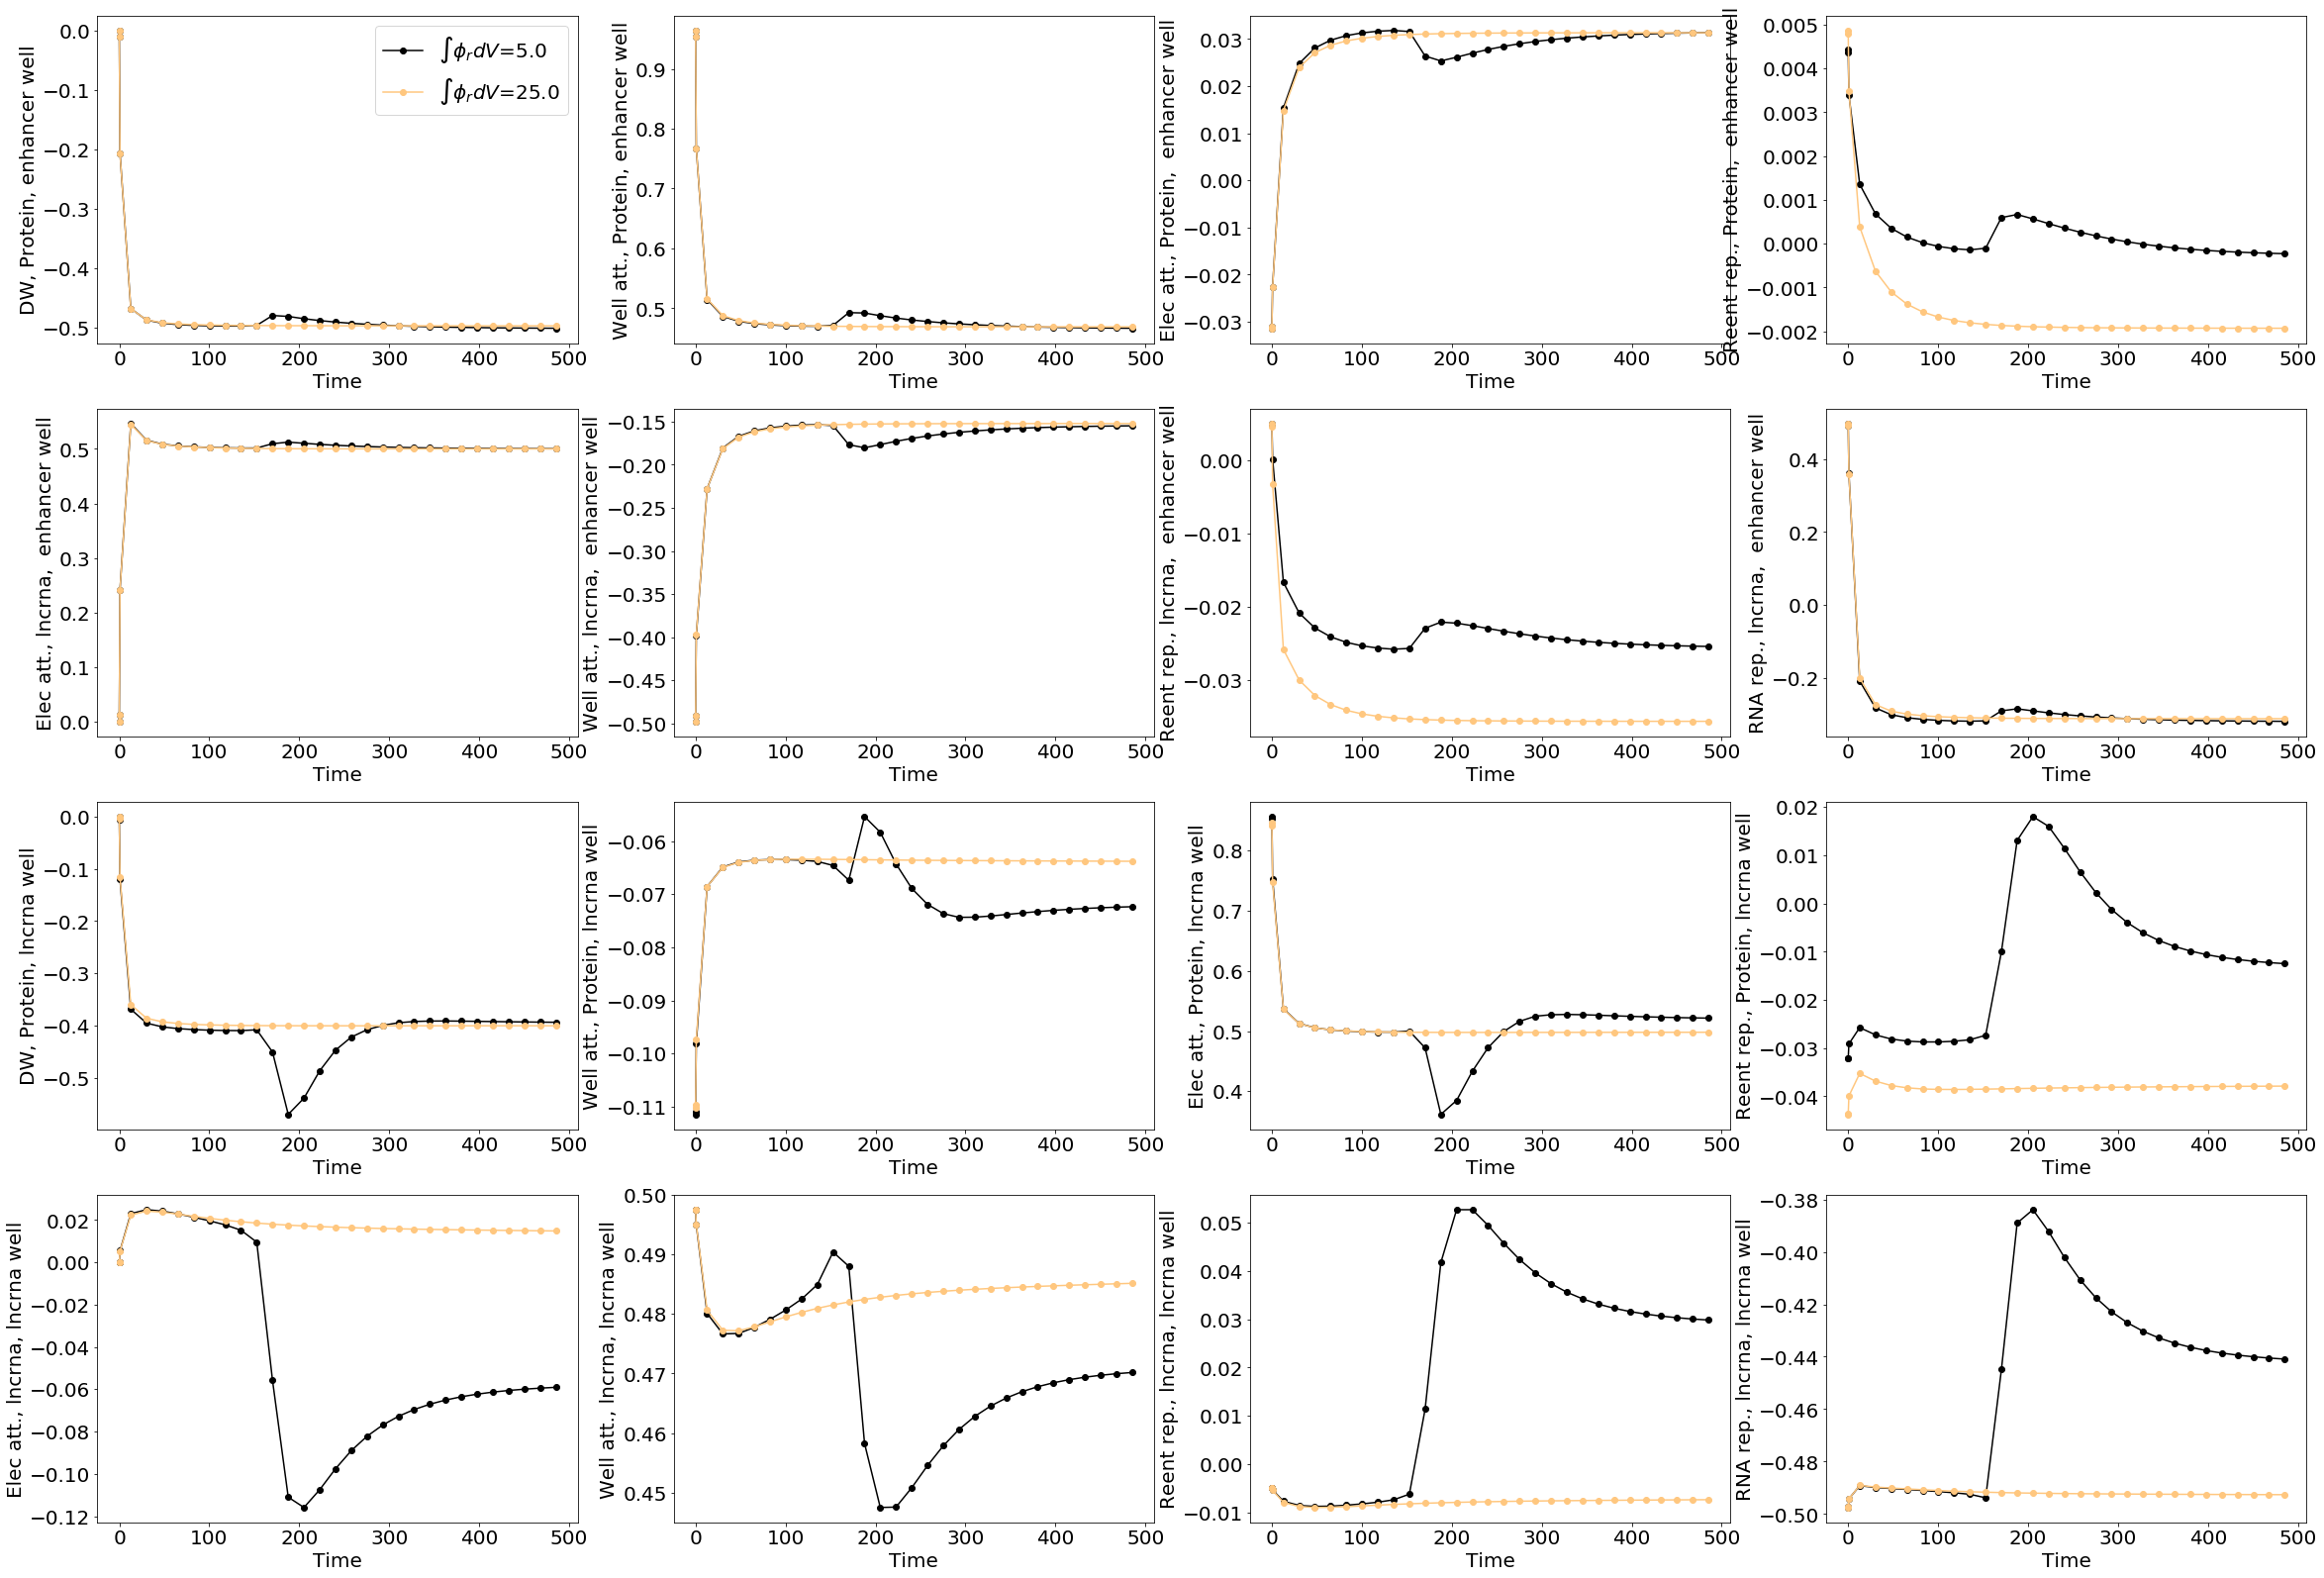

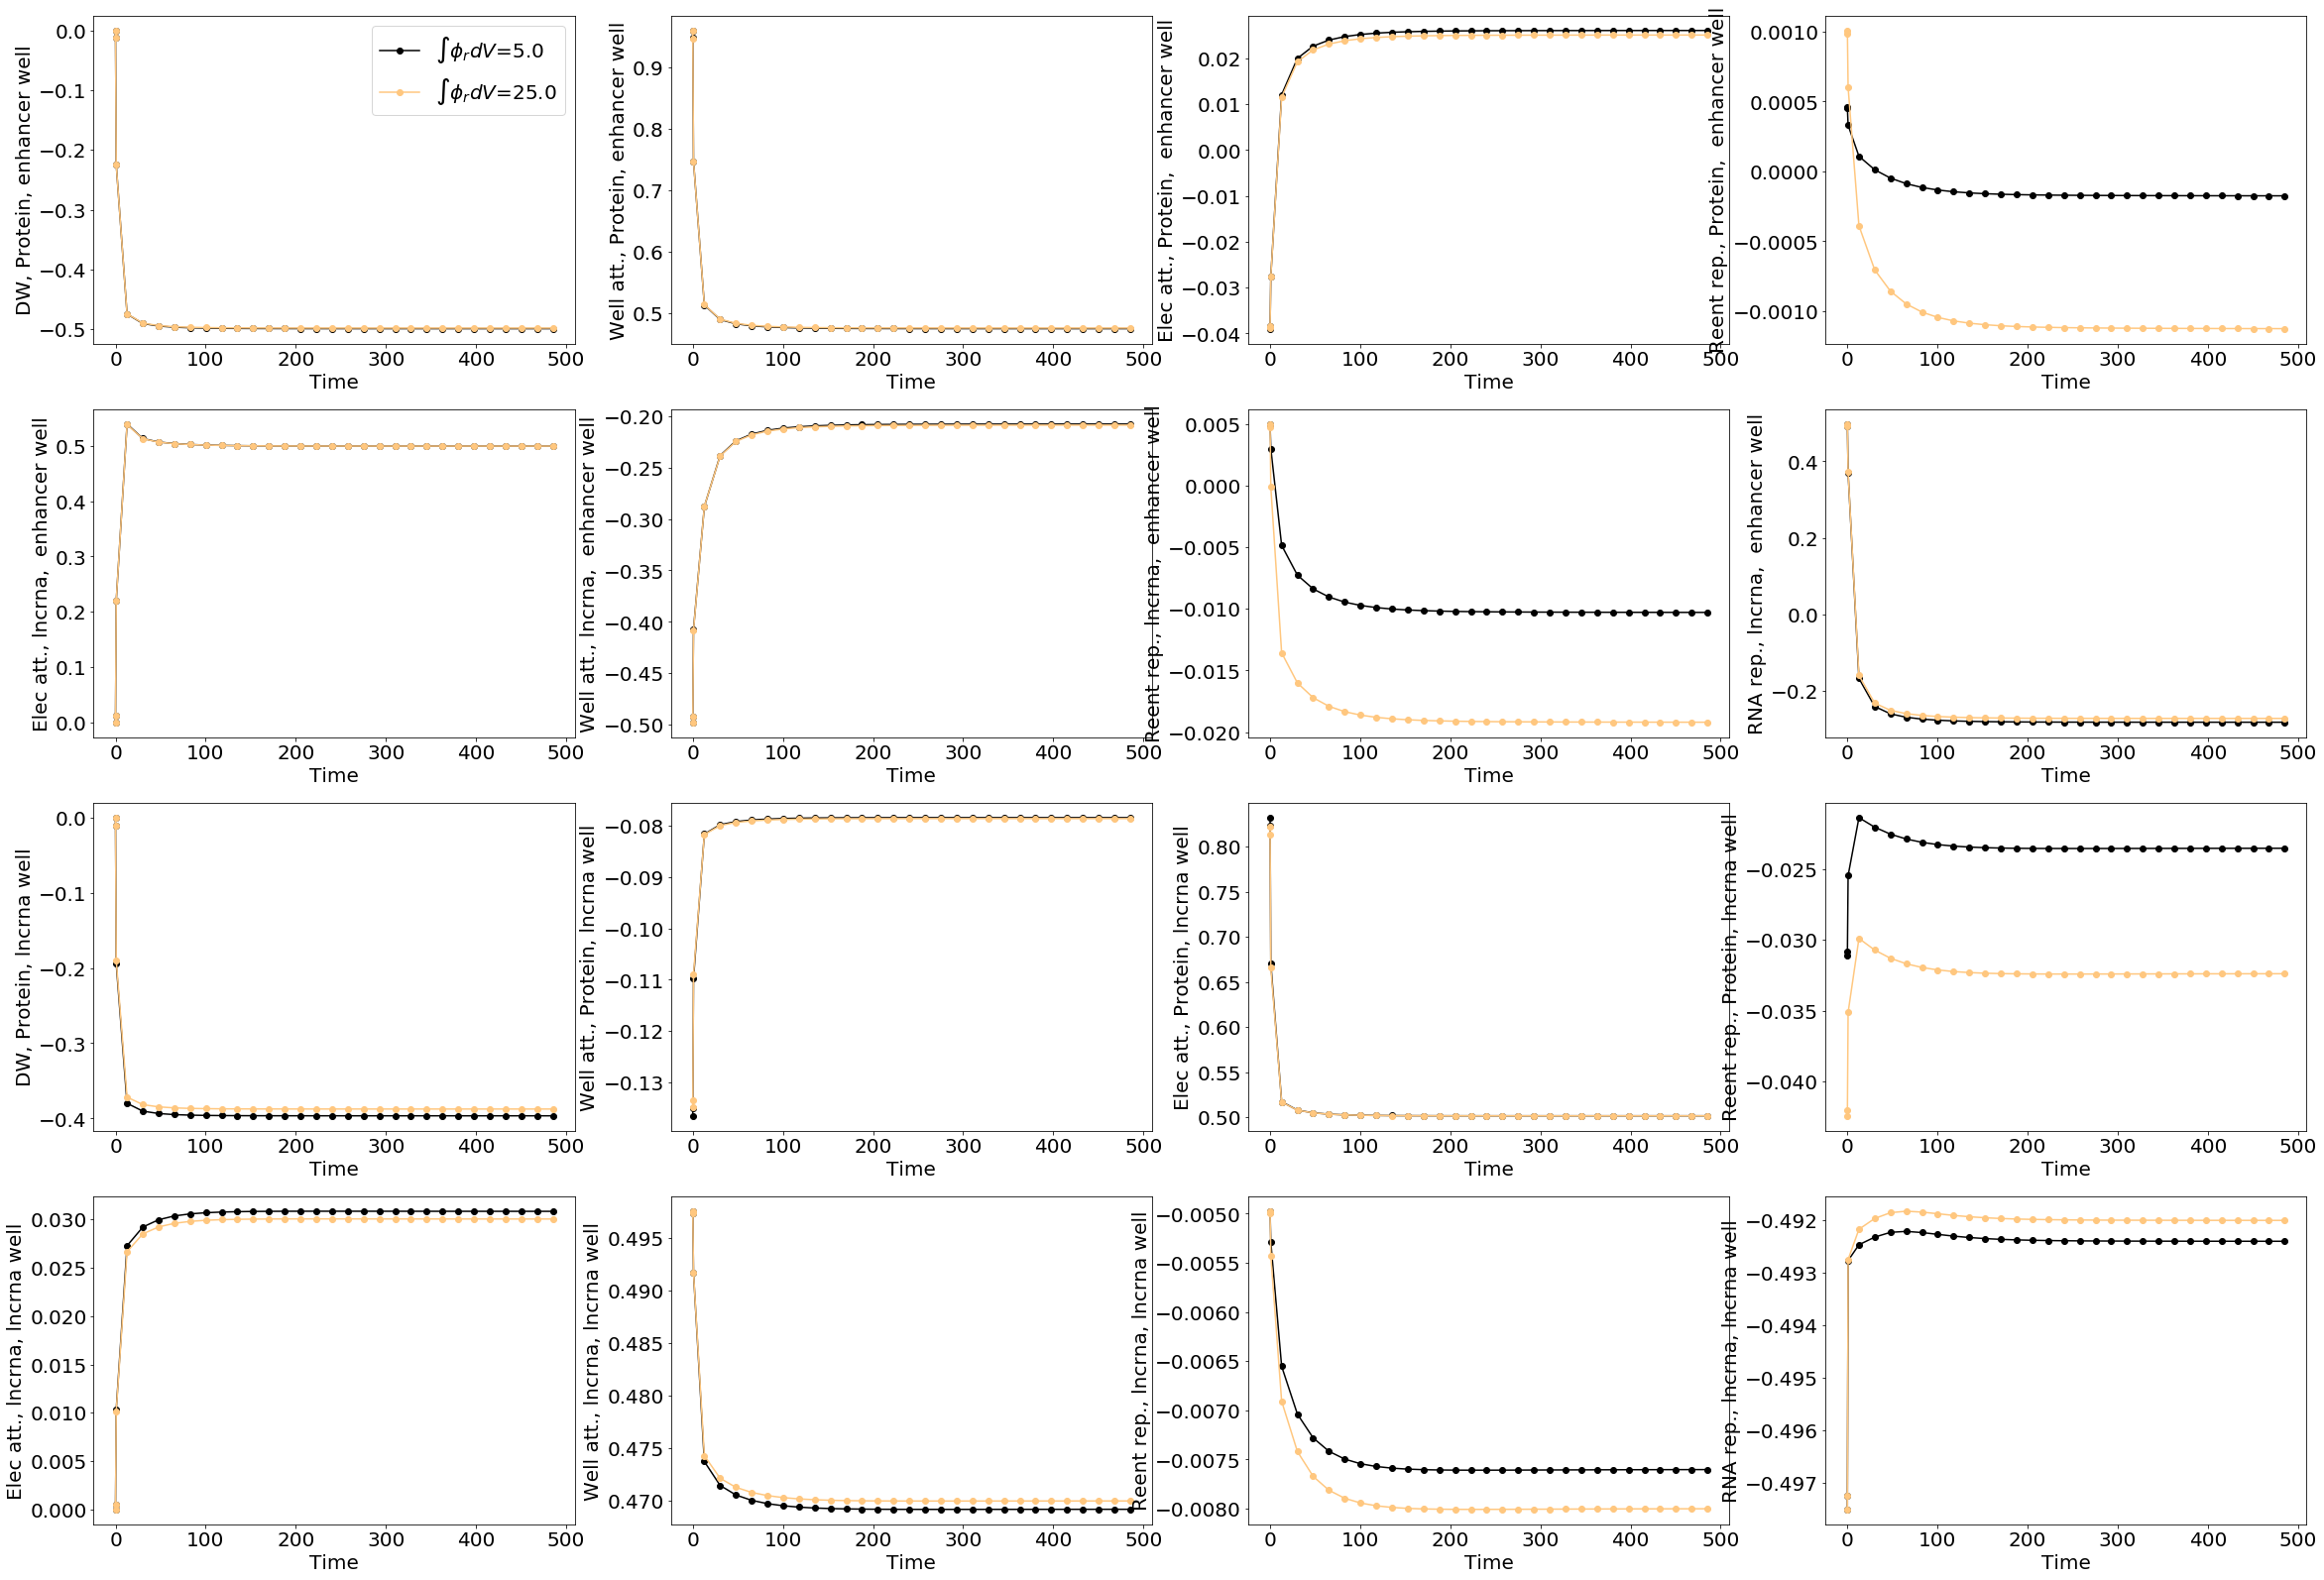

In [23]:
analysis_obj = LncrnaDataAnalysis()
analysis_obj.plot_flux_contributions_vary_phi_r(save_directory='20210907-LOCALIZED_LNCRNA_NO_MRNA_PRODUCTION/',
                                              save_filename='lncrna_no_activity_K_{kp}_L_P_{L_P}_flux_contributions.svg', 
                                              activity_and_lncrna_directory='/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/',
                                              activity_and_lncrna_pattern='.*phi_r_{phi_r}.*L_P_{L_P}_K_{kp}$',
                                              kp_list=[1.0], L_P_list=[3.0,7.0,12.0], phi_r_list=[5.0,25.0])        


## Plots for my 3rd year talk

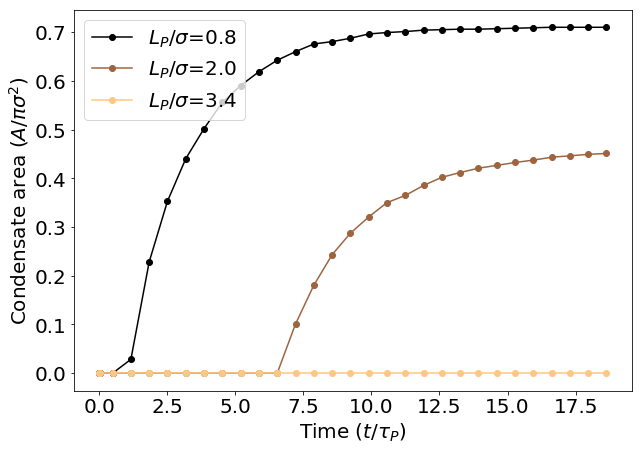

In [56]:
kp_list=[1.0]
L_P_list=[3.0,7.0,12.0]
phi_r_list=[10.0]
activity_and_lncrna_directory='/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/'
activity_and_lncrna_pattern='.*phi_r_{phi_r}.*L_P_{L_P}_K_{kp}$'
save_directory = '20210920-3rd year talk/'
param_file = 'input_params.txt'

colors = cm.get_cmap('copper', len(L_P_list))
color_values = np.linspace(0.0,1.0,len(L_P_list))

for i in range(len(phi_r_list)):
    for j in range(len(kp_list)):

        fig, axs = plt.subplots(1,1,figsize=(10,7))

        for k in range(len(L_P_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):

                regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[i],L_P=L_P_list[k],kp=kp_list[j]))
                match = re.search(regex, root)

                if match != None:

                    input_param_file = root + '/' + param_file
                    input_parameters = lh.input_parse(input_param_file)
                    radius = input_parameters['sigma']/(2)**0.5
                    A = input_parameters['c_beta'] - input_parameters['c_alpha']
                    tau = radius**2/(input_parameters['M_protein']*input_parameters['rho_s']*A**2)
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f:
                        # pdb.set_trace()
                        axs.plot(sp_f['t'][:]/tau, sp_f['condensate_area'][:]/(np.pi*radius**2), 
                                 '-o', c=colors(color_values[k]), label='$L_P/\sigma$={:.1f}'.format(L_P_list[k]/radius))
        axs.set_xlabel(r'Time ($t/\tau_P$)', fontsize=20)
        axs.set_ylabel('Condensate area ($A/\pi\sigma^2$)',fontsize=20)
        axs.legend(fontsize=20)

        plt.savefig(save_directory + "condensate_area.svg", format='svg', dpi=1200)
        plt.show()
        plt.close()   
   

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


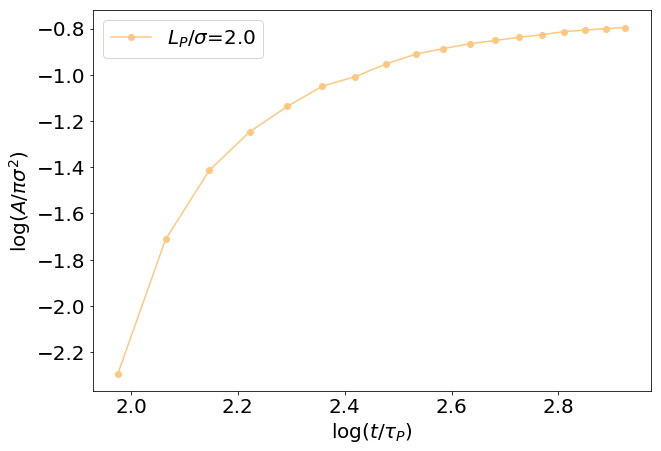

In [55]:
kp_list=[1.0]
L_P_list=[7.0]
phi_r_list=[10.0]
activity_and_lncrna_directory='/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/'
activity_and_lncrna_pattern='.*phi_r_{phi_r}.*L_P_{L_P}_K_{kp}$'
save_directory = '20210920-3rd year talk/'
param_file = 'input_params.txt'

colors = cm.get_cmap('copper', len(L_P_list))
color_values = np.linspace(0.0,1.0,len(L_P_list))

for i in range(len(phi_r_list)):
    for j in range(len(kp_list)):

        fig, axs = plt.subplots(1,1,figsize=(10,7))
        
        for k in range(len(L_P_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):

                regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[i],L_P=L_P_list[k],kp=kp_list[j]))
                match = re.search(regex, root)

                if match != None:

                    input_param_file = root + '/' + param_file
                    input_parameters = lh.input_parse(input_param_file)
                    radius = input_parameters['sigma']/(2)**0.5
                    A = input_parameters['c_beta'] - input_parameters['c_alpha']
                    tau = radius**2/(input_parameters['M_protein']*input_parameters['rho_s']*A**2)
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f:
                        # pdb.set_trace()
                        axs.plot(np.log(sp_f['t'][3:]/tau), np.log(sp_f['condensate_area'][3:]/(np.pi*radius**2)), 
                                 '-o', c=colors(color_values[k]), label='$L_P/\sigma$={:.1f}'.format(L_P_list[k]/radius))
        axs.set_xlabel(r'log$(t/\tau_P)$', fontsize=20)
        axs.set_ylabel('log$(A/\pi\sigma^2)$',fontsize=20)
        axs.legend(fontsize=20)

        plt.savefig(save_directory + "log_condensate_area.svg", format='svg', dpi=1200)
        plt.show()
        plt.close()                         

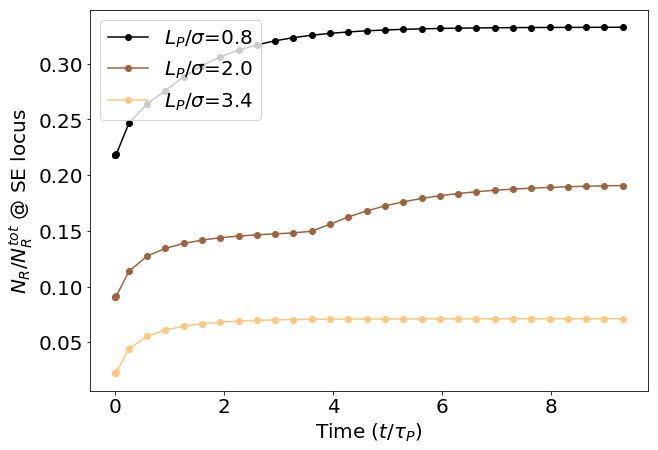

In [54]:
kp_list=[1.0]
L_P_list=[3.0,7.0,12.0]
phi_r_list=[10.0]
activity_and_lncrna_directory='/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/'
activity_and_lncrna_pattern='.*phi_r_{phi_r}.*L_P_{L_P}_K_{kp}$'
save_directory = '20210920-3rd year talk/'
param_file = 'input_params.txt'

colors = cm.get_cmap('copper', len(L_P_list))
color_values = np.linspace(0.0,1.0,len(L_P_list))

for i in range(len(phi_r_list)):
    for j in range(len(kp_list)):

        fig, axs = plt.subplots(1,1,figsize=(10,7))

        for k in range(len(L_P_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):

                regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[i],L_P=L_P_list[k],kp=kp_list[j]))
                match = re.search(regex, root)

                if match != None:

                    input_param_file = root + '/' + param_file
                    input_parameters = lh.input_parse(input_param_file)
                    radius = input_parameters['sigma']
                    A = input_parameters['c_beta'] - input_parameters['c_alpha']
                    tau = radius**2/(input_parameters['M_protein']*input_parameters['rho_s']*A**2)
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f:
                        # pdb.set_trace()
                        axs.plot(sp_f['t'][:]/tau, sp_f['average_lncrna_in_enhancer_well'][:]*np.pi*radius**2/input_parameters['rna_nucleus_phi'], 
                                 '-o', c=colors(color_values[k]), label='$L_P/\sigma$={:.1f}'.format(L_P_list[k]/(radius/2**0.5)))
        axs.set_xlabel(r'Time $(t/\tau_P)$', fontsize=20)
        axs.set_ylabel('$N_R/N^{tot}_R$ @ SE locus',fontsize=20)
        axs.legend(fontsize=20)

        plt.savefig(save_directory + "RNA_concentration.svg", format='svg', dpi=1200)
        plt.show()
        plt.close()      

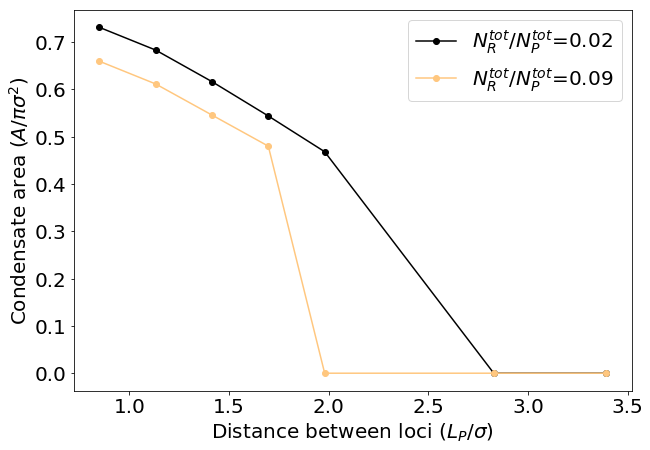

In [53]:
kp_list=[1.0]
L_P_list=[3.0,4.0,5.0,6.0,7.0,10.0,12.0]
phi_r_list=[5.0,25.0]
activity_and_lncrna_directory='/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/LNCRNA_RESCUES_CONDENSATE/'
activity_and_lncrna_pattern='.*phi_r_{phi_r}.*L_P_{L_P}_K_{kp}$'
save_directory = '20210920-3rd year talk/'
param_file = 'input_params.txt'

colors = cm.get_cmap('copper', len(phi_r_list))
color_values = np.linspace(0.0,1.0,len(phi_r_list))

fig, axs = plt.subplots(1,1,figsize=(10,7))

for i in range(len(phi_r_list)):
    for j in range(len(kp_list)):
        
        ss_values = np.zeros(len(L_P_list))
        distances = np.zeros(len(L_P_list))
        
        for k in range(len(L_P_list)):
            for root, dirs, files in os.walk(activity_and_lncrna_directory):

                regex = re.compile(activity_and_lncrna_pattern.format(phi_r=phi_r_list[i],L_P=L_P_list[k],kp=kp_list[j]))
                match = re.search(regex, root)

                if match != None:

                    input_param_file = root + '/' + param_file
                    input_parameters = lh.input_parse(input_param_file)
                    radius = input_parameters['sigma']/(2)**0.5
                    domain_radius = 0.5*input_parameters['nx']*input_parameters['dx']
                    with h5py.File(root + '/dynamical_trajectories.hdf5') as sp_f:
                        # pdb.set_trace()
                        ss_values[k] = sp_f['condensate_area'][-1]/(np.pi*radius**2)
                        distances[k] = input_parameters['rna_nucleus_distance_to_protein']/radius
        
    axs.plot(distances, ss_values, '-o', c=colors(color_values[i]), label='$N^{tot}_R/N^{tot}_P$' + '={:.2f}'.format(input_parameters['rna_nucleus_phi']/(np.pi*input_parameters['phi_p_0']*domain_radius**2)))
    axs.set_xlabel(r'Distance between loci ($L_P/\sigma$)', fontsize=20)
    axs.set_ylabel('Condensate area ($A/\pi\sigma^2$)',fontsize=20)
    axs.legend(fontsize=20)

plt.savefig(save_directory + "steady_state_condensate_area.svg", format='svg', dpi=1200)
plt.show()
plt.close() 